# Projet 8 : Traitement d'images pour le système embarqué d'une voiture autonome

## 🌐 Contexte
Ce projet s'inscrit dans le développement d'un **système embarqué de vision par ordinateur** pour véhicules autonomes chez **Future Vision Transport**. L'entreprise conçoit des systèmes permettant aux véhicules autonomes de percevoir leur environnement grâce à l'analyse d'images en temps réel.

## ⚡ Mission
En tant qu'ingénieur IA dans l'équipe R&D, notre mission est de **développer le module de segmentation d'images** (composant 3) qui s'intègre entre le module de traitement d'images (2) et le système de décision (4). Ce module doit être capable d'**identifier et de segmenter précisément 8 catégories principales d'objets** dans des images de caméras embarquées.

## 🎯 Objectifs pédagogiques
- Développer un modèle de segmentation d'images performant avec Keras/TensorFlow
- Concevoir et déployer une API REST avec FastAPI
- Créer une application web de démonstration avec Next.js
- Mettre en place un pipeline d'entraînement et de déploiement complet
- Évaluer et améliorer les performances du modèle
- Documenter le processus et les résultats de façon claire et professionnelle

## 🗓️ Plan de travail

1. **Exploration et préparation des données**
   - Analyse du jeu de données fourni par Franck (images et masques segmentés)
   - Prétraitement et augmentation des données
   - Création d'un générateur de données optimisé

2. **Développement du modèle de segmentation**
   - Étude des architectures de l'état de l'art (U-Net, DeepLabV3+, etc.)
   - Implémentation avec Keras
   - Entraînement et optimisation du modèle

3. **Déploiement du modèle**
   - Développement d'une API FastAPI
   - Création d'une application frontend Next.js
   - Déploiement sur Railway et Vercel

4. **Évaluation et documentation**
   - Tests et validation des performances
   - Rédaction du rapport technique
   - Préparation de la présentation

## GPU et mémoire RAM

In [6]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/bin/bash: line 1: nvidia-smi: command not found


In [7]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [8]:
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')

In [9]:
# ====================================================================
# GESTION DE LA VRAM
# ====================================================================

import gc
import tensorflow as tf

def deep_clean_memory():
    """
    Nettoyage complet de la mémoire entre les modèles
    ESSENTIEL pour éviter l'accumulation VRAM !
    """
    print("🧹 Nettoyage mémoire approfondi...")

    # 1. Nettoyer le backend Keras (le plus important)
    tf.keras.backend.clear_session()

    # 2. Forcer le garbage collector Python
    gc.collect()

    # 3. Nettoyer les graphes TensorFlow
    try:
        # Reset des graphes par défaut
        tf.compat.v1.reset_default_graph()
    except:
        pass

    # 4. Forcer la libération mémoire GPU si disponible
    if tf.config.list_physical_devices('GPU'):
        try:
            # Forcer la synchronisation GPU
            with tf.device('/GPU:0'):
                tf.constant([1.0])  # Petite opération pour forcer sync
        except:
            pass

    print("✅ Mémoire nettoyée")

def monitor_gpu_memory(stage=""):
    """Surveillance optionnelle de la VRAM"""
    try:
        import GPUtil
        gpus = GPUtil.getGPUs()
        if gpus:
            gpu = gpus[0]
            used_gb = gpu.memoryUsed / 1024
            total_gb = gpu.memoryTotal / 1024
            print(f"🖥️  {stage} VRAM: {used_gb:.1f}GB/{total_gb:.1f}GB ({gpu.memoryPercent:.1f}%)")
            return gpu.memoryUsed
    except:
        pass
    return None

## 🔗 Connexion à Google Drive

In [10]:
from google.colab import drive
drive.mount('/content/drive')
import os
drive_folder=  "/content/drive/MyDrive/Colab_Notebooks/Project_8/notebooks"
os.chdir(drive_folder)
os.listdir()

Mounted at /content/drive


['content',
 'unet_architecture_simple.png',
 'Copie 2 de p8_notebook_MobileNetV2_UNet.ipynb',
 'model_architecture_1.png',
 'model_architecture_2.png',
 'model_architecture_3.png',
 'artifacts',
 'Copie de p8_notebook.ipynb',
 'Copie de p8_notebook_MobileNetV2_UNet.ipynb',
 'results',
 'p8_notebook.ipynb']

## 🚗 Jeu de données

Nous utilisons le jeu de données [Cityscapes](https://www.cityscapes-dataset.com/dataset-overview/) qui se concentre sur la compréhension sémantique des scènes urbaines.

Pour notre modèle de segmentation d'images, nous exploitons les **5 000 images annotées avec des annotations fines** (fine annotations). Exemples [ici](https://www.cityscapes-dataset.com/examples/#fine-annotations).

Ce dataset présente plusieurs caractéristiques essentielles pour notre cas d'usage :
- Des annotations polygonales permettant une segmentation sémantique dense
- Une couverture de 30 classes dont nous retiendrons uniquement les **8 catégories principales** déjà définies [ici](https://www.cityscapes-dataset.com/dataset-overview/#class-definitions) : ***flat***, ***human***, ***vehicle***, ***construction***, ***object***, ***nature***, ***sky***, ***void***.
- Une diversité importante avec des données provenant de **50 villes différentes**, capturées sur plusieurs mois (printemps, été, automne)
- Des conditions variées mais contrôlées (jour, conditions météorologiques bonnes à moyennes)
- Des **scènes sélectionnées manuellement pour leur complexité** (nombreux objets dynamiques, variations dans l'agencement des scènes et l'arrière-plan)

**Documentation**

- https://www.cityscapes-dataset.com/dataset-overview/
- https://github.com/mcordts/cityscapesScripts



Nous utilisons le jeu de données **Cityscapes** qui contient **5 000 images avec des annotations fines**. La séparation entre *train*, *val* et *test* est déjà effectuée :
- Entraînement : 2 975
- Validation : 500
- Test : 1 525

Le format Cityscapes fournit plusieurs fichiers d'annotation pour chaque image originale. Cette structure facilite différentes approches de traitement et d'apprentissage. Pour chaque image d'origine, nous disposons de :
- Des fichiers `*_gtFine_instanceIds.png` qui encodent à la fois la classe et l'identifiant d'instance de chaque pixel
- Des fichiers `*_gtFine_labelIds.png` qui contiennent uniquement les identifiants de classe pour la segmentation sémantique
- Des fichiers `*_gtFine_color.png` qui offrent une représentation visuelle colorée des segmentations
- Des fichiers `*_gtFine_polygons.json` qui stockent les annotations sous forme vectorielle (polygones)

Cette richesse d'annotations nous permettra de développer un modèle robuste pour notre système de vision par ordinateur embarqué chez Future Vision Transport.

## Configuration de l'environnement et des dépendances

In [11]:
!pip install mlflow boto3 dotenv git+https://github.com/qubvel/segmentation_models.git --quiet

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.8/25.8 MB 66.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.1/140.1 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.3/85.3 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 681.8/681.8 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━

In [12]:
# ---------------------------------------
# Imports Système et Utilitaires
# ---------------------------------------
import os
import sys
import random
import json
import shutil
import zipfile
from datetime import datetime
import glob
import time  # ← Ajouté pour mesurer le temps d'entraînement
import tempfile

# ---------------------------------------
# Data Science & Manipulation
# ---------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image as PILImage
from tqdm import tqdm
import requests
import itertools
from sklearn.metrics import confusion_matrix

# ---------------------------------------
# Scikit-learn : pour gestion du split train/test
# ---------------------------------------
from sklearn.model_selection import train_test_split

# ---------------------------------------
# TensorFlow & Keras (version tensorflow.keras pour compatibilité)
# ---------------------------------------
import tensorflow as tf
from tensorflow import data as tf_data
from tensorflow import keras
from tensorflow.keras import callbacks  # ← Ajouté pour les callbacks
import tensorflow.keras.backend as K  # backend Keras TensorFlow

# ---------------------------------------
# Segmentation Models : patch pour forcer backend tf.keras
# ---------------------------------------
import segmentation_models as sm
sm.set_framework('tf.keras')  # on fixe tf.keras comme backend
sm.backend = K                # on force le backend keras tensorflow

# ---------------------------------------
# MLflow : suivi d'expériences & gestion modèles
# ---------------------------------------
import mlflow
import mlflow.keras
import mlflow.tensorflow  # ← Ajouté pour mlflow.tensorflow.autolog()
from mlflow.models.signature import infer_signature
from mlflow import MlflowClient
from mlflow.models.signature import ModelSignature
from mlflow.types import Schema, ColSpec, TensorSpec

# ---------------------------------------
# Environnements Colab & variables d'environnement
# ---------------------------------------
from google.colab import userdata
from dotenv import load_dotenv

# Chargement des variables d'environnement du fichier .env
load_dotenv(dotenv_path='../.env')

# Ajouter le dossier parent du notebook au PYTHONPATH
parent_dir = os.path.abspath('..')
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

# Chargement de fonctions diverses communes à l'entraînement et à l'inférence
# from utils.utils import load_cityscapes_config, get_preprocessing_fn #, map_mask_ids
from utils.utils import load_cityscapes_config, get_preprocessing_fn, load_best_model_from_registry, map_mask_ids, run_inference_and_visualize

Segmentation Models: using `keras` framework.


In [13]:
# Vérification de la configuration
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")
print(f"CUDA disponible: {tf.config.list_physical_devices('GPU')}")

# Définition des chemins des données
g_drive_dir = drive_folder
g_drive_dir_content = os.path.join(g_drive_dir, "content")

# data_dir pointe toujours vers le dossier général des données sur Google Drive
data_dir = os.path.join(g_drive_dir_content, "data")

# Chemin pour le stockage des données extraites (dans l'environnement Colab temporaire)
cityscapes_unzipped_dir = os.path.join("/content", "data", "cityscapes_unzipped")


# Création des dossiers s'il n'existent pas déjà
os.makedirs(data_dir, exist_ok=True) # Créer le dossier data sur Drive
os.makedirs(os.path.join(g_drive_dir_content, 'models'), exist_ok=True) # Dossier modèles sur Drive
os.makedirs(os.path.join(g_drive_dir_content, 'models', 'checkpoints'), exist_ok=True) # Dossier checkpoints sur Drive
os.makedirs(os.path.join(g_drive_dir_content, 'logs'), exist_ok=True) # Dossier logs sur Drive


# Configuration des graines aléatoires pour la reproductibilité
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Configuration de MLflow avec les variables d'environnement
mlflow_tracking_uri = os.getenv("MLFLOW_TRACKING_URI")
mlflow_s3_endpoint_url = os.getenv("MLFLOW_S3_ENDPOINT_URL")
aws_access_key_id = os.getenv("AWS_ACCESS_KEY_ID")
aws_secret_access_key = os.getenv("AWS_SECRET_ACCESS_KEY")

# Configuration explicite de MLflow
mlflow.set_tracking_uri(mlflow_tracking_uri)
print(f"MLflow Tracking URI: {mlflow_tracking_uri}")

# Configuration explicite des identifiants AWS
os.environ["MLFLOW_S3_ENDPOINT_URL"] = mlflow_s3_endpoint_url
os.environ["AWS_ACCESS_KEY_ID"] = aws_access_key_id
os.environ["AWS_SECRET_ACCESS_KEY"] = aws_secret_access_key
print("Identifiants AWS configurés")

# Paramètres globaux
device = 'GPU' if tf.config.list_physical_devices('GPU') else 'CPU'
print(f"Appareil utilisé: {device}")

TensorFlow version: 2.19.0
Keras version: 3.10.0
CUDA disponible: []
MLflow Tracking URI: https://mlflow.greg-madman-nas.duckdns.org/
Identifiants AWS configurés
Appareil utilisé: CPU


In [14]:
# Créer l'expérience MLflow
mlflow_experiemnt = "OC Projet 8"
mlflow.set_experiment(mlflow_experiemnt)

<Experiment: artifact_location='s3://mlflow-artifacts/3', creation_time=1753087151787, experiment_id='3', last_update_time=1753087151787, lifecycle_stage='active', name='OC Projet 8', tags={}>

## Téléchargement et préparation des données Cityscapes

In [ ]:
def download_and_extract_cityscapes():
    """Télécharge et extrait les données Cityscapes si elles n'existent pas déjà"""

    # Création des répertoires nécessaires s'ils n'existent pas
    os.makedirs(data_dir, exist_ok=True) # data_dir est sur Drive pour stocker les zips
    os.makedirs(cityscapes_unzipped_dir, exist_ok=True) # Créer le dossier unzipped dans /content

    # Liens vers les fichiers zip Cityscapes
    gtFine_url = "https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/AI+Engineer/Project+8+-+Participez+%C3%A0+la+conception+d'une+voiture+autonome/P8_Cityscapes_gtFine_trainvaltest.zip"
    leftImg_url = "https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/AI+Engineer/Project+8+-+Participez+%C3%A0+la+conception+d'une+voiture+autonome/P8_Cityscapes_leftImg8bit_trainvaltest.zip"

    # Chemins locaux pour les fichiers zip (sur Google Drive dans data_dir)
    gtFine_zip = os.path.join(data_dir, "P8_Cityscapes_gtFine_trainvaltest.zip")
    leftImg_zip = os.path.join(data_dir, "P8_Cityscapes_leftImg8bit_trainvaltest.zip")

    # Fonction pour télécharger un fichier avec barre de progression
    def download_file(url, filename):
        # Vérifier si le fichier existe déjà et a une taille non nulle
        if os.path.exists(filename) and os.path.getsize(filename) > 0:
            print(f"Le fichier {os.path.basename(filename)} existe déjà. Pas de téléchargement.")
            return True # Considérer comme succès si le fichier existe

        response = requests.get(url, stream=True)
        response.raise_for_status()  # Vérification des erreurs HTTP

        total_size = int(response.headers.get('content-length', 0))
        block_size = 1024  # 1 KB
        # Utilisation de tqdm pour une barre de progression interactive
        progress_bar = tqdm(total=total_size, unit='iB', unit_scale=True, desc=f"Téléchargement {os.path.basename(filename)}")

        with open(filename, 'wb') as file:
            for data in response.iter_content(block_size):
                progress_bar.update(len(data))
                file.write(data)

        progress_bar.close()

        if total_size != 0 and progress_bar.n != total_size:
            print(f"ERREUR: le téléchargement de {os.path.basename(filename)} n'est pas complet")
            return False

        return True

    # --- Logique de Téléchargement et Extraction ---
    # Vérification si les données extraites existent déjà dans /content/data/cityscapes_unzipped
    # On vérifie la présence d'un dossier caractéristique des données extraites
    extracted_data_check_path = os.path.join(cityscapes_unzipped_dir, "gtFine", "train")

    # Si les données extraites ne sont PAS présentes dans le répertoire temporaire
    if not os.path.exists(extracted_data_check_path):
        print("\n=== VÉRIFICATION ET TÉLÉCHARGEMENT DES FICHIERS ZIP ===")

        # Téléchargement des fichiers zip si nécessaire (dans data_dir sur Drive)
        download_success_gtFine = download_file(gtFine_url, gtFine_zip)
        download_success_leftImg = download_file(leftImg_url, leftImg_zip)

        if not download_success_gtFine or not download_success_leftImg:
            print("❌ Échec du téléchargement d'un ou plusieurs fichiers zip.")
            return False

        print("✅ Fichiers zip vérifiés ou téléchargés dans Google Drive.")

        print("\n=== EXTRACTION DES FICHIERS ZIP VERS L'ENVIRONNEMENT TEMPORAIRE ===")
        print(f"Extraction vers: {cityscapes_unzipped_dir}")

        # Extraction des fichiers zip VERS cityscapes_unzipped_dir (/content/data/cityscapes_unzipped)
        print("Extraction des annotations (gtFine)...")
        try:
            with zipfile.ZipFile(gtFine_zip, 'r') as zip_ref:
                # Extraction avec barre de progression
                for member in tqdm(zip_ref.infolist(), desc="Extraction gtFine"):
                    zip_ref.extract(member, cityscapes_unzipped_dir) # <-- Extraction vers le dossier /content
            print("Extraction des annotations terminée.")
        except zipfile.BadZipFile:
            print(f"❌ Erreur: {gtFine_zip} n'est pas un fichier ZIP valide.")
            return False
        except Exception as e:
            print(f"❌ Erreur lors de l'extraction de gtFine: {e}")
            return False


        print("Extraction des images (leftImg8bit)...")
        try:
            with zipfile.ZipFile(leftImg_zip, 'r') as zip_ref:
                # Extraction avec barre de progression
                for member in tqdm(zip_ref.infolist(), desc="Extraction leftImg8bit"):
                    zip_ref.extract(member, cityscapes_unzipped_dir) # <-- Extraction vers le dossier /content
            print("Extraction des images terminée.")
        except zipfile.BadZipFile:
            print(f"❌ Erreur: {leftImg_zip} n'est pas un fichier ZIP valide.")
            return False
        except Exception as e:
            print(f"❌ Erreur lors de l'extraction de leftImg8bit: {e}")
            return False

        print("\n✅ Préparation des données Cityscapes (extraction) terminée dans l'environnement temporaire.")
    else:
        print("\n✅ Les données Cityscapes semblent déjà extraites dans l'environnement temporaire.")

    return True

# Télécharger et extraire les données Cityscapes en utilisant les nouveaux chemins
download_and_extract_cityscapes()

# Mettre à jour la variable cityscapes_dir pour qu'elle pointe vers le dossier des données extraites
# Les fonctions suivantes (préparation, visualisation) utiliseront cette variable
cityscapes_dir = cityscapes_unzipped_dir
print(f"\nVariable 'cityscapes_dir' mise à jour vers: {cityscapes_dir}")


✅ Les données Cityscapes semblent déjà extraites dans l'environnement temporaire.

Variable 'cityscapes_dir' mise à jour vers: /content/data/cityscapes_unzipped


In [ ]:
split = 'train'
images_dir = os.path.join(cityscapes_unzipped_dir, 'leftImg8bit', split)
masks_dir = os.path.join(cityscapes_unzipped_dir, 'gtFine', split)

# Lists to store image and mask paths
image_paths = []
mask_paths = []

# Go through all city directories
for city in os.listdir(images_dir):
    city_img_dir = os.path.join(images_dir, city)
    city_mask_dir = os.path.join(masks_dir, city)

    # Find all matching image and mask files
    for file_name in os.listdir(city_img_dir):
        if file_name.endswith('_leftImg8bit.png'):
            img_path = os.path.join(city_img_dir, file_name)
            mask_name = file_name.replace('_leftImg8bit.png', '_gtFine_labelIds.png')
            mask_path = os.path.join(city_mask_dir, mask_name)

            if os.path.exists(mask_path):
                image_paths.append(img_path)
                mask_paths.append(mask_path)

print(f"{split} dataset: {len(image_paths)} images found")

train dataset: 2975 images found


## Définition des classes et mapping pour la segmentation

Les définitions de classes officielles sont présentes [ici](https://www.cityscapes-dataset.com/dataset-overview/#class-definitions).

In [ ]:
import os
import json

# Chemin vers le répertoire gtFine (assurez-vous que cityscapes_unzipped_dir est défini)
gtFine_dir = os.path.join(cityscapes_unzipped_dir, 'gtFine')

if not os.path.exists(gtFine_dir):
    print(f"Le répertoire {gtFine_dir} n'existe pas.")
else:
    print(f"Exploration du répertoire : {gtFine_dir}")
    all_labels = set()
    json_files_count = 0

    # Parcourir tous les sous-répertoires et fichiers
    for root, dirs, files in os.walk(gtFine_dir):
        for file in files:
            if file.endswith('_gtFine_polygons.json'):
                json_files_count += 1
                json_path = os.path.join(root, file)
                try:
                    with open(json_path, 'r', encoding='utf-8') as f:
                        data = json.load(f)
                        # Assurez-vous que la structure JSON correspond à ce que vous attendez
                        # Ici, on suppose que 'objects' est une liste d'objets,
                        # et chaque objet a une clé 'label'
                        if 'objects' in data:
                            for obj in data['objects']:
                                if 'label' in obj:
                                    all_labels.add(obj['label'])
                except Exception as e:
                    print(f"Erreur lors du traitement du fichier {json_path}: {e}")

    print(f"\nNombre total de fichiers JSON '_gtFine_polygons.json' trouvés : {json_files_count}")
    print("\nValeurs uniques de 'label' trouvées :")
    # Convertir l'ensemble en liste et la trier pour un affichage cohérent
    unique_labels_list = sorted(list(all_labels))
    for label in unique_labels_list:
        print(f"- {label}")

    print(f"\nNombre de valeurs uniques de 'label' : {len(unique_labels_list)}")

Exploration du répertoire : /content/data/cityscapes_unzipped/gtFine

Nombre total de fichiers JSON '_gtFine_polygons.json' trouvés : 5000

Valeurs uniques de 'label' trouvées :
- bicycle
- bicyclegroup
- bridge
- building
- bus
- car
- caravan
- cargroup
- dynamic
- ego vehicle
- fence
- ground
- guard rail
- license plate
- motorcycle
- motorcyclegroup
- out of roi
- parking
- person
- persongroup
- pole
- polegroup
- rail track
- rectification border
- rider
- ridergroup
- road
- sidewalk
- sky
- static
- terrain
- traffic light
- traffic sign
- trailer
- train
- truck
- truckgroup
- tunnel
- vegetation
- wall

Nombre de valeurs uniques de 'label' : 40


Le dataset Cityscapes fournit plusieurs types de fichiers d'annotations, ce qui peut prêter à confusion. Pour notre tâche de **segmentation sémantique**, où chaque pixel est assigné à une catégorie de classe, nous nous basons spécifiquement sur les fichiers `*_gtFine_labelIds.png`.

Ces fichiers PNG en niveaux de gris encodent la classe de chaque pixel à l'aide d'un **ID numérique**. Les IDs utilisés dans ces fichiers vont de **0 à 33**.

Les définitions et la correspondance entre ces IDs numériques et les noms de classes sont documentées dans le script `labels.py` du dépôt CityscapesScripts ([`cityscapesscripts/helpers/labels.py`](https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py)). Ce fichier liste 34 entrées (IDs 0 à 33) avec leurs noms, catégories, couleurs, etc.

Parallèlement, le dataset inclut d'autres formats d'annotations, comme les fichiers `*_gtFine_polygons.json`. Ces fichiers contiennent des informations plus détaillées, y compris des annotations vectorielles (polygones) et peuvent référencer un ensemble plus large de labels, potentiellement 40 catégories comme observé lors de l'exploration des fichiers JSON, incluant des labels d'instances ou de groupes (comme 'person group') qui ne sont pas représentés par des IDs distincts dans les fichiers `*_gtFine_labelIds.png` utilisés pour la segmentation sémantique pixel-par-pixel.

De même, le fichier `labels_cityPersons.py` ([`cityscapesscripts/helpers/labels_cityPersons.py`](https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels_cityPersons.py)) définit des classes spécifiquement pour l'annotation des instances de personnes et de cyclistes, qui sont utilisées dans d'autres contextes ou formats d'annotation du dataset, mais pas dans les `*_gtFine_labelIds.png` pour la segmentation sémantique de base.

**Pour notre projet de segmentation sémantique, nous utilisons donc uniquement les IDs numériques présents dans les fichiers `*_gtFine_labelIds.png` et nous mappons ces IDs (0 à 33) à nos 8 groupes de classes définis.** L'exploration des labels dans les fichiers JSON était utile pour comprendre la richesse du dataset, mais le mapping du modèle se base sur les IDs des masques `_labelIds.png`.

In [ ]:
mapping_config = load_cityscapes_config("../cityscapes_config.json")

== Groupes de classes Cityscapes ==
  - flat : ['road', 'sidewalk', 'parking', 'rail track']
  - human : ['person', 'rider']
  - vehicle : ['car', 'truck', 'bus', 'train', 'motorcycle', 'bicycle', 'caravan', 'trailer']
  - construction : ['building', 'wall', 'fence', 'guard rail', 'bridge', 'tunnel']
  - object : ['pole', 'pole group', 'traffic sign', 'traffic light']
  - nature : ['vegetation', 'terrain']
  - sky : ['sky']
  - void : ['unlabeled', 'ego vehicle', 'rectification border', 'out of roi', 'static', 'dynamic', 'ground']

== Mapping ID Cityscapes → Groupe ==
  ID  0 ('unlabeled') → groupe 'void' (7)
  ID  1 ('ego vehicle') → groupe 'void' (7)
  ID  2 ('rectification border') → groupe 'void' (7)
  ID  3 ('out of roi') → groupe 'void' (7)
  ID  4 ('static') → groupe 'void' (7)
  ID  5 ('dynamic') → groupe 'void' (7)
  ID  6 ('ground') → groupe 'void' (7)
  ID  7 ('road') → groupe 'flat' (0)
  ID  8 ('sidewalk') → groupe 'flat' (0)
  ID  9 ('parking') → groupe 'flat' (0)
  ID 10

Le tableau `id_to_group` a une taille de **256 éléments** car il correspond à toutes les valeurs possibles sur **8 bits** (de 0 à 255), soit la plage complète des IDs de classes que peuvent prendre les masques d'annotation Cityscapes.

Même si dans notre cas précis on ne mappe que 34 IDs utilisés, on crée un tableau complet pour :

- Permettre un accès direct et rapide par index (ID) sans calcul supplémentaire.
- Gérer des masques pouvant contenir n'importe quelle valeur d'ID possible (y compris des valeurs non utilisées).
- Assurer la robustesse de la conversion sans erreurs d’index hors limites.

Ainsi, chaque valeur d’ID dans un masque peut être convertie en son groupe associé en un accès simple via `id_to_group[ID]`.

Les IDs non présents dans notre mapping restent mappés à 0 (par défaut), mais on peut aussi choisir une autre valeur spéciale pour représenter une classe "void" ou "non définie".


In [ ]:
id_to_group = mapping_config['id_to_group']
id_to_group

array([7, 7, 7, 7, 7, 7, 7, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 5,
       5, 6, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8)

## Architecture de Segmentation 🖼️✨

Pour la tâche de segmentation d’images, deux architectures principales sont utilisées dans cette étude : **U-Net** et **FPN (Feature Pyramid Network)**.

---

### Les architectures principales 🏗️

- **U-Net** 🔄  
  U-Net est composée de deux parties symétriques :
  - 🧱 **Un encodeur (chemin descendant)** qui extrait les caractéristiques de plus en plus abstraites grâce à des convolutions et du max-pooling.
  - 🏗️ **Un décodeur (chemin ascendant)** qui reconstruit une image de même taille que l’entrée à l’aide d’upsampling (ou transposed convolutions).
  - Chaque niveau du décodeur reçoit également des **"skip connections"** venant de l’encodeur à la même résolution, pour préserver les détails spatiaux.

  U-Net est donc efficace quand il faut localiser précisément des objets (par exemple en imagerie médicale).

  <img src="https://datascientest.com/wp-content/uploads/2021/05/u-net-architecture-1024x682.png" width="800" />

- **FPN (Feature Pyramid Network)** 🧭  
  FPN est une architecture conçue pour capturer efficacement des objets à **différentes échelles**, grâce à une combinaison intelligente de caractéristiques extraites à plusieurs résolutions.

  Elle repose sur deux étapes principales :
  
  1. 🔽 **Chemin descendant (bottom-up)** :  
     L’image passe dans un encodeur profond (souvent un ResNet), qui génère des cartes de caractéristiques à plusieurs résolutions (`1/4`, `1/8`, `1/16`, `1/32`).  
     Plus la résolution est petite, plus l’information est abstraite.
  
  2. 🔼 **Chemin ascendant (top-down)** :  
     Les cartes profondes sont **upsamplées progressivement** (x2 à chaque étape) et **fusionnées avec des cartes plus superficielles** à l’aide de *connexions latérales* (lateral connections).  
     Cette fusion permet de combiner des informations **globales et locales** à chaque niveau de la pyramide.

  Finalement, les différentes cartes sont combinées et passées dans un petit réseau convolutionnel (souvent un 3x3) pour produire la **prédiction finale**.

  👉 Cette approche rend FPN particulièrement efficace sur des images avec des objets de **tailles très variées**, comme en vision par ordinateur généraliste (urbain, aérien, etc.).

  Le modèle a été historiquement entraîné avec ResNet50 et ResNet101 par l'équipe de chercheurs.
> **“We build FPN on top of ResNet-50/101 [21], which are used as backbone feature extractors.”**  
> — *Feature Pyramid Networks for Object Detection*,  
> Tsung-Yi Lin, Piotr Dollár, Ross Girshick, Kaiming He, Serge Belongie.  
> *CVPR 2017*  
> [arXiv:1612.03144](https://arxiv.org/abs/1612.03144)


  *(Le schéma ci-dessous illustre cette architecture dans le contexte original de la détection, mais le principe est le même en segmentation sémantique.)*

  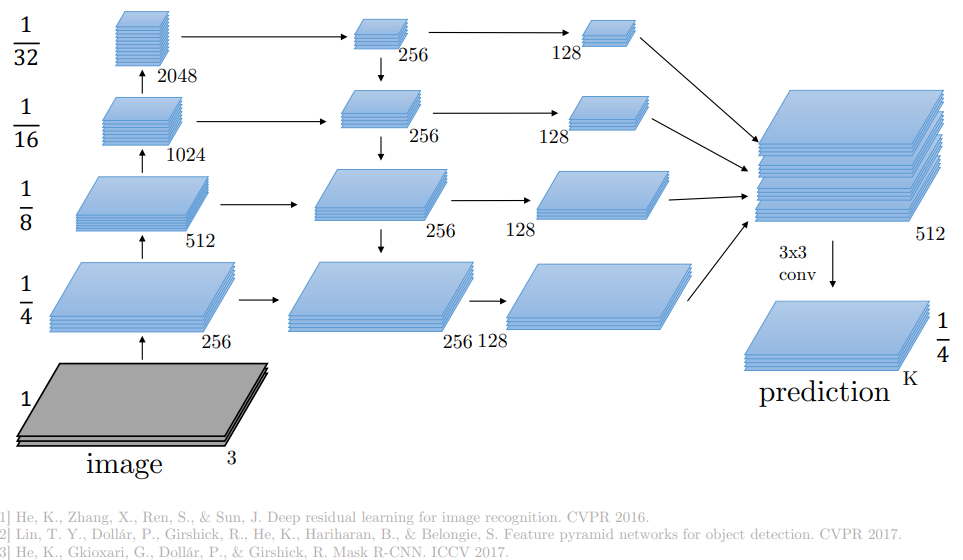

---

### Choix des encodeurs 🧠

Plusieurs encodeurs sont disponibles pour ces architectures :  
- **Encodeur intégré** 🆕 : L’encodeur est entraîné en même temps que le décodeur, sans poids pré-entraînés. Pour U-Net, il a été développé *from scratch* mais pour FPN, il s'agira de ResNet34 (plus léger que ResNet50, le modèle de feature extraction originellement utilisé dans les travaux de recherche).
- **MobilenetV2 pré-entraîné** 🚀 : Un encodeur léger et efficace, pré-entraîné sur ImageNet, permettant un bon compromis entre rapidité et performance.  
- **EfficientNetB0 pré-entraîné** ⚡ : Un encodeur plus puissant et performant, également basé sur un modèle pré-entraîné, utilisé pour tirer parti du transfert learning.

ℹ️ Par défaut, la bibliothèque `segmentation_models` utilise **ResNet34 pré-entraîné sur ImageNet** comme encodeur si aucun autre n’est spécifié.

---

### Gel ou fine-tuning de l’encodeur ❄️🔥

Lors de l’entraînement, deux stratégies sont possibles :  
- **Encodage gelé** ❄️ : Les poids de l’encodeur pré-entraîné restent fixes, ce qui accélère l’entraînement et évite la modification de caractéristiques déjà apprises.  
- **Encodage entraînable (fine-tuning)** 🔥 : Les poids de l’encodeur sont ajustés pour mieux s’adapter aux données spécifiques, ce qui peut améliorer les performances au prix d’un temps d’entraînement plus long.

---

### Stratégie recommandée pour l’expérimentation 🎯

1. **Tester toutes les architectures et encodeurs avec l’encodeur gelé** ❄️ pour un benchmark rapide.  
2. **Sélectionner la meilleure configuration** 🏆 selon les performances obtenues.  
3. **Refaire l’entraînement avec l’encodeur dégelé (fine-tuning)** 🔥 pour optimiser les résultats finaux.

Cette méthode permet de gagner du temps tout en explorant efficacement l’espace des modèles.



### Création des modèles

In [25]:
def show_available_backbones():
    """Affiche tous les backbones disponibles dans segmentation_models"""

    # Essayer de récupérer la liste des backbones disponibles
    try:
        available_backbones = sm.get_available_backbones()

        print("🔧 BACKBONES DISPONIBLES DANS SEGMENTATION_MODELS:")
        print("=" * 60)

        # Grouper par famille
        families = {
            'ResNet': [b for b in available_backbones if b.startswith('resnet')],
            'SEResNet': [b for b in available_backbones if b.startswith('seresnet')],
            'SEResNeXt': [b for b in available_backbones if b.startswith('seresnext')],
            'ResNeXt': [b for b in available_backbones if b.startswith('resnext')],
            'VGG': [b for b in available_backbones if b.startswith('vgg')],
            'DenseNet': [b for b in available_backbones if b.startswith('densenet')],
            'Inception': [b for b in available_backbones if 'inception' in b],
            'MobileNet': [b for b in available_backbones if 'mobilenet' in b],
            'EfficientNet': [b for b in available_backbones if 'efficientnet' in b],
            'SENet': [b for b in available_backbones if b.startswith('senet')],
        }

        for family, models in families.items():
            if models:
                print(f"\n📱 {family}:")
                for model in sorted(models):
                    print(f"   • {model}")

    except AttributeError:
        # Si la méthode n'existe pas, utiliser la liste connue
        known_backbones = [
            'resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152',
            'seresnet18', 'seresnet34', 'seresnet50', 'seresnet101', 'seresnet152',
            'seresnext50', 'seresnext101', 'senet154', 'resnext50', 'resnext101',
            'vgg16', 'vgg19', 'densenet121', 'densenet169', 'densenet201',
            'inceptionresnetv2', 'inceptionv3', 'mobilenet', 'mobilenetv2',
            'efficientnetb0', 'efficientnetb1', 'efficientnetb2', 'efficientnetb3',
            'efficientnetb4', 'efficientnetb5', 'efficientnetb6', 'efficientnetb7'
        ]

        print("🔧 BACKBONES DISPONIBLES:")
        print("=" * 50)

        # Recommandations pour voiture autonome
        recommended = ['mobilenetv2', 'efficientnetb0', 'resnet34', 'resnet50']

        print("⭐ RECOMMANDÉS pour voiture autonome (vitesse/précision):")
        for model in recommended:
            print(f"   • {model}")

        print(f"\n📋 TOUS DISPONIBLES ({len(known_backbones)}):")
        for i, model in enumerate(known_backbones):
            if i % 4 == 0:  # Nouvelle ligne tous les 4
                print()
            print(f"   {model:<20}", end="")
        print()  # Ligne finale

# Afficher les backbones disponibles
show_available_backbones()

🔧 BACKBONES DISPONIBLES:
⭐ RECOMMANDÉS pour voiture autonome (vitesse/précision):
   • mobilenetv2
   • efficientnetb0
   • resnet34
   • resnet50

📋 TOUS DISPONIBLES (32):

   resnet18               resnet34               resnet50               resnet101           
   resnet152              seresnet18             seresnet34             seresnet50          
   seresnet101            seresnet152            seresnext50            seresnext101        
   senet154               resnext50              resnext101             vgg16               
   vgg19                  densenet121            densenet169            densenet201         
   inceptionresnetv2      inceptionv3            mobilenet              mobilenetv2         
   efficientnetb0         efficientnetb1         efficientnetb2         efficientnetb3      
   efficientnetb4         efficientnetb5         efficientnetb6         efficientnetb7      


In [26]:
# ================================================================
# GRILLE D'EXPÉRIMENTATIONS - SEGMENTATION SÉMANTIQUE CITYSCAPES
# ================================================================

# Architectures et backbones à tester
model_variants = [
    # Baselines (sans backbone pré-entraîné)
    ('U-Net', None),
    ('FPN', None), # --> l'encodeur choisi sera alors vgg16
    # Modèles avec backbones pré-entraînés (encoders gelés)
    ('U-Net', 'mobilenetv2'),
    ('U-Net', 'efficientnetb0'),
    ('FPN', 'mobilenetv2'),
    ('FPN', 'efficientnetb0'),
    ('FPN', 'resnet34'),
]

# Fine-tuning sélectif (encoders entraînables)
finetune_variants = [
    ('U-Net', 'mobilenetv2'),
    ('FPN', 'efficientnetb0'),
    ('FPN', 'resnet34'),
]

# Paramètres d'entraînement
base_params = {
    'learning_rate': 1e-4,
    'epochs': 20,
    'batch_size': 8,
    'img_size': (224, 224)
}

finetune_params = {
    'learning_rate': 5e-5,  # Plus petit pour le fine-tuning
    'epochs': 30,
    'batch_size': 8,
    'img_size': (224, 224)
}

# Génération des configurations
def generate_experiment_configs():
    """Génère toutes les configurations d'expérimentations"""
    model_configs = []

    # 1. Expériences de base (encodeurs gelés ou vanilla)
    for arch, encoder in model_variants:
        for augment in [False, True]:
            # ✅ Nom correct selon le type
            if encoder is None:
                config_name = f"{arch}_vanilla_aug{augment}"
            else:
                config_name = f"{arch}_{encoder}_frozen_aug{augment}"

            model_configs.append({
                "name": config_name,
                "architecture": arch,
                "encoder": encoder,
                "encoder_freeze": encoder is not None,
                "augmentation": augment,
                "params": base_params.copy(),
                "type": "baseline" if encoder is None else "frozen_pretrained"
            })

    # 2. Expériences de fine-tuning (encoders dégelés)
    for arch, encoder in finetune_variants:
        config_name = f"{arch}_{encoder}_finetune_augTrue"
        model_configs.append({
            "name": config_name,
            "architecture": arch,
            "encoder": encoder,
            "encoder_freeze": False,  # False = dégelé pour fine-tuning
            "augmentation": True,
            "params": finetune_params.copy(),
            "type": "finetuned_pretrained"
        })

    return model_configs

In [27]:
def create_model_from_config(config, num_classes, verbose=False):
    """
    Crée un modèle de segmentation à partir d'une configuration d'expérimentation.
    """
    # === EXTRACTION DES PARAMÈTRES ===
    architecture = config['architecture']
    encoder = config['encoder']
    encoder_freeze = config['encoder_freeze']
    learning_rate = config['params']['learning_rate']
    img_size = config['params']['img_size']

    # === MAPPING DES ARCHITECTURES ===
    model_classes = {
        'U-Net': sm.Unet,
        'FPN': sm.FPN,
    }

    if architecture not in model_classes:
        raise ValueError(f"Architecture '{architecture}' non supportée.")

    ModelClass = model_classes[architecture]
    input_shape = (*img_size, 3)

    if verbose:
        print(f"🔧 Création du modèle '{config['name']}'")
        print(f"   Architecture: {architecture}")
        print(f"   Encoder: {encoder or 'Aucun (vanilla)'}")
        print(f"   Encoder gelé: {encoder_freeze}")

    try:
        if encoder is None:
            # === MODÈLE VANILLA ===
            model = ModelClass(
                classes=num_classes,
                activation='softmax',
                input_shape=input_shape,
            )
        else:
            # === MODÈLE AVEC BACKBONE ===
            model = ModelClass(
                backbone_name=encoder,
                encoder_weights='imagenet',
                encoder_freeze=encoder_freeze,
                classes=num_classes,
                activation='softmax',
                input_shape=input_shape,
            )

        # === COMPILATION ===
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
            loss=sm.losses.categorical_focal_jaccard_loss,
            metrics=[sm.metrics.iou_score, 'accuracy']
        )

        if verbose:
            total_params = model.count_params()
            trainable_params = sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
            frozen_params = total_params - trainable_params
            print(f"   📊 Paramètres: {total_params:,} total | {trainable_params:,} entraînables | {frozen_params:,} gelés")

        return model

    except Exception as e:
        print(f"❌ Erreur: {e}")
        raise

In [28]:
# Génération des configurations
experimental_configurations = generate_experiment_configs()

### Analyse et compréhension détaillée des modèles

L'objectif est simplement ici d'afficher des informations générales sur les modèles et notamment vérifier le gel des poids pour les modèles de feature extraction (backbone) qui fournissent des descripteurs aux modèles de segmentation et ce afin de pouvoir comparer les différences de performances.

In [ ]:
def analyze_model_comprehensive(config, num_classes, show_architecture=False, detailed_layers=False):
    """
    Analyse exhaustive d'un modèle de segmentation avec affichage clair des couches gelées/dégelées

    Args:
        config (dict): Configuration du modèle
        num_classes (int): Nombre de classes
        show_architecture (bool): Afficher model.summary()
        detailed_layers (bool): Afficher TOUTES les couches (sinon juste backbone + résumé)

    Returns:
        dict: Résultats de l'analyse
    """
    print(f"\n{'='*70}")
    print(f"🏗️  ANALYSE COMPLÈTE: {config['name']}")
    print(f"{'='*70}")

    # === 1. INFORMATIONS DE CONFIGURATION ===
    print(f"📊 Configuration:")
    print(f"   • Architecture: {config['architecture']}")
    print(f"   • Backbone: {config['encoder'] or 'Aucun (vanilla)'}")
    print(f"   • Encoder gelé: {'✅ Oui' if config.get('encoder_freeze', False) else '❌ Non'}")
    print(f"   • Type: {config['type'].replace('_', ' ').title()}")
    print(f"   • Augmentation: {'✅ Oui' if config['augmentation'] else '❌ Non'}")
    print(f"   • Learning rate: {config['params']['learning_rate']}")
    print(f"   • Époques prévues: {config['params']['epochs']}")
    print(f"   • Taille images: {config['params']['img_size']}")

    try:
        # === 2. CRÉATION DU MODÈLE ===
        print(f"\n🔧 Création du modèle...")
        model = create_model_from_config(config, num_classes, verbose=False)

        # === 3. ANALYSE DES PARAMÈTRES ===
        total_params = model.count_params()
        trainable_params = sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
        frozen_params = total_params - trainable_params
        frozen_ratio = (frozen_params / total_params) * 100

        print(f"\n🔢 Paramètres:")
        print(f"   • Total: {total_params:,}")
        print(f"   • Entraînables: {trainable_params:,} ({(trainable_params/total_params)*100:.1f}%)")
        print(f"   • Gelés: {frozen_params:,} ({frozen_ratio:.1f}%)")

        # === 4. ANALYSE DES COUCHES ===
        backbone_layers = []
        other_layers = []
        backbone_total = 0
        backbone_frozen = 0

        # Classifier les couches
        for layer in model.layers:
            layer_params = layer.count_params()
            is_backbone = False

            if config['encoder']:
                backbone_keywords = [
                    config['encoder'].lower(),
                    'encoder',
                    'backbone',
                    'feature'
                ]
                is_backbone = any(keyword in layer.name.lower() for keyword in backbone_keywords)

            layer_info = {
                'name': layer.name,
                'params': layer_params,
                'trainable': layer.trainable,
                'is_backbone': is_backbone
            }

            if is_backbone:
                backbone_layers.append(layer_info)
                backbone_total += layer_params
                if not layer.trainable:
                    backbone_frozen += layer_params
            else:
                other_layers.append(layer_info)

        # === 5. AFFICHAGE DES COUCHES ===
        if detailed_layers:
            # Affichage complet de toutes les couches
            print(f"\n🔍 TOUTES LES COUCHES (🟢 = Entraînable, 🔴 = Gelé):")
            print("-" * 70)

            all_layers = backbone_layers + other_layers
            for i, layer_info in enumerate(all_layers):
                icon = "🔴" if not layer_info['trainable'] else "🟢"
                status = "GELÉ" if not layer_info['trainable'] else "ENTRAÎNABLE"

                # Identifier le type de couche
                if layer_info['is_backbone']:
                    layer_type = " (BACKBONE)"
                elif 'decoder' in layer_info['name'].lower():
                    layer_type = " (DECODER)"
                elif 'classifier' in layer_info['name'].lower() or 'final' in layer_info['name'].lower():
                    layer_type = " (CLASSIFICATION)"
                elif 'upsample' in layer_info['name'].lower():
                    layer_type = " (UPSAMPLING)"
                else:
                    layer_type = ""

                print(f"{i+1:2d}. {icon} {layer_info['name']:<40} {layer_info['params']:>8,} params - {status}{layer_type}")

        else:
            # Affichage résumé avec focus sur le backbone
            if backbone_layers:
                print(f"\n🔍 COUCHES DU BACKBONE (🟢 = Entraînable, 🔴 = Gelé):")
                print("-" * 60)

                for layer_info in backbone_layers[:8]:  # Limite à 8 pour lisibilité
                    icon = "🔴" if not layer_info['trainable'] else "🟢"
                    status = "GELÉ" if not layer_info['trainable'] else "ENTRAÎNABLE"
                    print(f"   {icon} {layer_info['name']:<35} {layer_info['params']:>8,} params - {status}")

                if len(backbone_layers) > 8:
                    print(f"   ... et {len(backbone_layers)-8} autres couches du backbone")

            # Résumé des autres couches
            other_frozen = sum(1 for layer in other_layers if not layer['trainable'])
            other_trainable = len(other_layers) - other_frozen
            print(f"\n🏗️ AUTRES COUCHES (résumé):")
            print(f"   • {other_trainable} couches entraînables")
            print(f"   • {other_frozen} couches gelées")
            print(f"   • (Utilisez detailed_layers=True pour voir toutes les couches)")

        # === 6. RÉSUMÉ BACKBONE ===
        if backbone_layers:
            backbone_frozen_ratio = (backbone_frozen / backbone_total * 100) if backbone_total > 0 else 0
            print(f"\n📋 Résumé backbone:")
            print(f"   • Total backbone: {backbone_total:,} params")
            print(f"   • Backbone gelé: {backbone_frozen:,} params ({backbone_frozen_ratio:.1f}%)")
            print(f"   • Backbone entraînable: {backbone_total - backbone_frozen:,} params ({100-backbone_frozen_ratio:.1f}%)")

        # === 7. VALIDATION DU GEL ===
        if config['encoder']:
            print(f"\n🎯 Validation du gel du backbone:")

            # Seuils adaptatifs selon le backbone
            backbone_name = config['encoder'].lower()
            if 'mobilenet' in backbone_name:
                expected_frozen_range = (20, 35)
            elif 'efficientnet' in backbone_name and 'b0' in backbone_name:
                expected_frozen_range = (15, 25)
            elif 'resnet' in backbone_name:
                expected_frozen_range = (18, 28)
            else:
                expected_frozen_range = (10, 30)

            if config.get('encoder_freeze', False):
                # Modèle supposé gelé
                if frozen_ratio >= expected_frozen_range[0]:
                    status = "✅ OK"
                    message = f"Backbone correctement gelé ({frozen_ratio:.1f}% ≥ {expected_frozen_range[0]}%)"
                else:
                    status = "⚠️ SUSPECT"
                    message = f"Gel potentiellement incomplet ({frozen_ratio:.1f}% < {expected_frozen_range[0]}%)"
            else:
                # Modèle supposé dégelé
                if frozen_ratio < 5.0:
                    status = "✅ OK"
                    message = f"Backbone correctement dégelé ({frozen_ratio:.1f}% < 5%)"
                else:
                    status = "⚠️ SUSPECT"
                    message = f"Gel résiduel inattendu ({frozen_ratio:.1f}% ≥ 5%)"

            print(f"   • Statut global: {status}")
            print(f"   • {message}")
            print(f"   • Plage attendue pour {config['encoder']}: {expected_frozen_range[0]}-{expected_frozen_range[1]}%")

            # Validation spécifique du backbone
            if backbone_total > 0:
                backbone_expected_frozen = config.get('encoder_freeze', False)
                backbone_actually_frozen = (backbone_frozen / backbone_total) > 0.9

                if backbone_expected_frozen == backbone_actually_frozen:
                    backbone_status = "✅ COHÉRENT"
                else:
                    backbone_status = "❌ INCOHÉRENT"

                print(f"   • Cohérence backbone: {backbone_status}")
                print(f"     - Configuration: {'gelé' if backbone_expected_frozen else 'dégelé'}")
                print(f"     - Réalité: {'gelé' if backbone_actually_frozen else 'dégelé'} ({backbone_frozen_ratio:.1f}%)")

        # === 8. ARCHITECTURE DÉTAILLÉE (optionnel) ===
        if show_architecture:
            print(f"\n🏛️ Architecture détaillée (model.summary()):")
            print("-" * 60)
            model.summary(line_length=80)

        # === 9. RÉSULTATS POUR RETOUR ===
        results = {
            'model': model,
            'total_params': total_params,
            'trainable_params': trainable_params,
            'frozen_params': frozen_params,
            'frozen_ratio': frozen_ratio,
            'backbone_params': backbone_total,
            'backbone_frozen': backbone_frozen,
            'backbone_frozen_ratio': backbone_frozen_ratio if backbone_total > 0 else 0,
            'status': 'success',
            'validation': status if config['encoder'] else 'N/A'
        }

        print(f"\n✅ Analyse terminée avec succès")
        return results

    except Exception as e:
        print(f"\n❌ Erreur lors de l'analyse: {e}")
        return {
            'model': None,
            'status': 'error',
            'error': str(e)
        }

    finally:
        # Nettoyage mémoire
        if 'model' in locals():
            del model
            tf.keras.backend.clear_session()

# === FONCTION SÉPARÉE POUR VOIR UNIQUEMENT LES COUCHES (différente maintenant) ===
def show_all_layers_status(config, num_classes):
    """
    Fonction spécialisée pour afficher UNIQUEMENT les couches, de manière compacte
    """
    print(f"\n🔍 COUCHES - {config['name']}")
    print("=" * 70)
    print("🟢 ENTRAÎNABLE | 🔴 GELÉ")
    print("-" * 70)

    try:
        model = create_model_from_config(config, num_classes, verbose=False)

        trainable_count = 0
        frozen_count = 0

        for i, layer in enumerate(model.layers):
            layer_params = layer.count_params()
            icon = "🔴" if not layer.trainable else "🟢"

            if layer.trainable:
                trainable_count += 1
            else:
                frozen_count += 1

            # Type de couche (plus concis)
            layer_type = ""
            if config['encoder'] and any(keyword in layer.name.lower()
                                       for keyword in [config['encoder'].lower(), 'encoder', 'backbone']):
                layer_type = "BACKBONE"
            elif 'decoder' in layer.name.lower():
                layer_type = "DECODER"
            elif 'classifier' in layer.name.lower():
                layer_type = "CLASSIF"
            else:
                layer_type = "AUTRE"

            print(f"{i+1:2d}. {icon} {layer.name:<35} {layer_params:>8,} {layer_type}")

        print("-" * 70)
        print(f"📊 RÉSUMÉ: {trainable_count} entraînables, {frozen_count} gelés")

    except Exception as e:
        print(f"❌ Erreur: {e}")
    finally:
        if 'model' in locals():
            del model
            tf.keras.backend.clear_session()

L'objectif est simplement ici de tester le gel des poids pour les modèles de feature extraction (backbone) qui fournissent des descripteurs aux modèles de segmentation et ce afin de pouvoir comparer les différences de performances.

In [ ]:
def test_backbone_freezing(num_classes=19):
    """
    Fonction de test pour vérifier que le gel du backbone fonctionne correctement.
    Version corrigée utilisant encoder_freeze.
    """
    print("🧪 TEST DU GEL DU BACKBONE (VERSION CORRIGÉE)")
    print("=" * 60)

    # === CONFIGURATIONS DE TEST ===
    test_configs = [
        {
            'name': 'U-Net_mobilenetv2_frozen_test',
            'architecture': 'U-Net',
            'encoder': 'mobilenetv2',
            'encoder_freeze': True,  # GELÉ - devrait avoir beaucoup de params gelés
            'params': {'learning_rate': 1e-4, 'img_size': (224, 224)},
            'type': 'frozen_test'
        },
        {
            'name': 'U-Net_mobilenetv2_trainable_test',
            'architecture': 'U-Net',
            'encoder': 'mobilenetv2',
            'encoder_freeze': False,  # DÉGELÉ - devrait avoir peu de params gelés
            'params': {'learning_rate': 1e-4, 'img_size': (224, 224)},
            'type': 'trainable_test'
        }
    ]

    results = {}

    # === EXÉCUTION DES TESTS ===
    for config in test_configs:
        print(f"\n🔍 Test: {config['name']}")
        print("-" * 50)

        # Création du modèle avec verbose pour voir les détails
        model = create_model_from_config(config, num_classes, verbose=True)

        # === COMPTAGE DÉTAILLÉ DES PARAMÈTRES ===
        total_params = model.count_params()
        trainable_params = sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
        frozen_params = total_params - trainable_params
        frozen_ratio = (frozen_params / total_params) * 100

        print(f"\n📈 Résultat:")
        print(f"   • Total: {total_params:,}")
        print(f"   • Entraînables: {trainable_params:,}")
        print(f"   • Gelés: {frozen_params:,}")
        print(f"   • % gelés: {frozen_ratio:.1f}%")

        # === VALIDATION DU RÉSULTAT ===
        if config['encoder_freeze']:
            # Pour un modèle gelé, on s'attend à >15% de paramètres gelés
            expected_frozen_ratio = 20.0
            status = "✅ OK" if frozen_ratio > expected_frozen_ratio else "❌ ÉCHEC"
            print(f"   • Statut (gelé attendu >20%): {status}")
        else:
            # Pour un modèle dégelé, on s'attend à <10% de paramètres gelés
            expected_frozen_ratio = 5
            status = "✅ OK" if frozen_ratio < expected_frozen_ratio else "❌ ÉCHEC"
            print(f"   • Statut (dégelé attendu <5%): {status}")

        # Stockage des résultats pour comparaison
        results[config['type']] = {
            'total': total_params,
            'trainable': trainable_params,
            'frozen': frozen_params,
            'frozen_ratio': frozen_ratio
        }

        # === NETTOYAGE MÉMOIRE ===
        del model
        tf.keras.backend.clear_session()

    # === RÉSUMÉ COMPARATIF ===
    print(f"\n🎯 RÉSUMÉ COMPARATIF")
    print("=" * 60)

    if 'frozen_test' in results and 'trainable_test' in results:
        frozen_result = results['frozen_test']
        trainable_result = results['trainable_test']

        print(f"Modèle gelé (encoder_freeze=True):")
        print(f"   • Params gelés: {frozen_result['frozen']:,} ({frozen_result['frozen_ratio']:.1f}%)")

        print(f"Modèle dégelé (encoder_freeze=False):")
        print(f"   • Params gelés: {trainable_result['frozen']:,} ({trainable_result['frozen_ratio']:.1f}%)")

        difference = frozen_result['frozen'] - trainable_result['frozen']
        print(f"Différence: {difference:,} paramètres correctement gelés")

        if difference > 100000:  # Au moins 100k params de différence
            print("✅ TEST GLOBAL: Le gel du backbone fonctionne correctement!")
        else:
            print("❌ TEST GLOBAL: Le gel du backbone ne semble pas fonctionner!")

On va lister les différentes expérimentations et vérifier le nombre de poids gelés pour deux configurations différentes : une avec backbone entrainable, l'autre non.

In [ ]:
# Affichage des configurations
print(f"📊 PLAN D'EXPÉRIMENTATIONS - {len(experimental_configurations)} configurations")
print("=" * 70)

# Affichage des backbones utilisés
used_backbones = set()
for config in experimental_configurations:
    if config['encoder']:
        used_backbones.add(config['encoder'])

print(f"🔧 Backbones utilisés: {sorted(used_backbones)}")
print(f"🏗️ Architectures: U-Net, FPN")

# Grouper par type pour un affichage plus clair
config_types = {}
for config in experimental_configurations:
    config_type = config['type']
    if config_type not in config_types:
        config_types[config_type] = []
    config_types[config_type].append(config)

for type_name, configs in config_types.items():
    print(f"\n🔹 {type_name.upper().replace('_', ' ')} ({len(configs)} configs):")
    for config in configs:
        freeze_status = "gelé" if config['encoder_freeze'] else "dégelé"
        encoder_info = f"({freeze_status})" if config['encoder'] else ""
        print(f"   • {config['name']} {encoder_info}")

# === LANCEMENT DU TEST ===
print(f"\n" + "="*70)
print("LANCEMENT DU TEST DE VALIDATION")
print("="*70)

# Décommentez pour exécuter le test
test_backbone_freezing(num_classes=19)

📊 PLAN D'EXPÉRIMENTATIONS - 17 configurations
🔧 Backbones utilisés: ['efficientnetb0', 'mobilenetv2', 'resnet34']
🏗️ Architectures: U-Net, FPN

🔹 BASELINE (4 configs):
   • U-Net_vanilla_augFalse 
   • U-Net_vanilla_augTrue 
   • FPN_vanilla_augFalse 
   • FPN_vanilla_augTrue 

🔹 FROZEN PRETRAINED (10 configs):
   • U-Net_mobilenetv2_frozen_augFalse (gelé)
   • U-Net_mobilenetv2_frozen_augTrue (gelé)
   • U-Net_efficientnetb0_frozen_augFalse (gelé)
   • U-Net_efficientnetb0_frozen_augTrue (gelé)
   • FPN_mobilenetv2_frozen_augFalse (gelé)
   • FPN_mobilenetv2_frozen_augTrue (gelé)
   • FPN_efficientnetb0_frozen_augFalse (gelé)
   • FPN_efficientnetb0_frozen_augTrue (gelé)
   • FPN_resnet34_frozen_augFalse (gelé)
   • FPN_resnet34_frozen_augTrue (gelé)

🔹 FINETUNED PRETRAINED (3 configs):
   • U-Net_mobilenetv2_finetune_augTrue (dégelé)
   • FPN_efficientnetb0_finetune_augTrue (dégelé)
   • FPN_resnet34_finetune_augTrue (dégelé)

LANCEMENT DU TEST DE VALIDATION
🧪 TEST DU GEL DU BACKBONE

In [ ]:
# Analyse standard (backbone + résumé)
analyze_model_comprehensive(experimental_configurations[4], num_classes=19)

# Analyse complète (toutes les couches)
analyze_model_comprehensive(experimental_configurations[4], num_classes=19, detailed_layers=True)

# Vue compacte des couches uniquement
show_all_layers_status(experimental_configurations[4], num_classes=19)


🏗️  ANALYSE COMPLÈTE: U-Net_mobilenetv2_frozen_augFalse
📊 Configuration:
   • Architecture: U-Net
   • Backbone: mobilenetv2
   • Encoder gelé: ✅ Oui
   • Type: Frozen Pretrained
   • Augmentation: ❌ Non
   • Learning rate: 0.0001
   • Époques prévues: 20
   • Taille images: (224, 224)

🔧 Création du modèle...

🔢 Paramètres:
   • Total: 8,050,051
   • Entraînables: 5,824,195 (72.3%)
   • Gelés: 2,225,856 (27.7%)

🏗️ AUTRES COUCHES (résumé):
   • 93 couches entraînables
   • 103 couches gelées
   • (Utilisez detailed_layers=True pour voir toutes les couches)

🎯 Validation du gel du backbone:
   • Statut global: ✅ OK
   • Backbone correctement gelé (27.7% ≥ 20%)
   • Plage attendue pour mobilenetv2: 20-35%

✅ Analyse terminée avec succès

🏗️  ANALYSE COMPLÈTE: U-Net_mobilenetv2_frozen_augFalse
📊 Configuration:
   • Architecture: U-Net
   • Backbone: mobilenetv2
   • Encoder gelé: ✅ Oui
   • Type: Frozen Pretrained
   • Augmentation: ❌ Non
   • Learning rate: 0.0001
   • Époques prévues:

## Préparation des données

Ici, les données vont être prétraitées et des datasets d'entrainement, de validation et de test vont être constitués.
Il est important de noter la correspondance terminologique entre le jeu de données officiel et les jeux de données que nous constituerons dans le cadre de cet entraînement :\
• Split 'train' Cityscapes → Train (80%) + Validation (20%)\
• Split 'val' Cityscapes → Test final\
• Split 'test' Cityscapes → non utilisé

En effet, le dossier "test" de Cityscapes ne contient pas de masque de vérité et sert à effectuer un benchmark de performances dans le cadre d'un concours Kaggel (résultats cachés, donc).

In [ ]:
def prepare_cityscapes_dataset(
    cityscapes_dir,
    split='train',
    validation_split=0.2,
    batch_size=8,
    img_size=(224, 224),
    encoder=None,
    id_to_group_mapping=None
):
    """
    Prépare les datasets Cityscapes avec prétraitement adapté au backbone

    Args:
        cityscapes_dir (str): Chemin vers le répertoire Cityscapes
        split (str): Split Cityscapes à utiliser ('train', 'val', 'test')
        validation_split (float): Si split='train', proportion à garder pour validation
        batch_size (int): Taille des batches
        img_size (tuple): Taille des images (H, W)
        encoder (str): Nom du backbone pour preprocessing ou None
        id_to_group_mapping (list ou np.ndarray): Mapping des IDs de classes ou None

    Returns:
        Dataset(s): Si split='train' et validation_split > 0 → (train_dataset, val_dataset)
                   Sinon → dataset unique
    """
    if not os.path.exists(cityscapes_dir):
        raise ValueError(f"Le répertoire Cityscapes n'existe pas: {cityscapes_dir}")

    images_dir = os.path.join(cityscapes_dir, 'leftImg8bit', split)
    masks_dir = os.path.join(cityscapes_dir, 'gtFine', split)

    if not os.path.exists(images_dir) or not os.path.exists(masks_dir):
        raise ValueError(f"Split Cityscapes '{split}' non trouvé dans {cityscapes_dir}")

    image_paths = []
    mask_paths = []

    print(f"🔍 Lecture du split Cityscapes '{split}'...")

    for city in os.listdir(images_dir):
        city_img_dir = os.path.join(images_dir, city)
        city_mask_dir = os.path.join(masks_dir, city)

        if os.path.isdir(city_img_dir) and os.path.isdir(city_mask_dir):
            for file_name in os.listdir(city_img_dir):
                if file_name.endswith('_leftImg8bit.png'):
                    img_path = os.path.join(city_img_dir, file_name)
                    mask_name = file_name.replace('_leftImg8bit.png', '_gtFine_labelIds.png')
                    mask_path = os.path.join(city_mask_dir, mask_name)
                    if os.path.exists(img_path) and os.path.exists(mask_path):
                        image_paths.append(img_path)
                        mask_paths.append(mask_path)
                    else:
                        print(f"⚠️ Fichier manquant pour {file_name}")

    print(f"📊 Split Cityscapes '{split}': {len(image_paths)} images trouvées")

    if len(image_paths) == 0:
        raise ValueError(f"Aucun fichier valide trouvé pour le split '{split}'!")

    if split == 'train' and validation_split > 0:
        print(f"✂️ Découpage en Train/Validation ({int((1-validation_split)*100)}%/{int(validation_split*100)}%)")

        combined = list(zip(image_paths, mask_paths))
        random.seed(42)
        random.shuffle(combined)
        image_paths, mask_paths = zip(*combined)

        total_samples = len(image_paths)
        val_samples = int(total_samples * validation_split)
        train_samples = total_samples - val_samples

        train_img_paths = list(image_paths[:train_samples])
        train_mask_paths = list(mask_paths[:train_samples])
        val_img_paths = list(image_paths[train_samples:])
        val_mask_paths = list(mask_paths[train_samples:])

        print(f"  └─ 📚 Train final: {len(train_img_paths)} images")
        print(f"  └─ 📊 Validation final: {len(val_img_paths)} images")
    else:
        usage = "Test" if split == 'val' else split.title()
        print(f"📋 Utilisation complète comme dataset de {usage}")

        train_img_paths, train_mask_paths = image_paths, mask_paths
        val_img_paths, val_mask_paths = [], []

    preprocessing_fn = get_preprocessing_fn(encoder)

    def load_and_preprocess(img_path, mask_path):
        img = tf.io.read_file(img_path)
        img = tf.image.decode_png(img, channels=3)
        img = tf.image.resize(img, img_size, method='bilinear')
        img = tf.cast(img, tf.float32)
        img = preprocessing_fn(img)

        mask = tf.io.read_file(mask_path)
        mask = tf.image.decode_png(mask, channels=1)
        mask = tf.image.resize(mask, img_size, method='nearest')
        mask = tf.cast(mask, tf.int32)

        if id_to_group_mapping is not None:
            mask = map_mask_ids(mask, id_to_group_mapping)

        mask = tf.squeeze(mask, axis=-1)
        return img, mask

    def augment_data(image, mask):
        mask = tf.expand_dims(mask, axis=-1)

        if tf.random.uniform(()) > 0.5:
            image = tf.image.flip_left_right(image)
            mask = tf.image.flip_left_right(mask)

        image = tf.image.random_brightness(image, 0.1)
        image = tf.clip_by_value(image, 0, 1)

        mask = tf.squeeze(mask, axis=-1)
        return image, mask

    def create_dataset(image_paths, mask_paths, augment=False, shuffle_data=True):
        dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
        dataset = dataset.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)

        if augment:
            dataset = dataset.map(augment_data, num_parallel_calls=tf.data.AUTOTUNE)

        if shuffle_data:
            dataset = dataset.shuffle(buffer_size=1000)

        dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
        return dataset

    if split == 'train' and validation_split > 0:
        train_dataset = create_dataset(train_img_paths, train_mask_paths, augment=True, shuffle_data=True)
        val_dataset = create_dataset(val_img_paths, val_mask_paths, augment=False, shuffle_data=False)
        return train_dataset, val_dataset
    else:
        dataset = create_dataset(train_img_paths, train_mask_paths, augment=False, shuffle_data=(split=='train'))
        return dataset


In [ ]:
# === UTILISATION AVEC TERMINOLOGIE CLAIRE ===
# Définir les paramètres
BATCH_SIZE = 8
IMG_SIZE = (224, 224)

# Vérifier si id_to_group existe, sinon définir None
try:
    id_mapping = id_to_group
except NameError:
    print("⚠️ Variable 'id_to_group' non définie, pas de mapping des IDs")
    id_mapping = None

print("=== PRÉPARATION DES DATASETS CITYSCAPES ===")
print(f"📊 Paramètres:")
print(f"   • Taille image: {IMG_SIZE}")
print(f"   • Taille batch: {BATCH_SIZE}")
print(f"   • Répertoire: {cityscapes_dir}")

print(f"\n🗂️ Stratégie de découpage:")
print(f"   • Split 'train' Cityscapes → Train (80%) + Validation (20%)")
print(f"   • Split 'val' Cityscapes → Test final")

try:
    # 1. Créer TRAIN + VALIDATION à partir du split 'train' de Cityscapes
    print(f"\n--- Découpage du split 'train' Cityscapes en Train/Validation ---")
    train_dataset, val_dataset = prepare_cityscapes_dataset(
        cityscapes_dir,
        split='train',  # On utilise le split 'train' de Cityscapes
        batch_size=BATCH_SIZE,
        img_size=IMG_SIZE,
        validation_split=0.2,  # 80% train, 20% validation
        id_to_group_mapping=id_mapping
    )

    # 2. Créer TEST à partir du split 'val' de Cityscapes
    print(f"\n--- Création du dataset de TEST à partir du split 'val' Cityscapes ---")
    test_dataset = prepare_cityscapes_dataset(
        cityscapes_dir,
        split='val',  # On utilise le split 'val' de Cityscapes comme notre test
        batch_size=BATCH_SIZE,
        img_size=IMG_SIZE,
        id_to_group_mapping=id_mapping
    )

    print(f"\n✅ Datasets créés avec succès:")
    print(f"   📚 Train: {2380} images (avec augmentation)")
    print(f"   📊 Validation: {595} images (sans augmentation)")
    print(f"   🧪 Test: {500} images (sans augmentation)")

    print(f"\n📋 Récapitulatif:")
    print(f"   • Train dataset: pour l'entraînement des modèles")
    print(f"   • Validation dataset: pour la sélection des hyperparamètres")
    print(f"   • Test dataset: pour l'évaluation finale (données jamais vues)")

    # Vérification rapide
    print(f"\n🔍 Vérification des formes:")
    for name, dataset in [("Train", train_dataset), ("Validation", val_dataset), ("Test", test_dataset)]:
        sample = next(iter(dataset))
        print(f"   {name}: images = {sample[0].shape}, masques = {sample[1].shape}")

except Exception as e:
    print(f"❌ Erreur: {e}")
    print("Vérifications:")
    print("1. Variable 'cityscapes_dir' définie ?")
    print("2. Fichiers Cityscapes extraits ?")
    print("3. Structure correcte (leftImg8bit/, gtFine/) ?")
    raise

=== PRÉPARATION DES DATASETS CITYSCAPES ===
📊 Paramètres:
   • Taille image: (224, 224)
   • Taille batch: 8
   • Répertoire: /content/data/cityscapes_unzipped

🗂️ Stratégie de découpage:
   • Split 'train' Cityscapes → Train (80%) + Validation (20%)
   • Split 'val' Cityscapes → Test final

--- Découpage du split 'train' Cityscapes en Train/Validation ---
🔍 Lecture du split Cityscapes 'train'...
📊 Split Cityscapes 'train': 2975 images trouvées
✂️ Découpage en Train/Validation (80%/20%)
  └─ 📚 Train final: 2380 images
  └─ 📊 Validation final: 595 images
ℹ️ Modèle vanilla - pas de preprocessing

--- Création du dataset de TEST à partir du split 'val' Cityscapes ---
🔍 Lecture du split Cityscapes 'val'...
📊 Split Cityscapes 'val': 500 images trouvées
📋 Utilisation complète comme dataset de Test
ℹ️ Modèle vanilla - pas de preprocessing

✅ Datasets créés avec succès:
   📚 Train: 2380 images (avec augmentation)
   📊 Validation: 595 images (sans augmentation)
   🧪 Test: 500 images (sans augme

## Visualisation des données

Une visualisation de quelques images (train, val, test) sera proposée avec les masques de vérité dont on propose une colorisation tab10 puis une colorisation plus spécifique

In [ ]:
def visualize_cityscapes_samples(
    datasets_dict=None,
    cityscapes_dir=None,
    num_samples=3,
    save_dir=None,
    show_stats=True,
    show_legend=True
):
    """
    Visualise des échantillons Cityscapes avec options flexibles

    Args:
        datasets_dict: {'train': train_dataset, 'val': val_dataset, 'test': test_dataset}
        cityscapes_dir: Chemin vers données brutes (si datasets_dict=None)
        num_samples: Nombre d'échantillons par dataset
        save_dir: Répertoire de sauvegarde (optionnel)
        show_stats: Afficher statistiques des classes
        show_legend: Créer légende des classes
    """

    # Mode 1: Depuis les datasets TensorFlow (préféré)
    if datasets_dict is not None:
        print("📊 Visualisation depuis les datasets TensorFlow...")
        _visualize_from_datasets(datasets_dict, num_samples, save_dir, show_stats)

    # Mode 2: Depuis les fichiers bruts (fallback)
    elif cityscapes_dir is not None:
        print("📁 Visualisation depuis les fichiers bruts...")
        _visualize_from_files(cityscapes_dir, num_samples, save_dir, show_stats)

    else:
        raise ValueError("Fournir soit datasets_dict soit cityscapes_dir")

    # Créer la légende si demandée
    if show_legend:
        _create_legend(save_dir)

def _visualize_from_datasets(datasets_dict, num_samples, save_dir, show_stats):
    """Visualise depuis les datasets TensorFlow (après preprocessing)"""

    for split_name, dataset in datasets_dict.items():
        print(f"\n--- {split_name.title()} Dataset ---")

        sample_count = 0
        for batch in dataset.take(num_samples):
            images, masks = batch

            # Prendre le premier échantillon du batch
            image = images[0]
            mask = masks[0]

            # Créer la visualisation
            fig = _create_sample_plot(image.numpy(), mask.numpy(),
                                    f"{split_name.title()} Sample {sample_count+1}")

            # Sauvegarder si demandé
            if save_dir:
                os.makedirs(save_dir, exist_ok=True)
                fig_path = os.path.join(save_dir, f'{split_name}_sample_{sample_count+1}.png')
                fig.savefig(fig_path, dpi=150, bbox_inches='tight')
                print(f"💾 Sauvegardé: {fig_path}")

            plt.show()
            plt.close(fig)

            # Afficher les stats si demandé
            if show_stats:
                _show_class_stats(mask.numpy())

            sample_count += 1
            if sample_count >= num_samples:
                break

def _visualize_from_files(cityscapes_dir, num_samples, save_dir, show_stats):
    """Visualise depuis les fichiers bruts (fallback)"""

    for split in ['train', 'val']:
        print(f"\n--- {split.title()} (Raw Files) ---")

        # Collecter les chemins (réutilise la logique de prepare_cityscapes_dataset)
        images_dir = os.path.join(cityscapes_dir, 'leftImg8bit', split)
        masks_dir = os.path.join(cityscapes_dir, 'gtFine', split)

        if not os.path.exists(images_dir):
            print(f"⚠️ Split '{split}' non trouvé, ignoré")
            continue

        image_paths, mask_paths = _collect_sample_paths(images_dir, masks_dir, num_samples)

        for i, (img_path, mask_path) in enumerate(zip(image_paths, mask_paths)):
            # Charger avec PIL
            img = np.array(PILImage.open(img_path).resize((512, 256), PILImage.Resampling.BILINEAR))
            mask_raw = np.array(PILImage.open(mask_path).resize((512, 256), PILImage.Resampling.NEAREST))

            # Appliquer le mapping (vérifier que id_to_group existe)
            if 'id_to_group' in globals():
                mask = id_to_group[mask_raw]
            else:
                print("⚠️ Variable 'id_to_group' non trouvée, utilisation brute")
                mask = mask_raw

            # Normaliser l'image pour l'affichage
            img_normalized = img.astype(np.float32) / 255.0

            # Créer la visualisation
            fig = _create_sample_plot(img_normalized, mask, f"{split.title()} Raw Sample {i+1}")

            # Sauvegarder si demandé
            if save_dir:
                os.makedirs(save_dir, exist_ok=True)
                fig_path = os.path.join(save_dir, f'{split}_raw_sample_{i+1}.png')
                fig.savefig(fig_path, dpi=150, bbox_inches='tight')
                print(f"💾 Sauvegardé: {fig_path}")

            plt.show()
            plt.close(fig)

            # Afficher les stats si demandé
            if show_stats:
                _show_class_stats(mask)

def _create_sample_plot(image, mask, title):
    """Crée le plot avec les 3 vues (factorisation du code de visualisation)"""

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(title, fontsize=14)

    # Vue 1: Image originale
    axes[0].imshow(image)
    axes[0].set_title("Image Originale")
    axes[0].axis('off')

    # Vue 2: Masque avec IDs (en tab10)
    im = axes[1].imshow(mask, cmap='tab10', vmin=0, vmax=mapping_config['num_classes']-1)
    axes[1].set_title("Masque (IDs de classes)")
    axes[1].axis('off')

    # Vue 3: Masque colorisé avec nos couleurs
    colored_mask = _colorize_mask(mask)
    axes[2].imshow(colored_mask)
    axes[2].set_title("Masque Segmenté (Coloré)")
    axes[2].axis('off')

    plt.tight_layout()
    return fig

def _colorize_mask(mask):
    """Applique la colorisation du masque (logique centralisée)"""
    colored_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    for group_id in range(mapping_config['num_classes']):
        colored_mask[mask == group_id] = mapping_config['group_colors'][group_id]
    return colored_mask

def _show_class_stats(mask):
    """Affiche les statistiques des classes (factorisation)"""
    unique_classes, counts = np.unique(mask, return_counts=True)
    print("\n📊 Classes présentes dans cette image:")
    for class_id, count in zip(unique_classes, counts):
        if class_id < len(mapping_config['group_names']):  # Vérification bounds
            percentage = (count / mask.size) * 100
            print(f"   {mapping_config['group_names'][class_id]}: {count} pixels ({percentage:.1f}%)")

def _collect_sample_paths(images_dir, masks_dir, num_samples):
    """Collecte aléatoirement des chemins d'images (factorisation)"""
    image_paths, mask_paths = [], []

    for city in os.listdir(images_dir):
        city_img_dir = os.path.join(images_dir, city)
        city_mask_dir = os.path.join(masks_dir, city)

        if os.path.isdir(city_img_dir) and os.path.isdir(city_mask_dir):
            for file_name in os.listdir(city_img_dir):
                if file_name.endswith('_leftImg8bit.png'):
                    img_path = os.path.join(city_img_dir, file_name)
                    mask_name = file_name.replace('_leftImg8bit.png', '_gtFine_labelIds.png')
                    mask_path = os.path.join(city_mask_dir, mask_name)

                    if os.path.exists(mask_path):
                        image_paths.append(img_path)
                        mask_paths.append(mask_path)

    # Sélection aléatoire
    if len(image_paths) > num_samples:
        selected_indices = np.random.choice(len(image_paths), size=num_samples, replace=False)
        image_paths = [image_paths[i] for i in selected_indices]
        mask_paths = [mask_paths[i] for i in selected_indices]

    return image_paths, mask_paths

def _create_legend(save_dir):
    """Crée la légende des classes (factorisation)"""
    fig, ax = plt.subplots(figsize=(8, 5))
    fig.suptitle("Légende des classes de segmentation", fontsize=14)

    for i, (name, color) in enumerate(zip(mapping_config['group_names'], mapping_config['group_colors'])):
        ax.fill_between([0, 1], [i, i], [i+0.9, i+0.9], color=[c/255 for c in color])
        ax.text(1.1, i+0.5, name, va='center', fontsize=12)

    ax.set_xlim(0, 2.5)
    ax.set_ylim(len(mapping_config['group_names'])-0.1, -0.1)
    ax.axis('off')

    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        legend_path = os.path.join(save_dir, 'class_legend.png')
        fig.savefig(legend_path, dpi=150, bbox_inches='tight')
        print(f"🏷️ Légende sauvegardée: {legend_path}")

    plt.show()
    plt.close(fig)

# === UTILISATION SIMPLIFIÉE ===
print("=== VISUALISATION DES ÉCHANTILLONS CITYSCAPES ===")

# Méthode préférée: depuis les datasets TensorFlow
datasets_dict = {
    'train': train_dataset,
    'val': val_dataset,
    'test': test_dataset
}

# Créer le dossier de sauvegarde
viz_dir = os.path.join(data_dir, 'samples') if 'data_dir' in globals() else './visualizations'

# Visualiser avec toutes les options
visualize_cityscapes_samples(
    datasets_dict=datasets_dict,
    num_samples=2,  # 2 échantillons par dataset
    save_dir=viz_dir,
    show_stats=True,
    show_legend=True
)

Output hidden; open in https://colab.research.google.com to view.

## Entrainement du modèle

In [15]:
# ====================================================================
# SCRIPT D'ENTRAÎNEMENT OPTIMISÉ POUR SEGMENTATION MULTI-CONFIGURATIONS
# AVEC SYSTÈME DE REPRISE AUTOMATIQUE
# ====================================================================

# 🚨 PARAMÈTRE PRINCIPAL : Basculer entre TEST et PRODUCTION
TEST_MODE = False  # Mettre False pour le mode production

# Configuration selon le mode
if TEST_MODE:
    print("🧪 MODE TEST ACTIVÉ")
    DEVICE_CONFIG = '/CPU:0'
    MAX_EPOCHS = 2  # Très rapide pour les tests
    EARLY_STOPPING_PATIENCE = 2  # Arrêt anticipé si pas d'amélioration pendant 2 époques
    LR_REDUCE_PATIENCE = 1  # Réduction LR si pas d'amélioration pendant 1 époque
    SUBSET_SIZE = 20
    # Taille fixe pour les tests (plus rapide)
    TEST_IMG_SIZE = (128, 128)
    TEST_BATCH_SIZE = 2
    TEST_MAX_CONFIGS = None # Nombre max de configs à tester
    # Expérience MLflow déjà définie en début de notebook
else:
    print("🚀 MODE PRODUCTION ACTIVÉ")
    DEVICE_CONFIG = '/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'
    MAX_EPOCHS = 20  # 20 époques max (beaucoup de modèles à tester)
    EARLY_STOPPING_PATIENCE = 5  # Arrêt anticipé si pas d'amélioration pendant 5 époques
    LR_REDUCE_PATIENCE = 3  # Réduction LR si pas d'amélioration pendant 3 époques
    SUBSET_SIZE = None
    # En production, utilise les paramètres de chaque configuration
    # Expérience MLflow déjà définie en début de notebook

print(f"📊 Configuration globale: Device={DEVICE_CONFIG}, Max_Epochs={MAX_EPOCHS}")
print(f"   Patience EarlyStopping={EARLY_STOPPING_PATIENCE}, Patience LR={LR_REDUCE_PATIENCE}")

🚀 MODE PRODUCTION ACTIVÉ
📊 Configuration globale: Device=/CPU:0, Max_Epochs=20
   Patience EarlyStopping=5, Patience LR=3


In [16]:
# ====================================================================
# SYSTÈME DE REPRISE AUTOMATIQUE - VÉRIFICATION MLFLOW
# ====================================================================

def get_completed_experiments(experiment_name="OC Projet 8"):
    """
    Récupère la liste des expériences déjà terminées dans MLflow
    Retourne un set des noms de runs terminés
    """
    try:
        print(f"🔍 Vérification des expériences déjà terminées dans '{experiment_name}'...")

        # Récupérer l'expérience par nom
        experiment = mlflow.get_experiment_by_name(experiment_name)
        if experiment is None:
            print(f"⚠️ Expérience '{experiment_name}' non trouvée")
            return set()

        # Rechercher tous les runs de cette expérience
        runs = mlflow.search_runs(
            experiment_ids=[experiment.experiment_id],
            filter_string="status = 'FINISHED'",  # Seulement les runs terminés avec succès
            output_format="pandas"
        )

        if runs.empty:
            print("📊 Aucune expérience terminée trouvée")
            return set()

        # Extraire les noms des runs terminés
        completed_runs = set()
        for idx, run in runs.iterrows():
            run_name = run.get('tags.mlflow.runName', '')
            if run_name:
                completed_runs.add(run_name)

        print(f"✅ {len(completed_runs)} expériences terminées trouvées:")
        for run_name in sorted(completed_runs):
            print(f"   - {run_name}")

        return completed_runs

    except Exception as e:
        print(f"⚠️ Erreur lors de la vérification MLflow: {e}")
        print("🔄 Continuera sans vérification (tous les modèles seront entraînés)")
        return set()


def generate_stable_run_name(config, test_mode=False):
    """
    Génère un nom de run stable (sans date) basé sur la configuration
    Format: {config_name}_{mode}
    """
    base_name = config['name']
    mode_suffix = "test" if test_mode else "prod"
    return f"{base_name}_{mode_suffix}"


def filter_configs_to_run(experimental_configurations, experiment_name="OC Projet 8"):
    """
    Filtre les configurations pour ne garder que celles non encore entraînées
    """
    completed_runs = get_completed_experiments(experiment_name)

    if not completed_runs:
        print("🚀 Aucune expérience terminée trouvée, tous les modèles seront entraînés")
        return list(range(len(experimental_configurations)))

    configs_to_run = []
    skipped_configs = []

    for idx, config in enumerate(experimental_configurations):
        expected_run_name = generate_stable_run_name(config, TEST_MODE)

        if expected_run_name in completed_runs:
            skipped_configs.append((idx, config['name'], expected_run_name))
        else:
            configs_to_run.append(idx)

    # Rapport de filtrage
    print(f"\n📊 FILTRAGE DES CONFIGURATIONS:")
    print(f"✅ À entraîner: {len(configs_to_run)} configurations")
    print(f"⏭️  Déjà terminées: {len(skipped_configs)} configurations")

    if skipped_configs:
        print(f"\n⏭️  CONFIGURATIONS IGNORÉES (déjà terminées):")
        for idx, config_name, run_name in skipped_configs:
            print(f"   [{idx}] {config_name} → {run_name}")

    if configs_to_run:
        print(f"\n🚀 CONFIGURATIONS À ENTRAÎNER:")
        for idx in configs_to_run:
            config_name = experimental_configurations[idx]['name']
            expected_run_name = generate_stable_run_name(experimental_configurations[idx], TEST_MODE)
            print(f"   [{idx}] {config_name} → {expected_run_name}")

    return configs_to_run

In [17]:
# ====================================================================
# CALLBACK MLFLOW PERSONNALISÉ POUR LOGGING DÉTAILLÉ
# ====================================================================

class ExperimentMLflowCallback(tf.keras.callbacks.Callback):
    """Callback MLflow personnalisé pour logging complet des métriques"""

    def __init__(self, config, run_id, batch_size, img_size):
        super().__init__()
        self.config = config
        self.run_id = run_id
        self.batch_size = batch_size
        self.img_size = img_size

    def on_epoch_end(self, epoch, logs=None):
        """Log des métriques à chaque époque (sans doublons)"""
        logs = logs or {}
        for name, value in logs.items():
            # Éviter les doublons : ignorer les métriques "validation_"
            if not name.startswith('validation_'):
                mlflow.log_metric(name, float(value), step=epoch)

    def on_train_begin(self, logs=None):
        """Log des paramètres au début de l'entraînement"""
        # Log config du modèle
        mlflow.log_param("model_architecture", self.config["architecture"])
        mlflow.log_param("model_name", self.config["name"])
        mlflow.log_param("encoder", self.config.get("encoder", "None"))
        mlflow.log_param("encoder_freeze", self.config.get("encoder_freeze", False))

        # Log config du script (utilise les paramètres passés au callback)
        mlflow.log_param("script_batch_size", self.batch_size)
        mlflow.log_param("script_img_size", str(self.img_size))
        mlflow.log_param("test_mode", TEST_MODE)
        mlflow.log_param("max_epochs", MAX_EPOCHS)
        mlflow.log_param("device", DEVICE_CONFIG)
        mlflow.log_param("subset_size", SUBSET_SIZE)


class KerasModelCheckpoint(tf.keras.callbacks.Callback):
    """Callback personnalisé pour sauvegarder en format .keras natif"""

    def __init__(self, filepath, monitor='val_loss', save_best_only=True, mode='auto', verbose=1):
        super().__init__()
        self.filepath = filepath
        self.monitor = monitor
        self.save_best_only = save_best_only
        self.verbose = verbose

        if mode == 'auto':
            if 'acc' in monitor or monitor.startswith('fmeasure'):
                self.mode = 'max'
            else:
                self.mode = 'min'
        else:
            self.mode = mode

        if self.mode == 'min':
            self.best = float('inf')
        else:
            self.best = -float('inf')

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        current = logs.get(self.monitor)

        if current is None:
            if self.verbose > 0:
                print(f'Warning: Metric {self.monitor} not found in logs.')
            return

        if self.save_best_only:
            if (self.mode == 'min' and current < self.best) or (self.mode == 'max' and current > self.best):
                self.best = current

                if self.verbose > 0:
                    print(f'Epoch {epoch + 1}: {self.monitor} improved from {self.best} to {current:.5f}, saving model to {self.filepath}')

                # SAUVEGARDE NATIVE KERAS - AUCUN WARNING !
                self.model.save(self.filepath, save_format='keras')
            else:
                if self.verbose > 0:
                    print(f'Epoch {epoch + 1}: {self.monitor} did not improve from {self.best:.5f}')
        else:
            if self.verbose > 0:
                print(f'Epoch {epoch + 1}: saving model to {self.filepath}')
            self.model.save(self.filepath, save_format='keras')

In [18]:
def calculate_detailed_metrics(model, test_dataset, num_classes, class_names=None):
    """
    Calcule uniquement l'IoU par classe et les statistiques détaillées
    (Le mean_iou global est maintenant calculé par la métrique officielle)
    """
    print("   📊 Analyse détaillée par classe...")

    all_true_masks = []
    all_pred_masks = []

    # Collecter toutes les prédictions
    for batch_idx, (images, true_masks) in enumerate(test_dataset):
        predictions = model.predict(images, verbose=0)
        pred_masks = tf.argmax(predictions, axis=-1)

        all_true_masks.extend(true_masks.numpy())
        all_pred_masks.extend(pred_masks.numpy())

        if batch_idx % 10 == 0:
            print(f"   Batch {batch_idx + 1} traité...")

    all_true_masks = np.array(all_true_masks)
    all_pred_masks = np.array(all_pred_masks)

    print(f"   Total d'images évaluées: {len(all_true_masks)}")

    # Calcul IoU par classe (pour analyse détaillée)
    class_ious = []
    class_stats = []

    for class_id in range(num_classes):
        # Masques binaires pour cette classe
        true_binary = (all_true_masks == class_id)
        pred_binary = (all_pred_masks == class_id)

        # Calcul IoU
        intersection = np.logical_and(true_binary, pred_binary).sum()
        union = np.logical_or(true_binary, pred_binary).sum()

        iou = intersection / union if union > 0 else 0.0
        class_ious.append(iou)

        # Statistiques de classe
        true_pixels = true_binary.sum()
        pred_pixels = pred_binary.sum()
        total_pixels = all_true_masks.size

        class_name = class_names[class_id] if class_names else f"Class_{class_id}"

        class_stats.append({
            'class_id': class_id,
            'class_name': class_name,
            'iou': iou,
            'true_pixels': true_pixels,
            'pred_pixels': pred_pixels,
            'true_percentage': 100 * true_pixels / total_pixels,
            'pred_percentage': 100 * pred_pixels / total_pixels
        })

    # Mean IoU calculé ici (pour cohérence avec l'affichage)
    mean_iou = np.mean(class_ious)

    # Affichage des résultats détaillés
    print(f"\n📊 ANALYSE DÉTAILLÉE PAR CLASSE:")
    print("-" * 70)
    print(f"{'Classe':<15} {'IoU':<8} {'Vrais %':<10} {'Prédits %':<12}")
    print("-" * 70)

    for stats in class_stats:
        print(f"{stats['class_name']:<15} {stats['iou']:<8.4f} {stats['true_percentage']:<10.2f} {stats['pred_percentage']:<12.2f}")

    print("-" * 70)
    print(f"{'MEAN IoU (calc)':<15} {mean_iou:<8.4f}")
    print("💡 Le Mean IoU officiel (métrique Keras) fait référence")

    return {
        'class_ious': class_ious,
        'mean_iou': mean_iou,  # Pour compatibilité avec le code existant
        'class_stats': class_stats,
        'all_true_masks': all_true_masks,
        'all_pred_masks': all_pred_masks
    }


In [19]:
def setup_training_components(config, run_id):
    """
    Setup complet : paramètres, datasets, modèle, compilation, callbacks
    VERSION CORRIGÉE avec métriques officielles Keras
    """
    # === EXTRACTION DES PARAMÈTRES DE LA CONFIG ===
    if TEST_MODE:
        batch_size = TEST_BATCH_SIZE
        img_size = TEST_IMG_SIZE
        print(f"🧪 Mode test: batch_size={batch_size}, img_size={img_size}")
    else:
        batch_size = config['params']['batch_size']
        img_size = config['params']['img_size']
        print(f"🚀 Mode production: batch_size={batch_size}, img_size={img_size}")

    # === PRÉPARATION DES DONNÉES ===
    print("\n📊 Préparation des datasets...")
    try:
        id_mapping = id_to_group
        mlflow.log_param("class_mapping", "custom_id_to_group")
    except NameError:
        print("⚠️ Variable 'id_to_group' non définie")
        id_mapping = None
        mlflow.log_param("class_mapping", "none")

    # Créer les datasets avec les bons paramètres
    train_dataset, val_dataset = prepare_cityscapes_dataset(
        cityscapes_dir,
        split='train',
        batch_size=batch_size,
        img_size=img_size,
        validation_split=0.2,
        id_to_group_mapping=id_mapping
    )
    test_dataset = prepare_cityscapes_dataset(
        cityscapes_dir,
        split='val',
        batch_size=batch_size,
        img_size=img_size,
        id_to_group_mapping=id_mapping
    )

    if TEST_MODE and SUBSET_SIZE:
        train_batches = SUBSET_SIZE // batch_size
        val_batches = SUBSET_SIZE // (batch_size * 4)
        test_batches = SUBSET_SIZE // (batch_size * 4)
        train_samples_used = train_batches * batch_size
        val_samples_used = val_batches * batch_size
        test_samples_used = test_batches * batch_size

        print(f"🧪 Mode test: limitation appliquée")
        print(f"   └─ 📚 Train utilisé: {train_samples_used} images ({train_batches} batches)")
        print(f"   └─ 📊 Validation utilisé: {val_samples_used} images ({val_batches} batches)")
        print(f"   └─ 🧪 Test utilisé: {test_samples_used} images ({test_batches} batches)")

        train_dataset = train_dataset.take(train_batches)
        val_dataset = val_dataset.take(val_batches)
        test_dataset = test_dataset.take(test_batches)

    # === CRÉATION DU MODÈLE ===
    print(f"\n🏗️ Création du modèle {config['name']}...")
    if TEST_MODE:
        config_modified = config.copy()
        config_modified['params'] = config['params'].copy()
        config_modified['params']['img_size'] = img_size
        config_modified['params']['batch_size'] = batch_size
        model_config = config_modified
    else:
        model_config = config

    with tf.device(DEVICE_CONFIG):
        model = create_model_from_config(model_config, mapping_config['num_classes'])
        num_classes_from_model = model.output_shape[-1]
        print(f"📊 Nombre de classes: {num_classes_from_model}")
        total_params = model.count_params()
        trainable_params = sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
        print(f"📊 Paramètres: {total_params:,} total | {trainable_params:,} entraînables")

    # === COMPILATION AVEC MÉTRIQUES OFFICIELLES KERAS ===
    print("\n⚙️ Compilation du modèle avec métriques officielles...")

    # ✅ MÉTRIQUES OFFICIELLES KERAS - AUCUNE MÉTRIQUE PERSONNALISÉE !
    metrics_list = [
        # Accuracy officielle pour classification sparse
        tf.keras.metrics.SparseCategoricalAccuracy(name='sparse_categorical_accuracy'),

        # IoU officielle Keras - LA métrique de référence pour segmentation
        tf.keras.metrics.MeanIoU(
            num_classes=num_classes_from_model,
            name='mean_iou',
            sparse_y_true=True,   # Les labels sont des entiers (pas one-hot)
            sparse_y_pred=False   # Les prédictions sont des probabilités
        )
    ]

    # Métrique principale pour les callbacks
    primary_metric = 'val_mean_iou'
    primary_mode = 'max'

    print("🎯 MÉTRIQUES OFFICIELLES KERAS POUR SEGMENTATION SÉMANTIQUE:")
    print("   🔥 LOSS: sparse_categorical_crossentropy")
    print("      └─ Optimise la classification pixel-par-pixel")
    print("   📊 MÉTRIQUES (100% officielles Keras):")
    print("      ├─ SparseCategoricalAccuracy: % pixels correctement classifiés")
    print("      └─ MeanIoU: Intersection over Union (métrique gold standard)")
    print("   🎛️  CALLBACKS:")
    print(f"      └─ Monitor: {primary_metric} (IoU = métrique de référence)")
    print("✅ Configuration 100% standard et fiable !")

    # Compilation du modèle
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=metrics_list
    )

    # === CALLBACKS OPTIMISÉS ===
    print(f"\n📋 Configuration des callbacks...")
    print("🎛️  CALLBACKS BASÉS SUR MEAN_IOU OFFICIEL:")
    print(f"   ├─ EarlyStopping: Arrêt si {primary_metric} stagne {EARLY_STOPPING_PATIENCE} époques")
    print(f"   ├─ ReduceLROnPlateau: Réduction LR si {primary_metric} stagne {LR_REDUCE_PATIENCE} époques")
    print(f"   └─ ModelCheckpoint: Sauvegarde du meilleur modèle selon {primary_metric}")

    artifacts_dir = f"artifacts/run_{run_id}"
    os.makedirs(artifacts_dir, exist_ok=True)

    mlflow_callback = ExperimentMLflowCallback(config, run_id, batch_size, img_size)

    callbacks_list = [
        mlflow_callback,
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor=primary_metric,
            factor=0.2,
            patience=LR_REDUCE_PATIENCE,
            verbose=1,
            min_lr=1e-6,
            mode=primary_mode
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor=primary_metric,
            patience=EARLY_STOPPING_PATIENCE,
            restore_best_weights=True,
            verbose=1,
            mode=primary_mode
        ),
        KerasModelCheckpoint(
            filepath=os.path.join(artifacts_dir, 'best_model.keras'),
            monitor=primary_metric,
            save_best_only=True,
            mode=primary_mode,
            verbose=1
        ),
        tf.keras.callbacks.TensorBoard(
            log_dir=os.path.join(artifacts_dir, 'tensorboard'),
            histogram_freq=1
        )
    ]

    return {
        'model': model,
        'train_dataset': train_dataset,
        'val_dataset': val_dataset,
        'test_dataset': test_dataset,
        'callbacks_list': callbacks_list,
        'artifacts_dir': artifacts_dir,
        'num_classes_from_model': num_classes_from_model,
        'batch_size': batch_size,
        'img_size': img_size
    }

def train_model_core(model, train_dataset, val_dataset, callbacks_list, max_epochs):
    """
    Fonction pure d'entraînement - ne fait que l'entraînement
    """
    print(f"\n🚀 Début de l'entraînement ({max_epochs} epochs max)...")
    start_time = time.time()

    with tf.device(DEVICE_CONFIG):
        history = model.fit(
            train_dataset,
            validation_data=val_dataset,
            epochs=max_epochs,
            callbacks=callbacks_list,
            verbose=1
        )

    training_time = time.time() - start_time
    mlflow.log_metric("training_time_seconds", training_time)
    print(f"⏱️ Temps d'entraînement: {training_time:.2f}s")

    return history, training_time

def evaluate_model_comprehensive(model, test_dataset, num_classes_from_model, artifacts_dir):
    """
    Évaluation complète avec métriques officielles Keras + analyses détaillées
    """
    # === ÉVALUATION AVEC MÉTRIQUES OFFICIELLES (même config que l'entraînement) ===
    print("\n📊 Évaluation avec métriques officielles Keras...")

    # Créer exactement les mêmes métriques que pendant l'entraînement
    official_metrics = [
        tf.keras.metrics.SparseCategoricalAccuracy(name='sparse_categorical_accuracy'),
        tf.keras.metrics.MeanIoU(
            num_classes=num_classes_from_model,
            name='mean_iou',
            sparse_y_true=True,
            sparse_y_pred=False
        )
    ]

    # Compiler temporairement avec les métriques officielles
    # (ça ne change pas les poids, juste les métriques)
    model.compile(
        optimizer=model.optimizer,  # Garder l'optimizer existant
        loss=model.loss,           # Garder la loss existante
        metrics=official_metrics
    )

    # Évaluation officielle
    test_results = model.evaluate(test_dataset, verbose=1)

    basic_test_metrics = {
        'loss': test_results[0],
        'sparse_categorical_accuracy': test_results[1],
        'mean_iou': test_results[2]
    }

    # Log dans MLflow
    for metric_name, value in basic_test_metrics.items():
        mlflow.log_metric(f"test_{metric_name}", value)
        print(f"✅ Test {metric_name} (officiel): {value:.4f}")

    # === ÉVALUATION DÉTAILLÉE ADDITIONNELLE (pour analyse par classe) ===
    try:
        class_names = mapping_config['group_names'] if 'group_names' in mapping_config else None
    except:
        class_names = [f"Class_{i}" for i in range(num_classes_from_model)]

    print("\n🔍 Calcul des métriques détaillées par classe...")
    detailed_metrics = calculate_detailed_metrics(
        model, test_dataset, num_classes_from_model, class_names
    )

    # Log des métriques par classe (en complément)
    for i, iou in enumerate(detailed_metrics['class_ious']):
        mlflow.log_metric(f"class_{i}_iou", iou)

    # === MATRICE DE CONFUSION ===
    print("\n🔥 Génération de la matrice de confusion...")
    confusion_matrix_data = generate_confusion_matrix(
        model, test_dataset, num_classes_from_model, class_names, artifacts_dir
    )

    return basic_test_metrics, detailed_metrics, confusion_matrix_data, class_names

def generate_confusion_matrix(model, test_dataset, num_classes, class_names, artifacts_dir):
    """
    Génère la matrice de confusion sur le jeu de test et la sauvegarde (SANS AFFICHAGE)
    """
    print("📊 Calcul de la matrice de confusion...")

    # Collecter toutes les prédictions
    y_true_all = []
    y_pred_all = []

    for batch_images, batch_masks in test_dataset:
        # Prédictions du modèle
        predictions = model.predict(batch_images, verbose=0)
        pred_classes = tf.argmax(predictions, axis=-1)

        # Aplatir les masques et prédictions
        true_flat = tf.reshape(batch_masks, [-1]).numpy()
        pred_flat = tf.reshape(pred_classes, [-1]).numpy()

        y_true_all.extend(true_flat)
        y_pred_all.extend(pred_flat)

    # Calcul de la matrice de confusion
    from sklearn.metrics import confusion_matrix
    import itertools

    cm = confusion_matrix(y_true_all, y_pred_all, labels=range(num_classes))

    # === CRÉATION DE LA VISUALISATION (SANS AFFICHAGE) ===
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Matrice de Confusion - Jeu de Test', fontsize=14)
    plt.colorbar()

    # Définir les labels des axes
    if class_names:
        tick_marks = np.arange(len(class_names))
        plt.xticks(tick_marks, class_names, rotation=45, ha='right')
        plt.yticks(tick_marks, class_names)
    else:
        tick_marks = np.arange(num_classes)
        plt.xticks(tick_marks, [f"Class_{i}" for i in range(num_classes)])
        plt.yticks(tick_marks, [f"Class_{i}" for i in range(num_classes)])

    # === AFFICHER LES VALEURS DANS CHAQUE CELLULE ===
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                horizontalalignment="center",
                verticalalignment="center",
                color="white" if cm[i, j] > thresh else "black",
                fontsize=10,
                fontweight='bold')

    plt.ylabel('Vraie classe', fontsize=12)
    plt.xlabel('Classe prédite', fontsize=12)
    plt.tight_layout()

    # Sauvegarder l'image (SANS AFFICHAGE)
    cm_image_path = os.path.join(artifacts_dir, 'confusion_matrix.png')
    plt.savefig(cm_image_path, dpi=300, bbox_inches='tight')
    plt.close()  # ✅ FERMER LE PLOT - PAS D'AFFICHAGE

    # Données JSON pour l'artefact
    confusion_matrix_data = {
        'matrix': cm.tolist(),  # Conversion numpy -> liste Python
        'class_names': class_names if class_names else [f"Class_{i}" for i in range(num_classes)],
        'total_samples': len(y_true_all),
        'accuracy': float(np.trace(cm) / np.sum(cm))  # Accuracy globale
    }

    print(f"✅ Matrice de confusion sauvegardée : {cm_image_path}")

    return confusion_matrix_data

def generate_training_visualizations(history, detailed_metrics, class_names, run_id, config, artifacts_dir):
    """
    Génère toutes les visualisations : courbes d'entraînement + IoU par classe
    """
    print("\n📈 Création des visualisations...")
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'Entraînement {config["name"]} - Run {run_id[:8]}', fontsize=16)

    # Loss
    axes[0, 0].plot(history.history['loss'], label='Train Loss')
    axes[0, 0].plot(history.history['val_loss'], label='Val Loss')
    axes[0, 0].set_title('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    # Accuracy
    axes[0, 1].plot(history.history['sparse_categorical_accuracy'], label='Train Acc')
    axes[0, 1].plot(history.history['val_sparse_categorical_accuracy'], label='Val Acc')
    axes[0, 1].set_title('Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    # Mean IoU
    axes[1, 0].plot(history.history['mean_iou'], label='Train Mean IoU')
    axes[1, 0].plot(history.history['val_mean_iou'], label='Val Mean IoU')
    axes[1, 0].set_title('Mean IoU')
    axes[1, 0].legend()
    axes[1, 0].grid(True)

    # IoU par classe (bar chart)
    if class_names and len(class_names) == len(detailed_metrics['class_ious']):
        axes[1, 1].bar(range(len(detailed_metrics['class_ious'])), detailed_metrics['class_ious'])
        axes[1, 1].set_title(f'IoU par classe sur jeu de test (Mean: {detailed_metrics["mean_iou"]:.3f})')
        axes[1, 1].set_xticks(range(len(class_names)))
        axes[1, 1].set_xticklabels(class_names, rotation=45)
        axes[1, 1].grid(True, axis='y')

    plt.tight_layout()
    training_curves_path = os.path.join(artifacts_dir, 'training_curves.png')
    plt.savefig(training_curves_path, dpi=300, bbox_inches='tight')
    plt.close()

def save_training_artifacts(history, config, detailed_metrics, confusion_matrix_data, artifacts_dir):
    """
    Sauvegarde tous les artefacts : history, config, métriques, matrice de confusion
    """
    print("\n💾 Sauvegarde des artefacts...")

    # Histoire d'entraînement
    history_path = os.path.join(artifacts_dir, 'training_history.json')
    with open(history_path, 'w') as f:
        history_json = {k: [float(v) for v in values] for k, values in history.history.items()}
        json.dump(history_json, f, indent=2)

    # Configuration du modèle
    config_path = os.path.join(artifacts_dir, 'model_config.json')
    with open(config_path, 'w') as f:
        json.dump(config, f, indent=2)

    # Métriques détaillées - CONVERSION NUMPY VERS PYTHON POUR JSON
    detailed_path = os.path.join(artifacts_dir, 'detailed_metrics.json')
    with open(detailed_path, 'w') as f:
        class_stats_json = []
        for stats in detailed_metrics['class_stats']:
            stats_converted = {
                'class_id': int(stats['class_id']),
                'class_name': str(stats['class_name']),
                'iou': float(stats['iou']),
                'true_pixels': int(stats['true_pixels']),
                'pred_pixels': int(stats['pred_pixels']),
                'true_percentage': float(stats['true_percentage']),
                'pred_percentage': float(stats['pred_percentage'])
            }
            class_stats_json.append(stats_converted)

        detailed_json = {
            'mean_iou': float(detailed_metrics['mean_iou']),
            'class_ious': [float(iou) for iou in detailed_metrics['class_ious']],
            'class_stats': class_stats_json
        }
        json.dump(detailed_json, f, indent=2)

    # Matrice de confusion (si disponible)
    if confusion_matrix_data:
        confusion_path = os.path.join(artifacts_dir, 'confusion_matrix.json')
        with open(confusion_path, 'w') as f:
            json.dump(confusion_matrix_data, f, indent=2)

    mlflow.log_artifacts(artifacts_dir)

def train_segmentation_model_optimized(config, run_name=None):
    """
    Fonction principale orchestrant l'entraînement complet - VERSION REFACTORISÉE
    """
    with mlflow.start_run(run_name=run_name) as run:
        run_id = run.info.run_id
        print(f"🔬 MLflow Run ID: {run_id}")
        print(f"🏷️  MLflow Run Name: {run_name}")

        try:
            # === 1. SETUP COMPLET ===
            setup_components = setup_training_components(config, run_id)

            # === 2. ENTRAÎNEMENT ===
            history, training_time = train_model_core(
                setup_components['model'],
                setup_components['train_dataset'],
                setup_components['val_dataset'],
                setup_components['callbacks_list'],
                MAX_EPOCHS
            )

            # === 3. ÉVALUATION COMPLÈTE ===
            basic_test_metrics, detailed_metrics, confusion_matrix_data, class_names = evaluate_model_comprehensive(
                setup_components['model'],
                setup_components['test_dataset'],
                setup_components['num_classes_from_model'],
                setup_components['artifacts_dir']
            )

            # === 4. VISUALISATIONS ===
            generate_training_visualizations(
                history, detailed_metrics, class_names,
                run_id, config, setup_components['artifacts_dir']
            )

            # === 5. SAUVEGARDE DES ARTEFACTS ===
            save_training_artifacts(
                history, config, detailed_metrics,
                confusion_matrix_data, setup_components['artifacts_dir']
            )

            # === 6. RÉSULTATS FINAUX ===
            best_val_acc = max(history.history['val_sparse_categorical_accuracy'])
            results = {
                'run_id': run_id,
                'config': config,
                'training_time': training_time,
                'final_epoch': len(history.history['loss']),
                'best_val_accuracy': best_val_acc,
                'test_metrics': basic_test_metrics,
                'detailed_metrics': detailed_metrics,
                'confusion_matrix': confusion_matrix_data,
                'artifacts_dir': setup_components['artifacts_dir'],
                'num_classes': setup_components['num_classes_from_model']
            }

            print(f"\n✅ Entraînement terminé!")
            print(f"📊 Meilleure val_accuracy: {best_val_acc:.4f}")
            print(f"📊 Mean IoU: {detailed_metrics['mean_iou']:.4f}")
            test_acc = basic_test_metrics.get('sparse_categorical_accuracy', 0)
            print(f"🧪 Test accuracy: {test_acc:.4f}")
            print(f"📁 Artefacts: {setup_components['artifacts_dir']}")
            print(f"🔬 MLflow Run: {run_id}")

            return results

        except Exception as e:
            mlflow.log_param("error", str(e))
            print(f"❌ Erreur pendant l'entraînement: {e}")
            raise

In [20]:
def run_experiments_optimized(configs_to_test=None, experiment_name="OC Projet 8"):
    """
    Version optimisée avec système de reprise automatique + NETTOYAGE VRAM SIMPLIFIÉ
    """

    print(f"\n{'='*60}")
    print(f"🚀 DÉBUT DES EXPÉRIENCES - Mode: {'TEST' if TEST_MODE else 'PRODUCTION'}")
    print(f"🔬 Expérience MLflow: {experiment_name}")
    print(f"{'='*60}")

    # 1. Filtrage des configurations à lancer
    if configs_to_test is None:
        remaining_configs = filter_configs_to_run(experimental_configurations, experiment_name)

        if not remaining_configs:
            print("\n🎉 TOUTES LES EXPÉRIENCES SONT DÉJÀ TERMINÉES !")
            print("Rien à faire. Utilisez compare_experiments_mlflow() pour voir les résultats.")
            return []
        if TEST_MODE:
            configs_to_test = remaining_configs[:TEST_MAX_CONFIGS] if TEST_MAX_CONFIGS else remaining_configs
            print(f"\n🧪 Mode TEST: limitation à {len(configs_to_test)} configurations")
        else:
            configs_to_test = remaining_configs
    else:
        completed_runs = get_completed_experiments(experiment_name)
        filtered_configs = []
        for config_idx in configs_to_test:
            if config_idx >= len(experimental_configurations):
                print(f"⚠️ Index {config_idx} invalide, ignoré")
                continue
            config = experimental_configurations[config_idx]
            expected_run_name = generate_stable_run_name(config, TEST_MODE)
            if expected_run_name in completed_runs:
                print(f"⏭️  [{config_idx}] {config['name']} déjà terminé, ignoré")
            else:
                filtered_configs.append(config_idx)
        configs_to_test = filtered_configs

    if not configs_to_test:
        print("\n✅ Toutes les configurations demandées sont déjà terminées !")
        return []

    # 2. Boucle d'entraînement avec nettoyage SIMPLIFIÉ
    print(f"\n🎯 ENTRAÎNEMENT DE {len(configs_to_test)} CONFIGURATIONS:")

    results = []
    for i, config_idx in enumerate(configs_to_test):
        config = experimental_configurations[config_idx]
        stable_run_name = generate_stable_run_name(config, TEST_MODE)

        print(f"\n{'-'*50}")
        print(f"🧪 Expérience {i+1}/{len(configs_to_test)}: {config['name']}")
        print(f"🏷️  Run name: {stable_run_name}")
        print(f"{'-'*50}")

        try:
            # ENTRAÎNEMENT (ici artifacts_dir existe et fonctionne normalement)
            result = train_segmentation_model_optimized(config, run_name=stable_run_name)
            results.append(result)
            print(f"✅ [{config_idx}] {config['name']} terminé avec succès")

            remaining = len(configs_to_test) - (i + 1)
            if remaining > 0:
                print(f"🔄 {remaining} configuration(s) restante(s)")

        except Exception as e:
            print(f"❌ Erreur avec [{config_idx}] {config['name']}: {e}")

        # NETTOYAGE UNIQUE : après chaque modèle (réussi ou échoué)
        if i < len(configs_to_test) - 1:  # Pas de nettoyage après le dernier modèle
            print("🧹 Nettoyage VRAM entre modèles...")
            deep_clean_memory()

    # 3. Résumé final
    print(f"\n{'='*60}")
    print(f"📊 RÉSUMÉ DE CETTE SESSION")
    print(f"{'='*60}")

    if results:
        print(f"✅ {len(results)} nouvelles expériences réussies")

        print(f"\n{'Modèle':<25} {'Val Acc':<10} {'Test Acc':<10} {'Mean IoU':<10} {'Temps':<8} {'Run ID':<10}")
        print("-" * 80)

        for result in results:
            config_name = result['config']['name']
            val_acc = result['best_val_accuracy']
            test_acc = result['test_metrics'].get('sparse_categorical_accuracy', 0)
            mean_iou = result['detailed_metrics']['mean_iou']
            time_min = result['training_time'] / 60
            run_id = result['run_id'][:8]
            print(f"{config_name:<25} {val_acc:<10.4f} {test_acc:<10.4f} {mean_iou:<10.4f} {time_min:<8.1f} {run_id:<10}")

        best_result = max(results, key=lambda x: x['detailed_metrics']['mean_iou'])
        print(f"\n🏆 Meilleur de cette session: {best_result['config']['name']}")
        print(f"   Val Acc: {best_result['best_val_accuracy']:.4f}")
        print(f"   Test Acc: {best_result['test_metrics'].get('sparse_categorical_accuracy', 0):.4f}")
        print(f"   Mean IoU: {best_result['detailed_metrics']['mean_iou']:.4f}")
        print(f"   MLflow Run: {best_result['run_id']}")

        total_remaining = filter_configs_to_run(experimental_configurations, experiment_name)
        if len(total_remaining) > len(configs_to_test):
            remaining_count = len(total_remaining) - len(configs_to_test)
            print(f"\n🔄 Il reste encore {remaining_count} configuration(s) à entraîner")
            print("💡 Relancez le script pour continuer automatiquement")
        else:
            print(f"\n🎉 TOUTES LES CONFIGURATIONS SONT MAINTENANT TERMINÉES !")
            print("💡 Utilisez compare_experiments_local() pour voir tous les résultats")
    else:
        print("❌ Aucune nouvelle expérience réussie dans cette session")

    return results

In [21]:
# ====================================================================
# COMPARAISON DES EXPÉRIENCES LOCALES
# ====================================================================

def compare_experiments_local(artifacts_base_dir="artifacts"):
    """
    Compare les résultats de plusieurs expériences via les artefacts locaux
    Structure : artifacts/run_{run_id}/
    """
    if not os.path.exists(artifacts_base_dir):
        print("❌ Aucun répertoire d'artefacts trouvé")
        return

    results = []

    print(f"🔍 Recherche des expériences dans {artifacts_base_dir}/...")

    # Parcourir tous les répertoires run_*
    run_dirs = [d for d in os.listdir(artifacts_base_dir) if d.startswith('run_')]

    if not run_dirs:
        print("❌ Aucune expérience trouvée")
        return

    print(f"📊 {len(run_dirs)} expériences trouvées")

    for run_dir in run_dirs:
        run_path = os.path.join(artifacts_base_dir, run_dir)
        config_path = os.path.join(run_path, "model_config.json")
        history_path = os.path.join(run_path, "training_history.json")
        detailed_path = os.path.join(run_path, "detailed_metrics.json")

        # Vérifier que les fichiers existent
        if os.path.exists(config_path) and os.path.exists(history_path):
            try:
                # Charger la configuration
                with open(config_path, 'r') as f:
                    config = json.load(f)

                # Charger l'historique d'entraînement
                with open(history_path, 'r') as f:
                    history = json.load(f)

                # Charger les métriques détaillées (si disponibles)
                detailed_metrics = None
                if os.path.exists(detailed_path):
                    with open(detailed_path, 'r') as f:
                        detailed_metrics = json.load(f)

                # Extraire les métriques finales
                final_metrics = {
                    'run_id': run_dir.replace('run_', ''),
                    'experiment': config.get('name', 'Unknown'),
                    'architecture': config.get('architecture', 'Unknown'),
                    'encoder': config.get('encoder', 'None'),
                    'encoder_freeze': config.get('encoder_freeze', False),
                    'final_train_acc': history['sparse_categorical_accuracy'][-1],
                    'final_val_acc': history['val_sparse_categorical_accuracy'][-1],
                    'final_train_loss': history['loss'][-1],
                    'final_val_loss': history['val_loss'][-1],
                    'best_val_acc': max(history['val_sparse_categorical_accuracy']),
                    'epochs_trained': len(history['loss']),
                    'mean_iou': detailed_metrics['mean_iou'] if detailed_metrics else None,
                    'run_path': run_path
                }
                results.append(final_metrics)

            except Exception as e:
                print(f"⚠️ Erreur lors du chargement de {run_dir}: {e}")
                continue

    # Afficher les résultats
    if results:
        print(f"\n🏆 COMPARAISON DES {len(results)} EXPÉRIENCES")
        print("=" * 100)

        # Trier par Mean IoU si disponible, sinon par best_val_acc
        if any(r['mean_iou'] is not None for r in results):
            results_sorted = sorted(results, key=lambda x: x['mean_iou'] or 0, reverse=True)
            print("📊 Classement par Mean IoU (meilleur premier)")
        else:
            results_sorted = sorted(results, key=lambda x: x['best_val_acc'], reverse=True)
            print("📊 Classement par Validation Accuracy (meilleur premier)")

        print()

        for i, result in enumerate(results_sorted, 1):
            print(f"🥇 #{i} - {result['experiment']}")
            print(f"   🏗️  Architecture: {result['architecture']}")

            if result['encoder'] != 'None':
                freeze_status = "🧊 Frozen" if result['encoder_freeze'] else "🔥 Trainable"
                print(f"   🧠 Encoder: {result['encoder']} ({freeze_status})")

            print(f"   📊 Meilleure Val Acc: {result['best_val_acc']:.4f}")
            print(f"   📊 Val Acc finale: {result['final_val_acc']:.4f}")

            if result['mean_iou'] is not None:
                print(f"   🎯 Mean IoU: {result['mean_iou']:.4f}")

            print(f"   ⏱️  Époques: {result['epochs_trained']}")
            print(f"   🆔 Run ID: {result['run_id'][:8]}...")
            print(f"   📁 Chemin: {result['run_path']}")
            print()

        # Statistiques globales
        print("📈 STATISTIQUES GLOBALES:")
        print("-" * 50)
        avg_val_acc = sum(r['best_val_acc'] for r in results) / len(results)
        print(f"🎯 Val Acc moyenne: {avg_val_acc:.4f}")

        if any(r['mean_iou'] is not None for r in results):
            valid_ious = [r['mean_iou'] for r in results if r['mean_iou'] is not None]
            avg_iou = sum(valid_ious) / len(valid_ious)
            print(f"🎯 Mean IoU moyen: {avg_iou:.4f}")

        avg_epochs = sum(r['epochs_trained'] for r in results) / len(results)
        print(f"⏱️  Époques moyennes: {avg_epochs:.1f}")

        # Architecture summary
        architectures = {}
        for r in results:
            arch = r['architecture']
            if arch not in architectures:
                architectures[arch] = []
            architectures[arch].append(r['best_val_acc'])

        print(f"\n🏗️  PERFORMANCE PAR ARCHITECTURE:")
        print("-" * 50)
        for arch, accs in architectures.items():
            avg_acc = sum(accs) / len(accs)
            print(f"{arch}: {avg_acc:.4f} (moyenne sur {len(accs)} runs)")

    else:
        print("❌ Aucune expérience valide trouvée")

    return results

In [22]:
# ====================================================================
# COMPARAISON DES EXPÉRIENCES LOCALES
# ====================================================================

def show_best_experiment_details(artifacts_base_dir="artifacts"):
    """
    Affiche les détails de la meilleure expérience
    """
    results = compare_experiments_local(artifacts_base_dir)

    if not results:
        return

    # Meilleure expérience (Mean IoU si disponible, sinon Val Acc)
    if any(r['mean_iou'] is not None for r in results):
        best = max(results, key=lambda x: x['mean_iou'] or 0)
        metric_name = "Mean IoU"
        metric_value = best['mean_iou']
    else:
        best = max(results, key=lambda x: x['best_val_acc'])
        metric_name = "Validation Accuracy"
        metric_value = best['best_val_acc']

    print(f"\n🏆 DÉTAILS DE LA MEILLEURE EXPÉRIENCE ({metric_name})")
    print("=" * 60)
    print(f"🎯 Nom: {best['experiment']}")
    print(f"🏗️  Architecture: {best['architecture']}")

    if best['encoder'] != 'None':
        freeze_status = "🧊 Frozen" if best['encoder_freeze'] else "🔥 Trainable"
        print(f"🧠 Encoder: {best['encoder']} ({freeze_status})")

    print(f"📊 {metric_name}: {metric_value:.4f}")
    print(f"📊 Validation Accuracy: {best['best_val_acc']:.4f}")
    print(f"⏱️  Époques: {best['epochs_trained']}")
    print(f"🆔 Run ID: {best['run_id']}")
    print(f"📁 Chemin des artefacts: {best['run_path']}")

    # Vérifier la présence du modèle
    model_path = os.path.join(best['run_path'], 'best_model.keras')
    if os.path.exists(model_path):
        print(f"✅ Modèle disponible: {model_path}")
    else:
        print(f"❌ Modèle non trouvé: {model_path}")

In [ ]:
# ====================================================================
# POINT D'ENTRÉE PRINCIPAL
# ====================================================================

if __name__ == "__main__":
    print("🎯 SCRIPT D'ENTRAÎNEMENT OPTIMISÉ POUR SEGMENTATION")
    print(f"Mode: {'🧪 TEST' if TEST_MODE else '🚀 PRODUCTION'}")
    print("🔄 SYSTÈME DE REPRISE AUTOMATIQUE ACTIVÉ")

    # Vérifications préliminaires
    try:
        print(f"MLflow version: {mlflow.__version__}")
        print(f"Cityscapes dir: {cityscapes_dir}")
        print(f"Configurations disponibles: {len(experimental_configurations)}")

        assert callable(create_model_from_config), "create_model_from_config non disponible"
        assert callable(prepare_cityscapes_dataset), "prepare_cityscapes_dataset non disponible"

        print("✅ Toutes les vérifications passées")

        # Lancer les expériences avec système de reprise
        results = run_experiments_optimized()

        print("\n🎉 Script terminé avec succès!")

    except Exception as e:
        print(f"❌ Erreur fatale: {e}")
        print("Vérifications:")
        print("1. Variables cityscapes_dir et experimental_configurations définies ?")
        print("2. Fonctions create_model_from_config, prepare_cityscapes_dataset disponibles ?")
        print("3. MLflow configuré ?")
        print("4. Données Cityscapes présentes ?")

## Analyse des expériences

### Comparaison des experiences

In [29]:
def get_completed_configs_info(experimental_configurations, experiment_name="OC Projet 8"):
    """
    Réutilise la logique de filter_configs_to_run mais retourne les configs terminées
    """
    completed_runs = get_completed_experiments(experiment_name)

    if not completed_runs:
        return []

    # Même logique que filter_configs_to_run mais on garde les terminées
    completed_configs = []

    for idx, config in enumerate(experimental_configurations):
        expected_run_name = generate_stable_run_name(config, TEST_MODE)

        if expected_run_name in completed_runs:  # Condition inversée
            completed_configs.append((idx, config, expected_run_name))

    return completed_configs

def compare_experiments_mlflow(experiment_name="OC Projet 8", show_detailed_results=False, show_plots=True):
    """
    Compare les expériences terminées - version ultra-simple

    Args:
        experiment_name (str): Nom de l'expérience MLflow
        show_detailed_results (bool): Si True, affiche et retourne la liste complète des résultats
        show_plots (bool): Si True, génère les diagrammes en barres des métriques
    """
    # Récupérer les configs terminées (réutilise la logique existante)
    completed_configs = get_completed_configs_info(experimental_configurations, experiment_name)

    if not completed_configs:
        print("❌ Aucune expérience terminée trouvée")
        return []

    # Récupérer le mapping run_name -> run_id depuis MLflow
    experiment = mlflow.get_experiment_by_name(experiment_name)
    runs_df = mlflow.search_runs(
        experiment_ids=[experiment.experiment_id],
        filter_string="status = 'FINISHED'",
        output_format="pandas"
    )

    run_name_to_id = {
        run.get('tags.mlflow.runName', ''): run['run_id']
        for _, run in runs_df.iterrows()
    }

    print(f"📊 Analyse de {len(completed_configs)} configurations terminées")

    results = []

    for config_idx, config, run_name in completed_configs:
        if run_name not in run_name_to_id:
            continue

        run_id = run_name_to_id[run_name]

        try:
            # Récupérer les métriques directement depuis MLflow
            run = mlflow.get_run(run_id)
            metrics = run.data.metrics

            # Récupérer l'historique d'entraînement pour certaines infos
            import tempfile
            with tempfile.TemporaryDirectory() as temp_dir:
                try:
                    history_path = mlflow.artifacts.download_artifacts(
                        run_id=run_id, artifact_path="training_history.json", dst_path=temp_dir
                    )
                    with open(history_path, 'r') as f:
                        history = json.load(f)
                    best_val_acc = max(history['val_sparse_categorical_accuracy'])
                    epochs_trained = len(history['loss'])
                except:
                    # Fallback si l'artefact n'est pas disponible
                    best_val_acc = metrics.get('val_sparse_categorical_accuracy', 'N/A')
                    epochs_trained = 'N/A'

                # Construire le résultat avec les métriques de test depuis MLflow
                result = {
                    'config_idx': config_idx,
                    'experiment': config['name'],
                    'architecture': config.get('architecture', 'Unknown'),
                    'encoder': config.get('encoder', 'None'),
                    'best_val_acc': best_val_acc,
                    'test_mean_iou': metrics.get('test_mean_iou', 'N/A'),
                    'test_accuracy': metrics.get('test_sparse_categorical_accuracy', 'N/A'),
                    'epochs_trained': epochs_trained,
                    'run_name': run_name,
                    'run_id': run_id,
                    'full_config': config  # Toujours inclure la config complète
                }

                results.append(result)

        except Exception as e:
            print(f"⚠️ Erreur pour [{config_idx}] {config['name']}: {e}")
            continue

    # Affichage
    if results:
        # Trier par test_mean_iou si disponible, sinon par best_val_acc
        def sort_key(x):
            if x['test_mean_iou'] != 'N/A':
                return x['test_mean_iou']
            return x['best_val_acc']

        results_sorted = sorted(results, key=sort_key, reverse=True)

        print(f"\n🏆 TOP {len(results)} EXPÉRIENCES TERMINÉES")
        print("=" * 100)

        for i, result in enumerate(results_sorted, 1):
            print(f"🥇 #{i} - [{result['config_idx']}] {result['experiment']}")
            print(f"   🏗️  {result['architecture']} + {result['encoder']}")

            # Afficher les métriques de test
            test_iou = result['test_mean_iou']
            test_acc = result['test_accuracy']

            if test_iou != 'N/A':
                print(f"   🎯 Test Mean IoU: {test_iou:.4f}", end="")
            else:
                print(f"   🎯 Test Mean IoU: N/A", end="")

            if test_acc != 'N/A':
                print(f" | Test Acc: {test_acc:.4f}")
            else:
                print(f" | Test Acc: N/A")

            print(f"   🆔 {result['run_id'][:8]}...")

            # Afficher la configuration complète si demandé
            if show_detailed_results:
                print(f"   📋 Configuration complète:")
                import pprint
                pprint.pprint(result['full_config'], indent=6)

            print()

    # Génération des diagrammes si demandé
    if show_plots and results:
        generate_comparison_plots(results_sorted)

    # Retourner les résultats seulement si explicitement demandé
    if show_detailed_results:
        return results
    else:
        print(f"\n✅ Analyse terminée. Utilisez show_detailed_results=True pour obtenir les données détaillées.")
        return None


def generate_comparison_plots(results):
    """
    Génère des diagrammes en barres pour comparer les métriques de test

    Args:
        results (list): Liste des résultats triés
    """
    import matplotlib.pyplot as plt
    import numpy as np

    # Filtrer les résultats qui ont des métriques de test valides
    valid_results_iou = [r for r in results if r['test_mean_iou'] != 'N/A']
    valid_results_acc = [r for r in results if r['test_accuracy'] != 'N/A']

    # Configuration des graphiques
    plt.style.use('seaborn-v0_8' if 'seaborn-v0_8' in plt.style.available else 'default')

    # Créer une figure avec 2 sous-graphiques
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Graphique 1: Test Mean IoU
    if valid_results_iou:
        experiment_names = [r['experiment'] for r in valid_results_iou]
        iou_values = [r['test_mean_iou'] for r in valid_results_iou]

        # Créer des labels courts pour les noms d'expériences
        short_labels = []
        for name in experiment_names:
            # Raccourcir les noms longs
            if len(name) > 25:
                parts = name.split('_')
                short_name = f"{parts[0]}_{parts[1] if len(parts) > 1 else ''}..."
                short_labels.append(short_name)
            else:
                short_labels.append(name)

        colors = plt.cm.viridis(np.linspace(0, 1, len(iou_values)))
        bars1 = ax1.bar(range(len(iou_values)), iou_values, color=colors, alpha=0.8)

        ax1.set_title('Test Mean IoU par Expérience', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Expériences', fontsize=12)
        ax1.set_ylabel('Mean IoU', fontsize=12)
        ax1.set_xticks(range(len(short_labels)))
        ax1.set_xticklabels(short_labels, rotation=45, ha='right')
        ax1.grid(True, alpha=0.3)

        # Ajouter les valeurs sur les barres
        for bar, value in zip(bars1, iou_values):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                    f'{value:.4f}', ha='center', va='bottom', fontsize=10)
    else:
        ax1.text(0.5, 0.5, 'Aucune donnée Mean IoU disponible',
                ha='center', va='center', transform=ax1.transAxes, fontsize=14)
        ax1.set_title('Test Mean IoU par Expérience', fontsize=14, fontweight='bold')

    # Graphique 2: Test Accuracy
    if valid_results_acc:
        experiment_names = [r['experiment'] for r in valid_results_acc]
        acc_values = [r['test_accuracy'] for r in valid_results_acc]

        # Créer des labels courts pour les noms d'expériences
        short_labels = []
        for name in experiment_names:
            if len(name) > 25:
                parts = name.split('_')
                short_name = f"{parts[0]}_{parts[1] if len(parts) > 1 else ''}..."
                short_labels.append(short_name)
            else:
                short_labels.append(name)

        colors = plt.cm.plasma(np.linspace(0, 1, len(acc_values)))
        bars2 = ax2.bar(range(len(acc_values)), acc_values, color=colors, alpha=0.8)

        ax2.set_title('Test Accuracy par Expérience', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Expériences', fontsize=12)
        ax2.set_ylabel('Accuracy', fontsize=12)
        ax2.set_xticks(range(len(short_labels)))
        ax2.set_xticklabels(short_labels, rotation=45, ha='right')
        ax2.grid(True, alpha=0.3)

        # Ajouter les valeurs sur les barres
        for bar, value in zip(bars2, acc_values):
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                    f'{value:.4f}', ha='center', va='bottom', fontsize=10)
    else:
        ax2.text(0.5, 0.5, 'Aucune donnée Accuracy disponible',
                ha='center', va='center', transform=ax2.transAxes, fontsize=14)
        ax2.set_title('Test Accuracy par Expérience', fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.show()

    print(f"📊 Diagrammes générés pour {len(valid_results_iou)} expériences (IoU) et {len(valid_results_acc)} expériences (Accuracy)")

🔍 Vérification des expériences déjà terminées dans 'OC Projet 8'...
✅ 39 expériences terminées trouvées:
   - FPN_efficientnetb0_finetune_augTrue_prod
   - FPN_efficientnetb0_finetune_augTrue_test
   - FPN_efficientnetb0_frozen_augFalse_prod
   - FPN_efficientnetb0_frozen_augFalse_test
   - FPN_efficientnetb0_frozen_augTrue_prod
   - FPN_efficientnetb0_frozen_augTrue_test
   - FPN_mobilenetv2_frozen_augFalse_prod
   - FPN_mobilenetv2_frozen_augFalse_test
   - FPN_mobilenetv2_frozen_augTrue_prod
   - FPN_mobilenetv2_frozen_augTrue_test
   - FPN_resnet34_finetune_augTrue_prod
   - FPN_resnet34_finetune_augTrue_test
   - FPN_resnet34_frozen_augFalse_prod
   - FPN_resnet34_frozen_augFalse_test
   - FPN_resnet34_frozen_augTrue_prod
   - FPN_resnet34_frozen_augTrue_test
   - FPN_vanilla_augFalse_prod
   - FPN_vanilla_augFalse_test
   - FPN_vanilla_augTrue_prod
   - FPN_vanilla_augTrue_test
   - U-Net_efficientnetb0_frozen_augFalse_prod
   - U-Net_efficientnetb0_frozen_augFalse_test
   - U-Ne


🏆 TOP 17 EXPÉRIENCES TERMINÉES
🥇 #1 - [15] FPN_efficientnetb0_finetune_augTrue
   🏗️  FPN + efficientnetb0
   🎯 Test Mean IoU: 0.7457 | Test Acc: 0.9123
   🆔 b6dd1ecd...

🥇 #2 - [10] FPN_efficientnetb0_frozen_augFalse
   🏗️  FPN + efficientnetb0
   🎯 Test Mean IoU: 0.7232 | Test Acc: 0.9017
   🆔 2df1ccd9...

🥇 #3 - [11] FPN_efficientnetb0_frozen_augTrue
   🏗️  FPN + efficientnetb0
   🎯 Test Mean IoU: 0.7214 | Test Acc: 0.9007
   🆔 ac4ac402...

🥇 #4 - [16] FPN_resnet34_finetune_augTrue
   🏗️  FPN + resnet34
   🎯 Test Mean IoU: 0.7181 | Test Acc: 0.9024
   🆔 4c038b91...

🥇 #5 - [2] FPN_vanilla_augFalse
   🏗️  FPN + None
   🎯 Test Mean IoU: 0.7171 | Test Acc: 0.9040
   🆔 a19962fb...

🥇 #6 - [3] FPN_vanilla_augTrue
   🏗️  FPN + None
   🎯 Test Mean IoU: 0.7148 | Test Acc: 0.9012
   🆔 05666ed6...

🥇 #7 - [7] U-Net_efficientnetb0_frozen_augTrue
   🏗️  U-Net + efficientnetb0
   🎯 Test Mean IoU: 0.7088 | Test Acc: 0.8983
   🆔 0629a611...

🥇 #8 - [9] FPN_mobilenetv2_frozen_augTrue
   🏗️  FPN + 

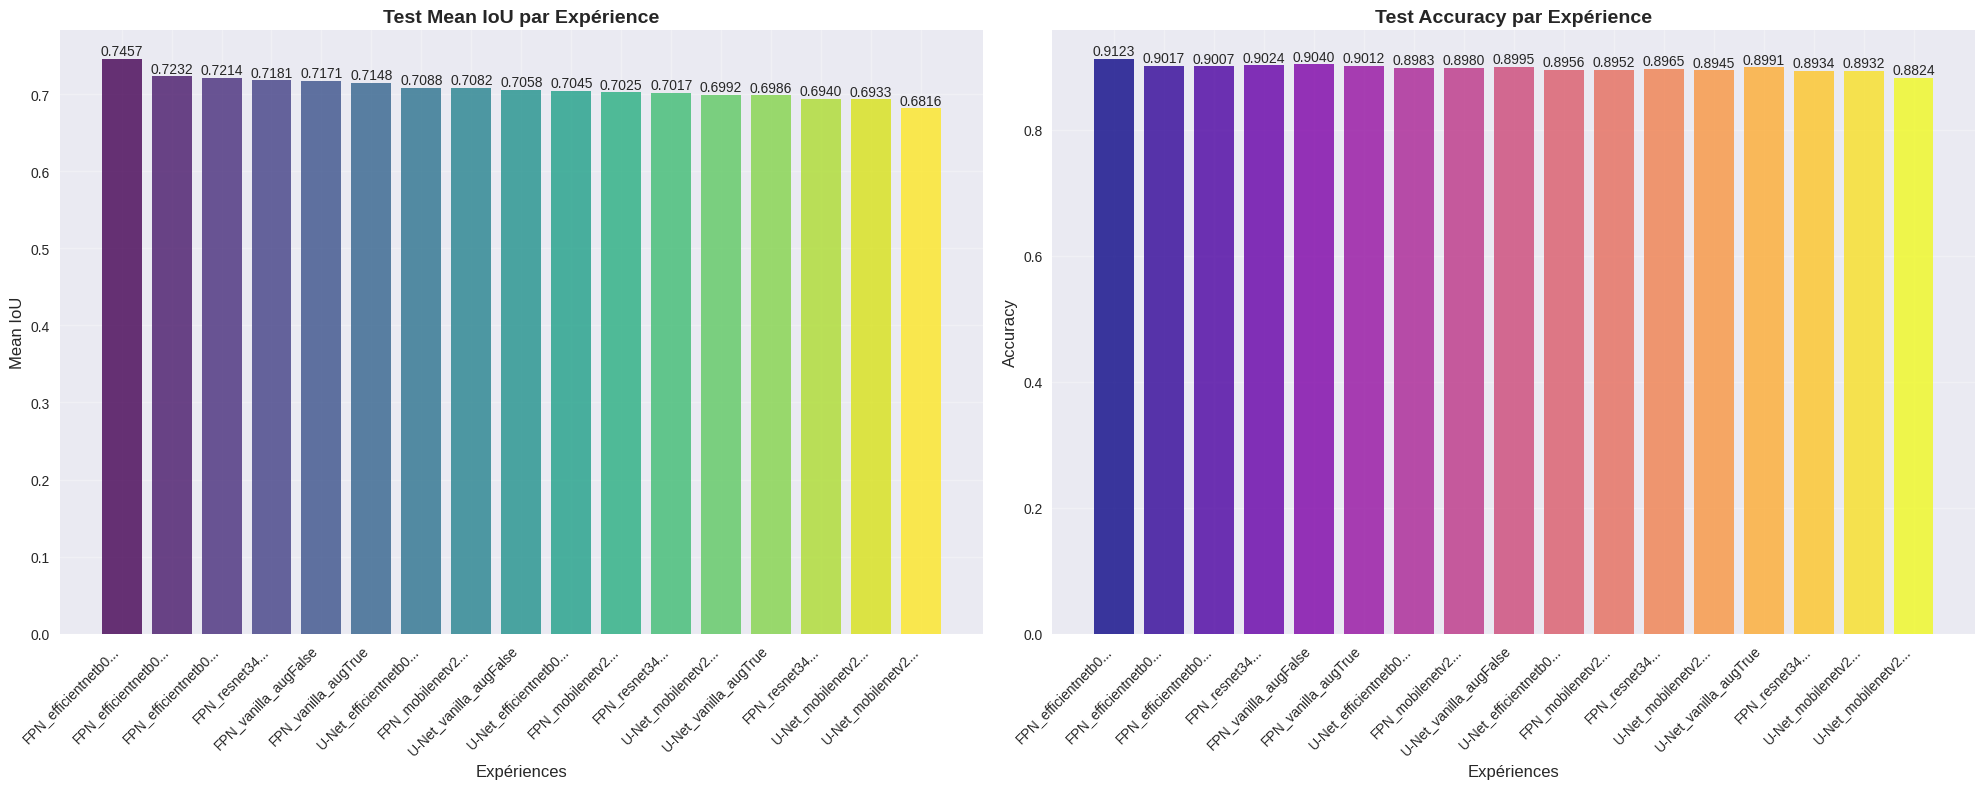

📊 Diagrammes générés pour 17 expériences (IoU) et 17 expériences (Accuracy)

✅ Analyse terminée. Utilisez show_detailed_results=True pour obtenir les données détaillées.


In [30]:
compare_experiments_mlflow(experiment_name=mlflow_experiemnt)

### Analyse meilleur modèle

Affichage des courbes d'apprentissage

In [31]:
def display_training_curves_from_best_run(experiment_name="OC Projet 8"):
    """
    Trouve le meilleur modèle (selon test_mean_iou) et affiche son graphique de courbes d'entraînement.
    """
    print(f"\n{'='*60}")
    print(f"📈 Affichage des courbes d'entraînement du meilleur modèle")
    print(f"🔬 Expérience MLflow: {experiment_name}")
    print(f"{'='*60}")

    client = mlflow.tracking.MlflowClient()

    try:
        # Récupérer l'expérience par nom
        experiment = client.get_experiment_by_name(experiment_name)
        if experiment is None:
            print(f"❌ Expérience '{experiment_name}' non trouvée.")
            return

        # Rechercher les runs terminés avec la métrique test_mean_iou
        runs_df = mlflow.search_runs(
            experiment_ids=[experiment.experiment_id],
            filter_string="status = 'FINISHED' and metrics.test_mean_iou >= 0",
            order_by=["metrics.test_mean_iou DESC"], # Trier par Mean IoU descendant
            max_results=1 # Prendre seulement le meilleur
        )

        if runs_df.empty:
            print("❌ Aucun run terminé avec la métrique test_mean_iou trouvé.")
            return

        # Le meilleur run est le premier dans la liste triée
        best_run = runs_df.iloc[0]
        best_run_id = best_run['run_id']
        best_run_name = best_run.get('tags.mlflow.runName', 'Unknown')
        best_iou = best_run['metrics.test_mean_iou']

        print(f"🏆 Meilleur run trouvé:")
        print(f"   • Run Name: {best_run_name}")
        print(f"   • Run ID: {best_run_id}")
        print(f"   • Test Mean IoU: {best_iou:.4f}")

        # Télécharger l'artefact 'training_curves.png'
        artifact_path = "training_curves.png"
        print(f"\n💾 Téléchargement de l'artefact '{artifact_path}'...")

        with tempfile.TemporaryDirectory() as tmpdir:
            local_path = mlflow.artifacts.download_artifacts(
                run_id=best_run_id,
                artifact_path=artifact_path,
                dst_path=tmpdir
            )
            print(f"✅ Artefact téléchargé vers: {local_path}")

            # Afficher l'image
            print("\n🖼️ Affichage de l'image...")
            img = PILImage.open(local_path)
            plt.figure(figsize=(12, 8))
            plt.imshow(img)
            plt.title(f"Courbes d'entraînement - {best_run_name}", fontsize=14)
            plt.axis('off') # Désactiver les axes
            plt.show()

    except Exception as e:
        print(f"❌ Erreur lors de l l'affichage des courbes d'entraînement: {e}")
        print("Vérifiez que l'artefact 'training_curves.png' existe pour le meilleur run.")


📈 Affichage des courbes d'entraînement du meilleur modèle
🔬 Expérience MLflow: OC Projet 8
🏆 Meilleur run trouvé:
   • Run Name: FPN_efficientnetb0_finetune_augTrue_prod
   • Run ID: b6dd1ecdeb3f4b5c899b332f3c948cd7
   • Test Mean IoU: 0.7457

💾 Téléchargement de l'artefact 'training_curves.png'...


✅ Artefact téléchargé vers: /tmp/tmpg4alyngv/training_curves.png

🖼️ Affichage de l'image...


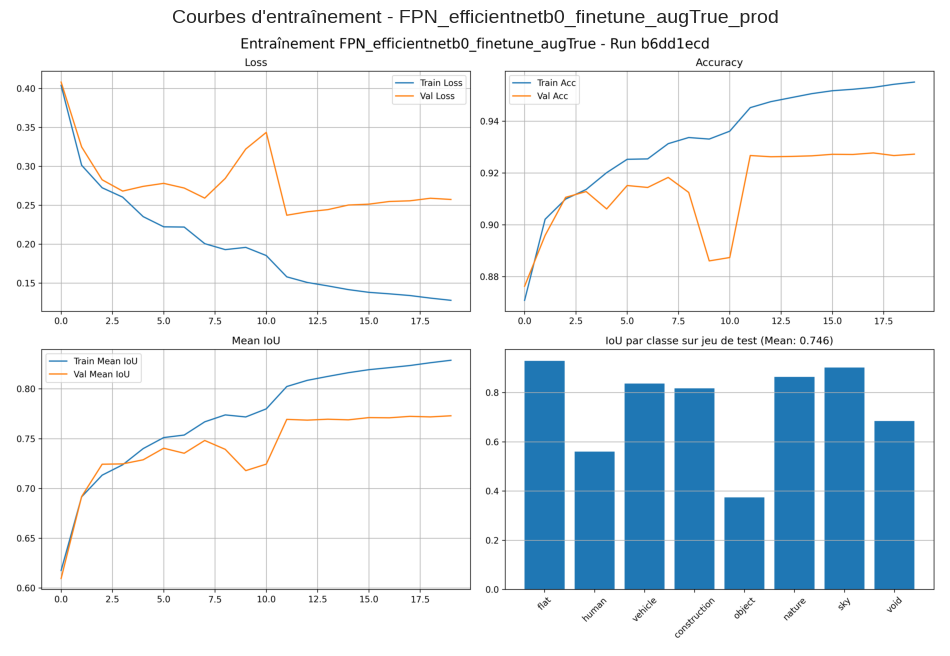

In [32]:
# Exécuter la fonction
display_training_curves_from_best_run(experiment_name=mlflow_experiemnt)

Affichage de la matrice de confusion en pourcentages

In [33]:
def display_best_confusion_matrix(experiment_name="OC Projet 8"):
    """
    Trouve le modèle avec la meilleure valeur test_mean_iou et affiche sa matrice de confusion

    Args:
        experiment_name (str): Nom de l'expérience MLflow
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    import json
    import tempfile

    # Récupérer les résultats des expériences
    completed_configs = get_completed_configs_info(experimental_configurations, experiment_name)

    if not completed_configs:
        print("❌ Aucune expérience terminée trouvée")
        return None

    # Récupérer le mapping run_name -> run_id depuis MLflow
    experiment = mlflow.get_experiment_by_name(experiment_name)
    runs_df = mlflow.search_runs(
        experiment_ids=[experiment.experiment_id],
        filter_string="status = 'FINISHED'",
        output_format="pandas"
    )

    run_name_to_id = {
        run.get('tags.mlflow.runName', ''): run['run_id']
        for _, run in runs_df.iterrows()
    }

    print(f"🔍 Recherche du meilleur modèle parmi {len(completed_configs)} configurations...")

    best_result = None
    best_iou = -1

    # Trouver le meilleur modèle
    for config_idx, config, run_name in completed_configs:
        if run_name not in run_name_to_id:
            continue

        run_id = run_name_to_id[run_name]

        try:
            # Récupérer les métriques
            run = mlflow.get_run(run_id)
            metrics = run.data.metrics

            test_mean_iou = metrics.get('test_mean_iou', None)

            if test_mean_iou is not None and test_mean_iou > best_iou:
                best_iou = test_mean_iou
                best_result = {
                    'config_idx': config_idx,
                    'experiment': config['name'],
                    'architecture': config.get('architecture', 'Unknown'),
                    'encoder': config.get('encoder', 'None'),
                    'test_mean_iou': test_mean_iou,
                    'test_accuracy': metrics.get('test_sparse_categorical_accuracy', 'N/A'),
                    'run_name': run_name,
                    'run_id': run_id
                }

        except Exception as e:
            print(f"⚠️ Erreur lors de l'analyse de {run_name}: {e}")
            continue

    if best_result is None:
        print("❌ Aucun modèle avec test_mean_iou trouvé")
        return None

    print(f"🏆 MEILLEUR MODÈLE TROUVÉ:")
    print(f"   📊 [{best_result['config_idx']}] {best_result['experiment']}")
    print(f"   🏗️  {best_result['architecture']} + {best_result['encoder']}")
    print(f"   🎯 Test Mean IoU: {best_result['test_mean_iou']:.4f}")
    print(f"   📈 Test Accuracy: {best_result['test_accuracy']:.4f}")
    print(f"   🆔 Run ID: {best_result['run_id']}")
    print()

    # Télécharger et charger la matrice de confusion
    try:
        with tempfile.TemporaryDirectory() as temp_dir:
            confusion_matrix_path = mlflow.artifacts.download_artifacts(
                run_id=best_result['run_id'],
                artifact_path="confusion_matrix.json",
                dst_path=temp_dir
            )

            with open(confusion_matrix_path, 'r') as f:
                confusion_data = json.load(f)

            matrix = np.array(confusion_data['matrix'])
            class_names = confusion_data['class_names']
            accuracy = confusion_data.get('accuracy', 'N/A')
            total_samples = confusion_data.get('total_samples', 'N/A')

            print(f"📋 Informations sur la matrice de confusion:")
            print(f"   🔢 Nombre de classes: {len(class_names)}")
            print(f"   📊 Échantillons totaux: {total_samples:,}" if total_samples != 'N/A' else "   📊 Échantillons totaux: N/A")
            print(f"   ✅ Précision globale: {accuracy:.4f}" if accuracy != 'N/A' else "   ✅ Précision globale: N/A")
            print()

            # Calculer les métriques par classe
            print("📈 Métriques par classe:")
            print("-" * 50)

            for i, class_name in enumerate(class_names):
                # Précision: TP / (TP + FP)
                tp = matrix[i, i]
                fp = np.sum(matrix[:, i]) - tp
                fn = np.sum(matrix[i, :]) - tp

                precision = tp / (tp + fp) if (tp + fp) > 0 else 0
                recall = tp / (tp + fn) if (tp + fn) > 0 else 0
                f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

                print(f"   {class_name:12s} - Précision: {precision:.4f} | Rappel: {recall:.4f} | F1: {f1:.4f}")

            print()

            # Créer la visualisation
            plt.figure(figsize=(12, 10))

            # Normaliser la matrice pour l'affichage (en pourcentages)
            matrix_normalized = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis] * 100

            # Créer le heatmap
            sns.heatmap(matrix_normalized,
                       annot=True,
                       fmt='.1f',
                       cmap='Blues',
                       xticklabels=class_names,
                       yticklabels=class_names,
                       cbar_kws={'label': 'Pourcentage (%)'})

            plt.title(f'Matrice de Confusion - {best_result["experiment"]}\n'
                     f'Mean IoU: {best_result["test_mean_iou"]:.4f} | Accuracy: {accuracy:.4f}',
                     fontsize=14, fontweight='bold', pad=20)
            plt.xlabel('Classes Prédites', fontsize=12)
            plt.ylabel('Classes Réelles', fontsize=12)
            plt.xticks(rotation=45, ha='right')
            plt.yticks(rotation=0)

            plt.tight_layout()
            plt.show()

            # Optionnel: afficher aussi la matrice brute
            print("🔢 Matrice de confusion brute (premiers/derniers éléments):")
            print("=" * 60)
            print("Classes:", class_names)
            print("Matrice (format: lignes=réel, colonnes=prédit):")
            print(matrix)

            return {
                'confusion_matrix': matrix,
                'class_names': class_names,
                'best_model_info': best_result,
                'accuracy': accuracy,
                'total_samples': total_samples
            }

    except Exception as e:
        print(f"❌ Erreur lors du téléchargement de la matrice de confusion: {e}")
        print(f"   Run ID: {best_result['run_id']}")
        print("   Vérifiez que l'artefact 'confusion_matrix.json' existe pour ce run.")
        return None

🔍 Vérification des expériences déjà terminées dans 'OC Projet 8'...
✅ 39 expériences terminées trouvées:
   - FPN_efficientnetb0_finetune_augTrue_prod
   - FPN_efficientnetb0_finetune_augTrue_test
   - FPN_efficientnetb0_frozen_augFalse_prod
   - FPN_efficientnetb0_frozen_augFalse_test
   - FPN_efficientnetb0_frozen_augTrue_prod
   - FPN_efficientnetb0_frozen_augTrue_test
   - FPN_mobilenetv2_frozen_augFalse_prod
   - FPN_mobilenetv2_frozen_augFalse_test
   - FPN_mobilenetv2_frozen_augTrue_prod
   - FPN_mobilenetv2_frozen_augTrue_test
   - FPN_resnet34_finetune_augTrue_prod
   - FPN_resnet34_finetune_augTrue_test
   - FPN_resnet34_frozen_augFalse_prod
   - FPN_resnet34_frozen_augFalse_test
   - FPN_resnet34_frozen_augTrue_prod
   - FPN_resnet34_frozen_augTrue_test
   - FPN_vanilla_augFalse_prod
   - FPN_vanilla_augFalse_test
   - FPN_vanilla_augTrue_prod
   - FPN_vanilla_augTrue_test
   - U-Net_efficientnetb0_frozen_augFalse_prod
   - U-Net_efficientnetb0_frozen_augFalse_test
   - U-Ne

📋 Informations sur la matrice de confusion:
   🔢 Nombre de classes: 8
   📊 Échantillons totaux: 25,088,000
   ✅ Précision globale: 0.9123

📈 Métriques par classe:
--------------------------------------------------
   flat         - Précision: 0.9474 | Rappel: 0.9795 | F1: 0.9632
   human        - Précision: 0.7097 | Rappel: 0.7266 | F1: 0.7181
   vehicle      - Précision: 0.9037 | Rappel: 0.9186 | F1: 0.9111
   construction - Précision: 0.8734 | Rappel: 0.9267 | F1: 0.8992
   object       - Précision: 0.6477 | Rappel: 0.4688 | F1: 0.5439
   nature       - Précision: 0.9213 | Rappel: 0.9319 | F1: 0.9266
   sky          - Précision: 0.9444 | Rappel: 0.9525 | F1: 0.9484
   void         - Précision: 0.9077 | Rappel: 0.7358 | F1: 0.8128



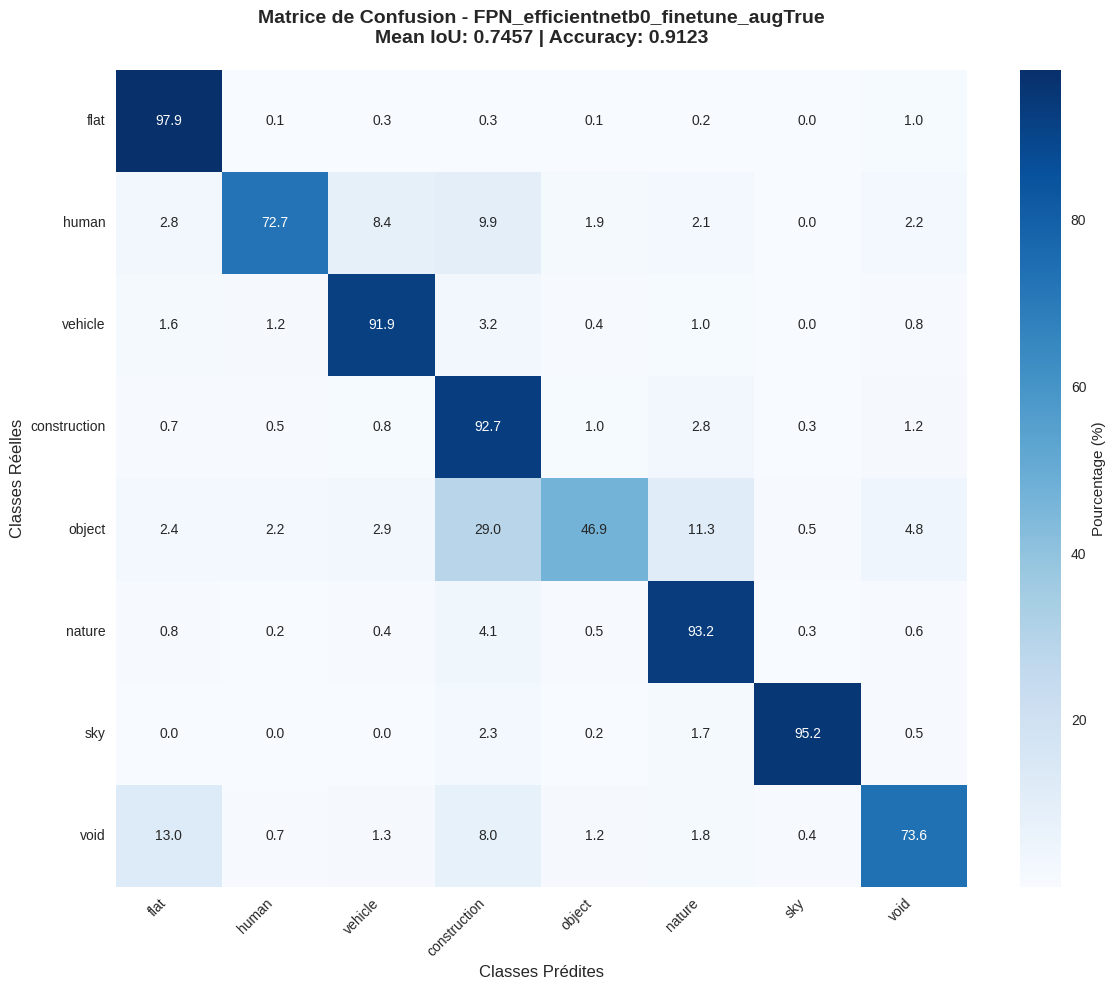

🔢 Matrice de confusion brute (premiers/derniers éléments):
Classes: ['flat', 'human', 'vehicle', 'construction', 'object', 'nature', 'sky', 'void']
Matrice (format: lignes=réel, colonnes=prédit):
[[9339912   11922   31996   27736    7639   19873     159   96403]
 [   9298  240878   27954   32796    6215    7121      22    7213]
 [  28923   20536 1630480   57085    7436   16871     280   13413]
 [  37107   27385   39861 4762597   51086  145430   14571   61532]
 [  12585   11363   14823  148802  240856   58198    2359   24774]
 [  30020    6106   17487  161547   21272 3703362   10850   23316]
 [      2       2     139   17203    1113   12668  701752    3902]
 [ 400815   21207   41511  245295   36253   56041   13049 2267598]]


In [34]:
# Utilisation
confusion_result = display_best_confusion_matrix()

Affichage de la répartition des modalités dans l'ensemble du dataset d'apprentissage (on passe par le json de matrice de confusion pour gagner du temps)

In [37]:
def analyze_class_distribution_from_confusion_matrix(experiment_name="OC Projet 8",
                                                   figsize=(14, 8),
                                                   color_palette='viridis',
                                                   show_values=True):
    """
    Analyse la répartition des classes à partir de la matrice de confusion du meilleur modèle.
    Affiche un graphique en barres avec pourcentages (axe gauche) et nombres absolus (axe droite).

    Args:
        experiment_name (str): Nom de l'expérience MLflow
        figsize (tuple): Taille de la figure (largeur, hauteur)
        color_palette (str): Palette de couleurs pour les barres
        show_values (bool): Afficher les valeurs sur les barres

    Returns:
        dict: Dictionnaire contenant les statistiques de distribution
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import json
    import tempfile
    import seaborn as sns

    # Récupérer les informations du meilleur modèle
    completed_configs = get_completed_configs_info(experimental_configurations, experiment_name)

    if not completed_configs:
        print("❌ Aucune expérience terminée trouvée")
        return None

    # Récupérer le mapping run_name -> run_id depuis MLflow
    experiment = mlflow.get_experiment_by_name(experiment_name)
    runs_df = mlflow.search_runs(
        experiment_ids=[experiment.experiment_id],
        filter_string="status = 'FINISHED'",
        output_format="pandas"
    )

    run_name_to_id = {
        run.get('tags.mlflow.runName', ''): run['run_id']
        for _, run in runs_df.iterrows()
    }

    # Trouver le meilleur modèle (même logique que display_best_confusion_matrix)
    best_result = None
    best_iou = -1

    for config_idx, config, run_name in completed_configs:
        if run_name not in run_name_to_id:
            continue

        run_id = run_name_to_id[run_name]

        try:
            run = mlflow.get_run(run_id)
            metrics = run.data.metrics
            test_mean_iou = metrics.get('test_mean_iou', None)

            if test_mean_iou is not None and test_mean_iou > best_iou:
                best_iou = test_mean_iou
                best_result = {
                    'config_idx': config_idx,
                    'experiment': config['name'],
                    'architecture': config.get('architecture', 'Unknown'),
                    'encoder': config.get('encoder', 'None'),
                    'test_mean_iou': test_mean_iou,
                    'run_name': run_name,
                    'run_id': run_id
                }
        except Exception as e:
            continue

    if best_result is None:
        print("❌ Aucun modèle avec test_mean_iou trouvé")
        return None

    print(f"🏆 Analyse de distribution pour le meilleur modèle:")
    print(f"   📊 [{best_result['config_idx']}] {best_result['experiment']}")
    print(f"   🎯 Test Mean IoU: {best_result['test_mean_iou']:.4f}")
    print()

    # Télécharger et analyser la matrice de confusion
    try:
        with tempfile.TemporaryDirectory() as temp_dir:
            confusion_matrix_path = mlflow.artifacts.download_artifacts(
                run_id=best_result['run_id'],
                artifact_path="confusion_matrix.json",
                dst_path=temp_dir
            )

            with open(confusion_matrix_path, 'r') as f:
                confusion_data = json.load(f)

            matrix = np.array(confusion_data['matrix'])
            class_names = confusion_data['class_names']

            # Calculer la distribution des classes (somme par ligne = nombre total de pixels réels par classe)
            class_counts = np.sum(matrix, axis=1)  # Somme par ligne pour obtenir le nombre total de chaque classe réelle
            total_pixels = np.sum(class_counts)
            class_percentages = (class_counts / total_pixels) * 100

            # Statistiques détaillées
            print("📈 RÉPARTITION DES CLASSES DANS L'ÉCHANTILLON:")
            print("=" * 65)
            print(f"{'Classe':<15} {'Nb Pixels':<12} {'Pourcentage':<12} {'Barre':<20}")
            print("-" * 65)

            for i, class_name in enumerate(class_names):
                bar_length = int(class_percentages[i] / 2)  # Barre visuelle
                bar = "█" * bar_length
                print(f"{class_name:<15} {class_counts[i]:<12,} {class_percentages[i]:<11.2f}% {bar}")

            print("-" * 65)
            print(f"{'TOTAL':<15} {total_pixels:<12,} {'100.00%':<12}")
            print()

            # Créer le graphique
            fig, ax1 = plt.subplots(figsize=figsize)

            # Utiliser une palette de couleurs
            colors = plt.cm.get_cmap(color_palette)(np.linspace(0, 1, len(class_names)))

            # Barres avec les pourcentages (axe gauche)
            bars = ax1.bar(range(len(class_names)), class_percentages,
                          color=colors, alpha=0.8, edgecolor='black', linewidth=1)

            # Configuration axe gauche (pourcentages)
            ax1.set_xlabel('Classes', fontsize=12, fontweight='bold')
            ax1.set_ylabel('Pourcentage (%)', fontsize=12, fontweight='bold', color='blue')
            ax1.tick_params(axis='y', labelcolor='blue')
            ax1.set_xticks(range(len(class_names)))
            ax1.set_xticklabels(class_names, rotation=45, ha='right')
            ax1.grid(True, alpha=0.3, axis='y')

            # Créer un second axe y pour les nombres absolus
            ax2 = ax1.twinx()
            ax2.set_ylabel('Nombre de Pixels', fontsize=12, fontweight='bold', color='red')
            ax2.tick_params(axis='y', labelcolor='red')

            # Synchroniser les échelles
            ax2.set_ylim(0, np.max(class_counts) * 1.1)
            ax1.set_ylim(0, np.max(class_percentages) * 1.1)

            # Ajouter les valeurs sur les barres si demandé
            if show_values:
                for i, (bar, count, pct) in enumerate(zip(bars, class_counts, class_percentages)):
                    height = bar.get_height()
                    # Pourcentage au-dessus de la barre
                    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                            f'{pct:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=10)
                    # Nombre absolu à l'intérieur de la barre
                    ax1.text(bar.get_x() + bar.get_width()/2., height/2,
                            f'{count:,}', ha='center', va='center',
                            color='white', fontweight='bold', fontsize=9)

            # Titre et mise en forme
            plt.title(f'Répartition des Classes par Pixels\n'
                     f'Total: {total_pixels:,} pixels | Mean IoU: {best_result["test_mean_iou"]:.4f}',
                     fontsize=14, fontweight='bold', pad=20)

            plt.tight_layout()
            plt.show()

            # Statistiques supplémentaires
            print("📊 STATISTIQUES COMPLÉMENTAIRES:")
            print("-" * 40)
            print(f"   🔢 Nombre total de pixels: {total_pixels:,}")
            print(f"   📏 Nombre de classes: {len(class_names)}")
            print(f"   📈 Classe la plus représentée: {class_names[np.argmax(class_counts)]} ({np.max(class_percentages):.2f}%)")
            print(f"   📉 Classe la moins représentée: {class_names[np.argmin(class_counts)]} ({np.min(class_percentages):.2f}%)")
            print(f"   ⚖️  Ratio max/min: {np.max(class_counts)/np.min(class_counts):.2f}")

            # Calcul de l'équilibrage des classes
            ideal_percentage = 100 / len(class_names)
            imbalance_scores = np.abs(class_percentages - ideal_percentage)
            avg_imbalance = np.mean(imbalance_scores)
            print(f"   ⚖️  Score de déséquilibre moyen: {avg_imbalance:.2f}% (0 = parfait équilibre)")
            print()

            return {
                'class_names': class_names,
                'class_counts': class_counts,
                'class_percentages': class_percentages,
                'total_pixels': total_pixels,
                'best_model_info': best_result,
                'most_common_class': class_names[np.argmax(class_counts)],
                'least_common_class': class_names[np.argmin(class_counts)],
                'imbalance_ratio': np.max(class_counts)/np.min(class_counts),
                'avg_imbalance_score': avg_imbalance
            }

    except Exception as e:
        print(f"❌ Erreur lors de l'analyse de distribution: {e}")
        print(f"   Run ID: {best_result['run_id']}")
        return None


def compare_class_distributions(experiment_name="OC Projet 8", top_n=3):
    """
    Compare la répartition des classes entre les N meilleurs modèles.

    Args:
        experiment_name (str): Nom de l'expérience MLflow
        top_n (int): Nombre de meilleurs modèles à comparer
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import json
    import tempfile
    import seaborn as sns

    # Récupérer et trier les modèles par performance
    completed_configs = get_completed_configs_info(experimental_configurations, experiment_name)

    if not completed_configs:
        print("❌ Aucune expérience terminée trouvée")
        return None

    experiment = mlflow.get_experiment_by_name(experiment_name)
    runs_df = mlflow.search_runs(
        experiment_ids=[experiment.experiment_id],
        filter_string="status = 'FINISHED'",
        output_format="pandas"
    )

    run_name_to_id = {
        run.get('tags.mlflow.runName', ''): run['run_id']
        for _, run in runs_df.iterrows()
    }

    # Collecter les performances de tous les modèles
    models_performance = []

    for config_idx, config, run_name in completed_configs:
        if run_name not in run_name_to_id:
            continue

        run_id = run_name_to_id[run_name]

        try:
            run = mlflow.get_run(run_id)
            metrics = run.data.metrics
            test_mean_iou = metrics.get('test_mean_iou', None)

            if test_mean_iou is not None:
                models_performance.append({
                    'config_idx': config_idx,
                    'experiment': config['name'],
                    'test_mean_iou': test_mean_iou,
                    'run_name': run_name,
                    'run_id': run_id
                })
        except Exception as e:
            continue

    # Trier par performance et prendre les N meilleurs
    models_performance.sort(key=lambda x: x['test_mean_iou'], reverse=True)
    top_models = models_performance[:top_n]

    print(f"🏆 COMPARAISON DES {len(top_models)} MEILLEURS MODÈLES:")
    print("=" * 60)

    # Analyser chaque modèle
    all_distributions = []
    class_names = None

    for i, model in enumerate(top_models):
        print(f"📊 Modèle #{i+1}: {model['experiment']} (IoU: {model['test_mean_iou']:.4f})")

        try:
            with tempfile.TemporaryDirectory() as temp_dir:
                confusion_matrix_path = mlflow.artifacts.download_artifacts(
                    run_id=model['run_id'],
                    artifact_path="confusion_matrix.json",
                    dst_path=temp_dir
                )

                with open(confusion_matrix_path, 'r') as f:
                    confusion_data = json.load(f)

                matrix = np.array(confusion_data['matrix'])
                if class_names is None:
                    class_names = confusion_data['class_names']

                class_counts = np.sum(matrix, axis=1)
                total_pixels = np.sum(class_counts)
                class_percentages = (class_counts / total_pixels) * 100

                all_distributions.append({
                    'model_name': f"Modèle {i+1}",
                    'percentages': class_percentages,
                    'counts': class_counts,
                    'iou': model['test_mean_iou']
                })

        except Exception as e:
            print(f"   ⚠️ Erreur: {e}")
            continue

    if not all_distributions:
        print("❌ Impossible de récupérer les données de distribution")
        return None

    # Créer le graphique de comparaison
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

    # Graphique 1: Pourcentages
    x_pos = np.arange(len(class_names))
    bar_width = 0.8 / len(all_distributions)

    for i, dist in enumerate(all_distributions):
        ax1.bar(x_pos + i * bar_width, dist['percentages'],
               bar_width, label=f"{dist['model_name']} (IoU: {dist['iou']:.3f})",
               alpha=0.8)

    ax1.set_xlabel('Classes')
    ax1.set_ylabel('Pourcentage (%)')
    ax1.set_title('Comparaison des Distributions par Classe (%)')
    ax1.set_xticks(x_pos + bar_width * (len(all_distributions) - 1) / 2)
    ax1.set_xticklabels(class_names, rotation=45, ha='right')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Graphique 2: Heatmap des différences relatives au meilleur modèle
    reference_dist = all_distributions[0]['percentages']  # Le meilleur modèle comme référence
    diff_matrix = []

    for dist in all_distributions:
        relative_diff = ((dist['percentages'] - reference_dist) / reference_dist) * 100
        diff_matrix.append(relative_diff)

    sns.heatmap(diff_matrix,
               xticklabels=class_names,
               yticklabels=[dist['model_name'] for dist in all_distributions],
               cmap='RdBu_r', center=0, annot=True, fmt='.1f',
               cbar_kws={'label': 'Différence relative (%)'},
               ax=ax2)

    ax2.set_title(f'Différences Relatives au Meilleur Modèle\n(Référence: {all_distributions[0]["model_name"]})')
    ax2.set_xlabel('Classes')

    plt.tight_layout()
    plt.show()

    return {
        'top_models': top_models,
        'distributions': all_distributions,
        'class_names': class_names
    }

🔍 Vérification des expériences déjà terminées dans 'OC Projet 8'...
✅ 39 expériences terminées trouvées:
   - FPN_efficientnetb0_finetune_augTrue_prod
   - FPN_efficientnetb0_finetune_augTrue_test
   - FPN_efficientnetb0_frozen_augFalse_prod
   - FPN_efficientnetb0_frozen_augFalse_test
   - FPN_efficientnetb0_frozen_augTrue_prod
   - FPN_efficientnetb0_frozen_augTrue_test
   - FPN_mobilenetv2_frozen_augFalse_prod
   - FPN_mobilenetv2_frozen_augFalse_test
   - FPN_mobilenetv2_frozen_augTrue_prod
   - FPN_mobilenetv2_frozen_augTrue_test
   - FPN_resnet34_finetune_augTrue_prod
   - FPN_resnet34_finetune_augTrue_test
   - FPN_resnet34_frozen_augFalse_prod
   - FPN_resnet34_frozen_augFalse_test
   - FPN_resnet34_frozen_augTrue_prod
   - FPN_resnet34_frozen_augTrue_test
   - FPN_vanilla_augFalse_prod
   - FPN_vanilla_augFalse_test
   - FPN_vanilla_augTrue_prod
   - FPN_vanilla_augTrue_test
   - U-Net_efficientnetb0_frozen_augFalse_prod
   - U-Net_efficientnetb0_frozen_augFalse_test
   - U-Ne

📈 RÉPARTITION DES CLASSES DANS L'ÉCHANTILLON:
Classe          Nb Pixels    Pourcentage  Barre               
-----------------------------------------------------------------
flat            9,535,640    38.01      % ███████████████████
human           331,497      1.32       % 
vehicle         1,775,024    7.08       % ███
construction    5,139,569    20.49      % ██████████
object          513,760      2.05       % █
nature          3,973,960    15.84      % ███████
sky             736,781      2.94       % █
void            3,081,769    12.28      % ██████
-----------------------------------------------------------------
TOTAL           25,088,000   100.00%     



/tmp/ipython-input-875444227.py:121: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap(color_palette)(np.linspace(0, 1, len(class_names)))


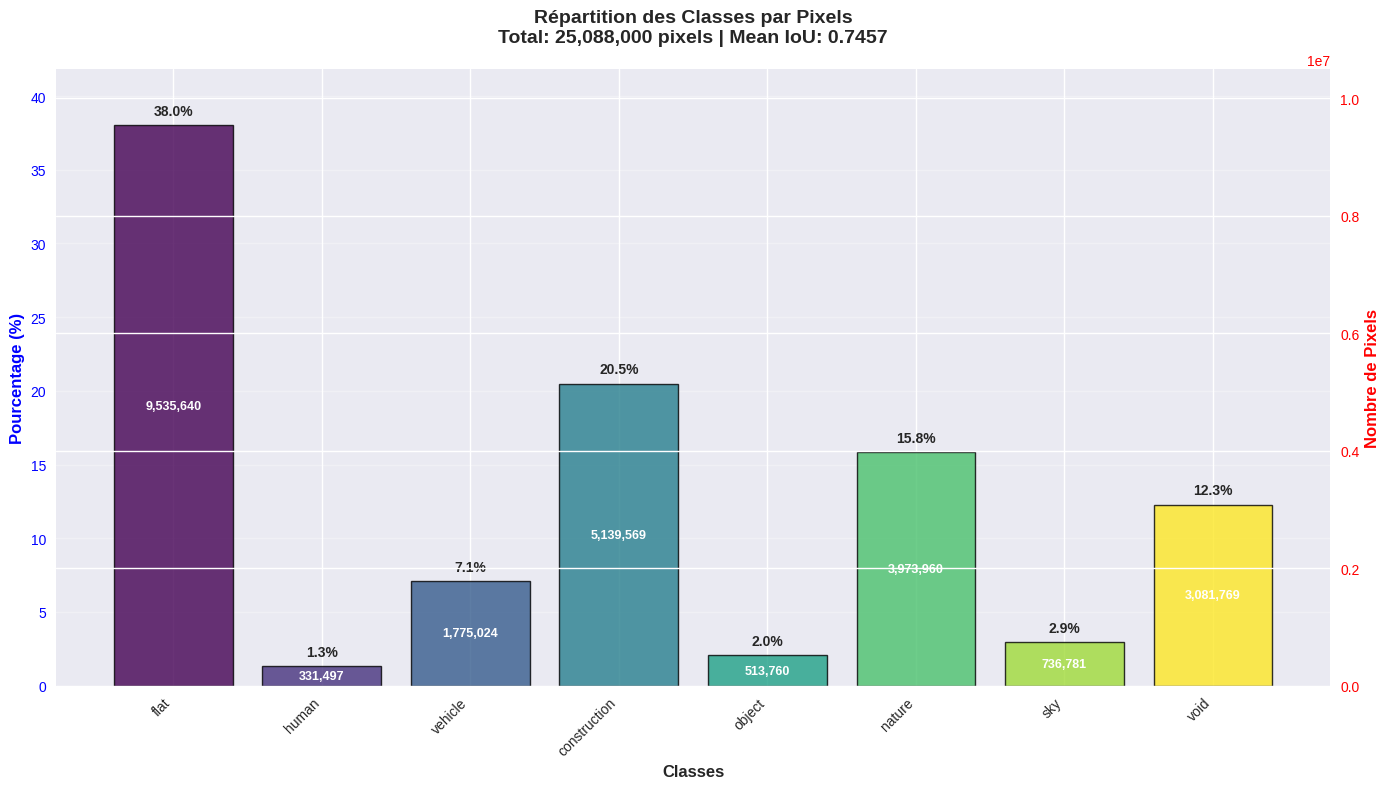

📊 STATISTIQUES COMPLÉMENTAIRES:
----------------------------------------
   🔢 Nombre total de pixels: 25,088,000
   📏 Nombre de classes: 8
   📈 Classe la plus représentée: flat (38.01%)
   📉 Classe la moins représentée: human (1.32%)
   ⚖️  Ratio max/min: 28.77
   ⚖️  Score de déséquilibre moyen: 9.21% (0 = parfait équilibre)

🔍 Vérification des expériences déjà terminées dans 'OC Projet 8'...
✅ 39 expériences terminées trouvées:
   - FPN_efficientnetb0_finetune_augTrue_prod
   - FPN_efficientnetb0_finetune_augTrue_test
   - FPN_efficientnetb0_frozen_augFalse_prod
   - FPN_efficientnetb0_frozen_augFalse_test
   - FPN_efficientnetb0_frozen_augTrue_prod
   - FPN_efficientnetb0_frozen_augTrue_test
   - FPN_mobilenetv2_frozen_augFalse_prod
   - FPN_mobilenetv2_frozen_augFalse_test
   - FPN_mobilenetv2_frozen_augTrue_prod
   - FPN_mobilenetv2_frozen_augTrue_test
   - FPN_resnet34_finetune_augTrue_prod
   - FPN_resnet34_finetune_augTrue_test
   - FPN_resnet34_frozen_augFalse_prod
   - FPN_re

📈 RÉPARTITION DES CLASSES DANS L'ÉCHANTILLON:
Classe          Nb Pixels    Pourcentage  Barre               
-----------------------------------------------------------------
flat            9,535,640    38.01      % ███████████████████
human           331,497      1.32       % 
vehicle         1,775,024    7.08       % ███
construction    5,139,569    20.49      % ██████████
object          513,760      2.05       % █
nature          3,973,960    15.84      % ███████
sky             736,781      2.94       % █
void            3,081,769    12.28      % ██████
-----------------------------------------------------------------
TOTAL           25,088,000   100.00%     



/tmp/ipython-input-875444227.py:121: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap(color_palette)(np.linspace(0, 1, len(class_names)))


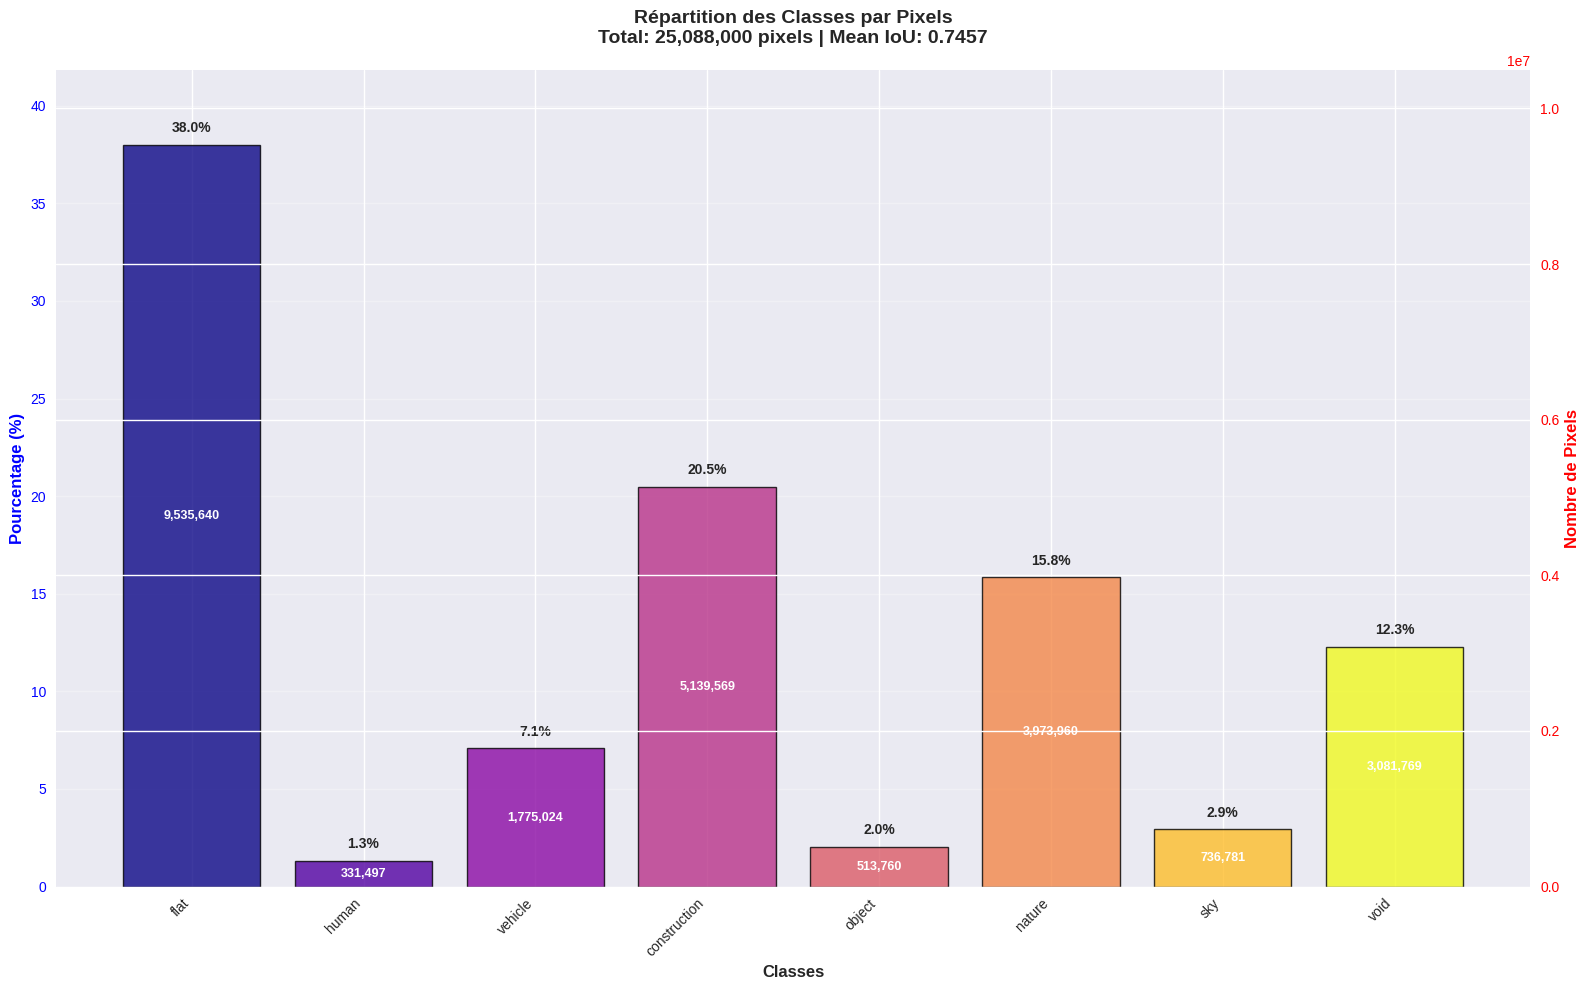

📊 STATISTIQUES COMPLÉMENTAIRES:
----------------------------------------
   🔢 Nombre total de pixels: 25,088,000
   📏 Nombre de classes: 8
   📈 Classe la plus représentée: flat (38.01%)
   📉 Classe la moins représentée: human (1.32%)
   ⚖️  Ratio max/min: 28.77
   ⚖️  Score de déséquilibre moyen: 9.21% (0 = parfait équilibre)

🔍 Vérification des expériences déjà terminées dans 'OC Projet 8'...
✅ 39 expériences terminées trouvées:
   - FPN_efficientnetb0_finetune_augTrue_prod
   - FPN_efficientnetb0_finetune_augTrue_test
   - FPN_efficientnetb0_frozen_augFalse_prod
   - FPN_efficientnetb0_frozen_augFalse_test
   - FPN_efficientnetb0_frozen_augTrue_prod
   - FPN_efficientnetb0_frozen_augTrue_test
   - FPN_mobilenetv2_frozen_augFalse_prod
   - FPN_mobilenetv2_frozen_augFalse_test
   - FPN_mobilenetv2_frozen_augTrue_prod
   - FPN_mobilenetv2_frozen_augTrue_test
   - FPN_resnet34_finetune_augTrue_prod
   - FPN_resnet34_finetune_augTrue_test
   - FPN_resnet34_frozen_augFalse_prod
   - FPN_re

📊 Modèle #2: FPN_efficientnetb0_frozen_augFalse (IoU: 0.7232)


📊 Modèle #3: FPN_efficientnetb0_frozen_augTrue (IoU: 0.7214)


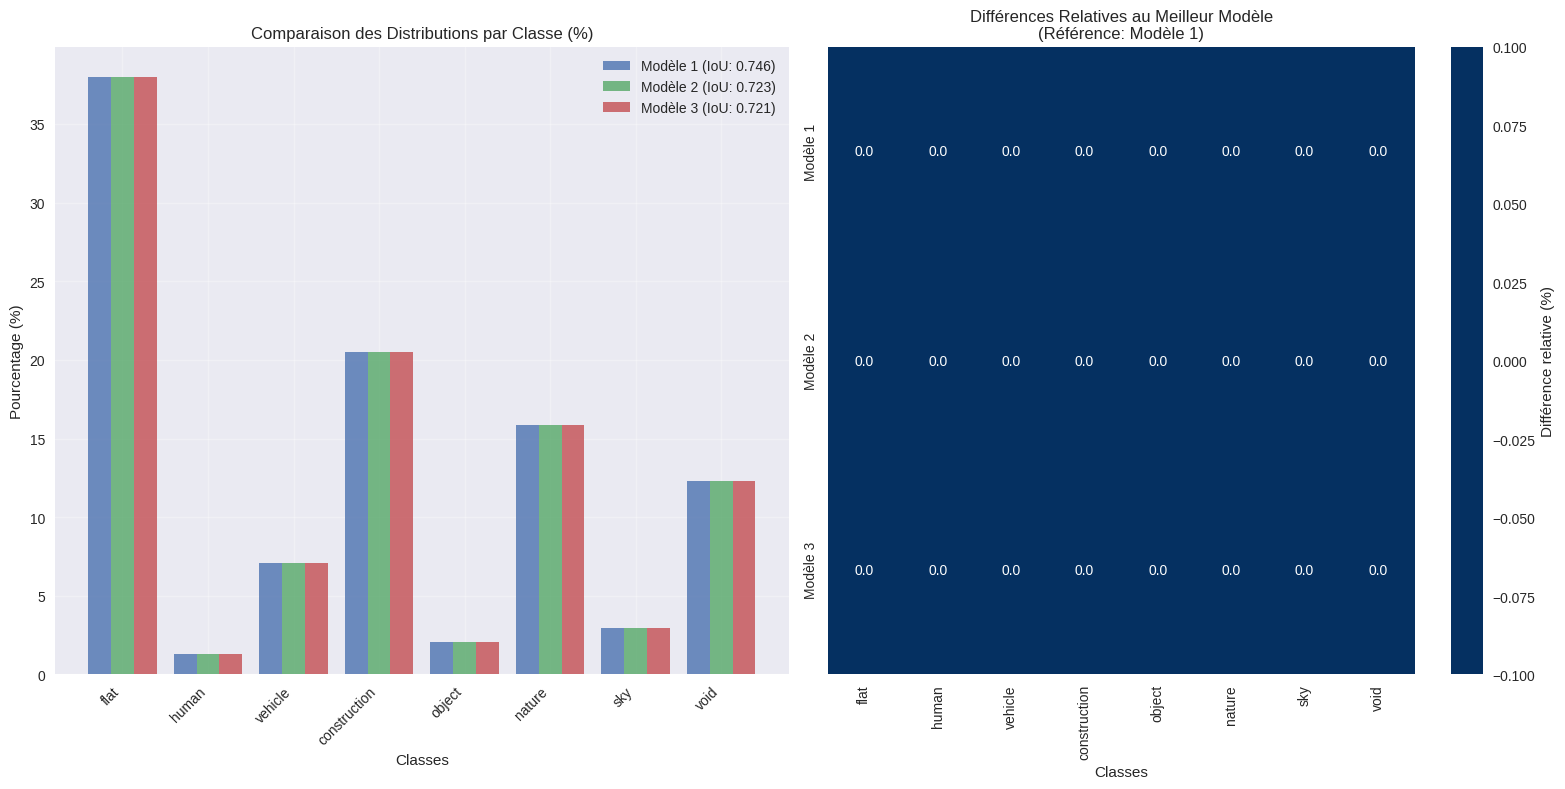

In [38]:
# Analyse simple du meilleur modèle
result = analyze_class_distribution_from_confusion_matrix("OC Projet 8")

# Avec personnalisation
result = analyze_class_distribution_from_confusion_matrix(
    experiment_name="OC Projet 8",
    figsize=(16, 10),
    color_palette='plasma',
    show_values=True
)

# Comparaison entre plusieurs modèles
comparison = compare_class_distributions("OC Projet 8", top_n=3)

### Mise en production meilleur modèle

In [ ]:
def register_best_model(experiment_name="OC Projet 8", model_name="StreetsSegmentation",
                       force=False, specific_run_id=None):
    """
    Enregistre le meilleur modèle (selon test_mean_iou) OU un modèle spécifique dans le Registry MLflow.

    Args:
        experiment_name (str): Nom de l'expérience MLflow
        model_name (str): Nom du modèle dans le Registry
        force (bool): Si True, force la mise en production même si le score est moins bon
        specific_run_id (str): Si fourni, enregistre ce run spécifique au lieu du meilleur
    """
    print(f"\n{'='*60}")
    if specific_run_id:
        print(f"🎯 Enregistrement d'un modèle SPÉCIFIQUE dans le Registry MLflow")
        print(f"🆔 Run ID spécifique: {specific_run_id}")
    else:
        print(f"🏆 Enregistrement du MEILLEUR modèle dans le Registry MLflow")
    print(f"🔬 Expérience MLflow: {experiment_name}")
    print(f"📦 Nom du modèle Registry: {model_name}")
    if force:
        print(f"⚡ Mode FORCE activé - Mise en prod forcée")
    print(f"{'='*60}")

    # 1. Si un run_id spécifique est fourni, l'utiliser directement
    if specific_run_id:
        print(f"🎯 Mode spécifique activé - utilisation du run {specific_run_id}")

        try:
            # Vérifier que le run existe et récupérer ses métriques
            run = mlflow.get_run(specific_run_id)
            metrics = run.data.metrics
            params = run.data.params

            test_mean_iou = metrics.get('test_mean_iou', None)
            test_accuracy = metrics.get('test_sparse_categorical_accuracy', None)
            run_name = run.data.tags.get('mlflow.runName', 'Unknown')

            if test_mean_iou is None:
                print("⚠️ Le run spécifique n'a pas de métrique test_mean_iou")
                if not force:
                    print("❌ Utilisez force=True pour forcer l'enregistrement sans métriques")
                    return None

            selected_result = {
                'run_id': specific_run_id,
                'test_mean_iou': test_mean_iou or -1.0,
                'test_accuracy': test_accuracy,
                'experiment_name': run_name,
                'selection_mode': 'specific'
            }

            print(f"✅ Run spécifique trouvé:")
            print(f"   • Run Name: {run_name}")
            print(f"   • Run ID: {specific_run_id}")
            if test_mean_iou:
                print(f"   • Test Mean IoU: {test_mean_iou:.4f}")
            if test_accuracy:
                print(f"   • Test Accuracy: {test_accuracy:.4f}")

        except Exception as e:
            print(f"❌ Erreur lors de la récupération du run spécifique {specific_run_id}: {e}")
            return None

    else:
        # 2. Mode automatique : trouver le meilleur modèle (logique existante)
        print("🔍 Mode automatique - recherche du meilleur modèle...")

        # Récupérer les configurations terminées (réutilise la logique existante)
        completed_configs = get_completed_configs_info(experimental_configurations, experiment_name)

        if not completed_configs:
            print("❌ Aucune expérience terminée trouvée")
            return None

        # Récupérer les métriques MLflow pour chaque run
        experiment = mlflow.get_experiment_by_name(experiment_name)
        runs_df = mlflow.search_runs(
            experiment_ids=[experiment.experiment_id],
            filter_string="status = 'FINISHED'",
            output_format="pandas"
        )

        run_name_to_id = {
            run.get('tags.mlflow.runName', ''): run['run_id']
            for _, run in runs_df.iterrows()
        }

        print(f"📊 Analyse de {len(completed_configs)} configurations terminées")

        # Collecter les résultats avec métriques
        results = []
        for config_idx, config, run_name in completed_configs:
            if run_name not in run_name_to_id:
                continue

            run_id = run_name_to_id[run_name]

            try:
                # Récupérer les métriques directement depuis MLflow
                run = mlflow.get_run(run_id)
                metrics = run.data.metrics

                test_mean_iou = metrics.get('test_mean_iou', None)

                if test_mean_iou is not None:
                    results.append({
                        'config_idx': config_idx,
                        'config': config,
                        'run_name': run_name,
                        'run_id': run_id,
                        'test_mean_iou': test_mean_iou,
                        'experiment_name': config['name']
                    })
                    print(f"   ✅ [{config_idx}] {config['name']}: IoU={test_mean_iou:.4f}")
                else:
                    print(f"   ⚠️ [{config_idx}] {config['name']}: Pas de test_mean_iou")

            except Exception as e:
                print(f"   ❌ [{config_idx}] {config['name']}: Erreur - {e}")
                continue

        if not results:
            print("❌ Aucune expérience avec test_mean_iou trouvée")
            return None

        # Trouver le meilleur modèle
        best_result = max(results, key=lambda x: x['test_mean_iou'])

        selected_result = {
            'run_id': best_result['run_id'],
            'test_mean_iou': best_result['test_mean_iou'],
            'experiment_name': best_result['experiment_name'],
            'selection_mode': 'automatic'
        }

        print(f"🏆 Meilleur modèle identifié:")
        print(f"   • Expérience: {best_result['experiment_name']}")
        print(f"   • Run ID: {best_result['run_id']}")
        print(f"   • Test Mean IoU: {best_result['test_mean_iou']:.4f}")

    # 3. Vérifier si le modèle existe dans le Registry (reste identique)
    client = mlflow.client.MlflowClient()
    current_best_iou = -1.0
    model_exists = False
    latest_version = None

    try:
        try:
            registered_model = client.get_registered_model(model_name)
            model_exists = True
            print(f"\n📦 Modèle '{model_name}' trouvé dans le Registry")
        except mlflow.exceptions.RestException:
            model_exists = False
            print(f"\n📦 Modèle '{model_name}' n'existe pas encore dans le Registry")

        if model_exists:
            model_versions = client.search_model_versions(f"name='{model_name}'")
            if model_versions:
                latest_version = max(model_versions, key=lambda v: int(v.version))
                current_run = mlflow.get_run(latest_version.run_id)
                current_best_iou = current_run.data.metrics.get('test_mean_iou', -1.0)

                print(f"   • Version la plus récente: {latest_version.version}")
                print(f"   • Stage: {latest_version.current_stage}")
                print(f"   • Test Mean IoU: {current_best_iou:.4f}")

    except Exception as e:
        print(f"⚠️ Erreur lors de la vérification du Registry: {e}")

    # 4. Logique de comparaison adaptée
    if specific_run_id:
        # En mode spécifique, on enregistre toujours (sauf si force=False et pas de métriques)
        should_register = True
        if selected_result['test_mean_iou'] == -1.0 and not force:
            should_register = False
            print("❌ Le run spécifique n'a pas de métriques et force=False")
    else:
        # En mode automatique, comparaison habituelle
        should_register = selected_result['test_mean_iou'] > current_best_iou or force

    # 5. Enregistrement (logique existante adaptée)
    if should_register:
        if specific_run_id:
            print(f"\n🎯 Enregistrement du modèle spécifique...")
            if selected_result['test_mean_iou'] > current_best_iou:
                action_msg = f"Le modèle spécifique ({selected_result['test_mean_iou']:.4f}) est meilleur que l'actuel ({current_best_iou:.4f})"
            elif force:
                action_msg = f"Enregistrement FORCÉ du modèle spécifique"
            else:
                action_msg = f"Enregistrement du modèle spécifique"
            print(f"   {action_msg}")
        else:
            if not model_exists:
                print(f"\n🆕 Création du modèle '{model_name}' dans le Registry...")
                action_msg = "Création et enregistrement du premier modèle"
            elif force and selected_result['test_mean_iou'] <= current_best_iou:
                print(f"\n⚡ FORCE MODE: Enregistrement forcé du modèle")
                print(f"   Nouveau: {selected_result['test_mean_iou']:.4f} vs Actuel: {current_best_iou:.4f}")
                action_msg = "Enregistrement forcé de la nouvelle version"
            else:
                print(f"\n🚀 Le nouveau modèle ({selected_result['test_mean_iou']:.4f}) est meilleur que l'actuel ({current_best_iou:.4f})")
                action_msg = "Enregistrement de la nouvelle version"

        print(f"   {action_msg}...")

        try:
            # Si le modèle n'existe pas, le créer
            if not model_exists:
                client.create_registered_model(
                    name=model_name,
                    description=f"Modèle de segmentation des rues - Performance: {selected_result['test_mean_iou']:.4f}"
                )
                print(f"   ✅ Modèle '{model_name}' créé dans le Registry")

            # Vérifier si une version existe déjà pour ce run spécifique
            existing_versions = [v for v in client.search_model_versions(f"name='{model_name}'")
                               if v.run_id == selected_result['run_id']]

            if existing_versions:
                model_version = existing_versions[0]
                print(f"   ℹ️ Version existante trouvée pour ce run: {model_version.version}")
            else:
                print("   📝 Enregistrement d'une nouvelle version...")

                # Chercher l'artefact du modèle
                artifacts = client.list_artifacts(selected_result['run_id'])
                model_artifact_path = None

                for artifact in artifacts:
                    if any(pattern in artifact.path.lower() for pattern in
                          ['model', 'best_model', '.keras', '.h5', '.pkl']):
                        model_artifact_path = artifact.path
                        break

                if model_artifact_path is None:
                    print("   ❌ Aucun artefact de modèle trouvé dans le run")
                    return None

                print(f"   📁 Artefact trouvé: {model_artifact_path}")

                model_version = client.create_model_version(
                    name=model_name,
                    source=f"runs:/{selected_result['run_id']}/{model_artifact_path}",
                    run_id=selected_result['run_id'],
                    description=f"Model from {selected_result['experiment_name']} - IoU: {selected_result['test_mean_iou']:.4f} - Mode: {selected_result['selection_mode']}"
                )

            # Ajouter les tags
            print("   🏷️ Ajout des tags de métadonnées...")
            tags_to_add = {
                "source_run_id": selected_result['run_id'],
                "test_mean_iou": str(selected_result['test_mean_iou']),
                "model_name": model_name,
                "source_experiment": selected_result['experiment_name'],
                "selection_mode": selected_result['selection_mode'],
                "registration_mode": "forced" if force and selected_result['test_mean_iou'] <= current_best_iou else "automatic"
            }

            for tag_key, tag_value in tags_to_add.items():
                client.set_model_version_tag(
                    name=model_name,
                    version=model_version.version,
                    key=tag_key,
                    value=tag_value
                )

            # Promouvoir en Production
            print(f"   🚀 Promotion de la version {model_version.version} en Production...")
            client.transition_model_version_stage(
                name=model_name,
                version=model_version.version,
                stage="Production",
                archive_existing_versions=True
            )

            print(f"✅ Modèle enregistré avec succès !")
            print(f"   • Nom: {model_name}")
            print(f"   • Version: {model_version.version}")
            print(f"   • Stage: Production")
            print(f"   • Test Mean IoU: {selected_result['test_mean_iou']:.4f}")
            print(f"   • Mode de sélection: {selected_result['selection_mode']}")

            return {
                'model_name': model_name,
                'version': model_version.version,
                'run_id': selected_result['run_id'],
                'test_mean_iou': selected_result['test_mean_iou'],
                'selection_mode': selected_result['selection_mode'],
                'action': 'created' if not model_exists else 'updated',
                'tags': tags_to_add
            }

        except Exception as e:
            print(f"❌ Erreur lors de l'enregistrement: {e}")
            return None
    else:
        print(f"\n➡️ Aucun enregistrement effectué")
        if specific_run_id:
            print("   Le run spécifique n'a pas de métriques suffisantes")
            print("   💡 Utilisez force=True pour forcer l'enregistrement")
        else:
            print(f"   La version actuelle ({current_best_iou:.4f}) est déjà optimale")
            print("   💡 Utilisez force=True pour forcer la mise en production")

        return {
            'model_name': model_name,
            'action': 'no_update',
            'reason': 'Insufficient metrics' if specific_run_id else 'Current version is optimal',
            'suggestion': 'Use force=True to override'
        }

In [ ]:
# Enregistrement automatique (seulement si meilleur)
register_best_model(experiment_name="OC Projet 8", model_name="StreetsSegmentation")


🎯 Enregistrement d'un modèle SPÉCIFIQUE dans le Registry MLflow
🆔 Run ID spécifique: b6dd1ecdeb3f4b5c899b332f3c948cd7
🔬 Expérience MLflow: OC Projet 8
📦 Nom du modèle Registry: StreetsSegmentation
⚡ Mode FORCE activé - Mise en prod forcée
🎯 Mode spécifique activé - utilisation du run b6dd1ecdeb3f4b5c899b332f3c948cd7
✅ Run spécifique trouvé:
   • Run Name: FPN_efficientnetb0_finetune_augTrue_prod
   • Run ID: b6dd1ecdeb3f4b5c899b332f3c948cd7
   • Test Mean IoU: 0.7457
   • Test Accuracy: 0.9123

📦 Modèle 'StreetsSegmentation' trouvé dans le Registry
   • Version la plus récente: 1
   • Stage: Production
   • Test Mean IoU: 0.7488

🎯 Enregistrement du modèle spécifique...
   Enregistrement FORCÉ du modèle spécifique
   Enregistrement FORCÉ du modèle spécifique...
   📝 Enregistrement d'une nouvelle version...


2025/08/11 08:49:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: StreetsSegmentation, version 2


   📁 Artefact trouvé: best_model.keras
   🏷️ Ajout des tags de métadonnées...
   🚀 Promotion de la version 2 en Production...


/tmp/ipython-input-652925202.py:269: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  client.transition_model_version_stage(


✅ Modèle enregistré avec succès !
   • Nom: StreetsSegmentation
   • Version: 2
   • Stage: Production
   • Test Mean IoU: 0.7457
   • Mode de sélection: specific


{'model_name': 'StreetsSegmentation',
 'version': '2',
 'run_id': 'b6dd1ecdeb3f4b5c899b332f3c948cd7',
 'test_mean_iou': 0.7457431554794312,
 'selection_mode': 'specific',
 'action': 'updated',
 'tags': {'source_run_id': 'b6dd1ecdeb3f4b5c899b332f3c948cd7',
  'test_mean_iou': '0.7457431554794312',
  'model_name': 'StreetsSegmentation',
  'source_experiment': 'FPN_efficientnetb0_finetune_augTrue_prod',
  'selection_mode': 'specific',
  'registration_mode': 'forced'}}

## Fonction d'inférence et démonstration

Les fonctions utiles sont toutes dans les imports en début de notebook

In [ ]:
# Charger config Cityscapes
mapping_config = load_cityscapes_config("../cityscapes_config.json", verbose=False)

# Charger le meilleur modèle du Registry MLflow
model_name = "StreetsSegmentation"
model, run_id, encoder_name, script_img_size = load_best_model_from_registry(model_name)
input_shape = (*script_img_size, 3)

print(f"✅ Modèle chargé du run {run_id} avec encoder '{encoder_name}'")
print(f"📐 Input shape: {input_shape}")
print(f"🎨 Nombre de classes: {mapping_config['num_classes']}")

# Créer dossier de résultats
os.makedirs("./results", exist_ok=True)


📦 Téléchargement du modèle StreetsSegmentation (run: b6dd1ecdeb3f4b5c899b332f3c948cd7)


🔄 Chargement sans compilation...
🔄 Recompilation avec MeanIoU...
✅ Modèle chargé et recompilé !
✅ Modèle chargé du run b6dd1ecdeb3f4b5c899b332f3c948cd7 avec encoder 'efficientnetb0'
📐 Input shape: (224, 224, 3)
🎨 Nombre de classes: 8


== Groupes de classes Cityscapes ==
  - flat : ['road', 'sidewalk', 'parking', 'rail track']
  - human : ['person', 'rider']
  - vehicle : ['car', 'truck', 'bus', 'train', 'motorcycle', 'bicycle', 'caravan', 'trailer']
  - construction : ['building', 'wall', 'fence', 'guard rail', 'bridge', 'tunnel']
  - object : ['pole', 'pole group', 'traffic sign', 'traffic light']
  - nature : ['vegetation', 'terrain']
  - sky : ['sky']
  - void : ['unlabeled', 'ego vehicle', 'rectification border', 'out of roi', 'static', 'dynamic', 'ground']

== Mapping ID Cityscapes → Groupe ==
  ID  0 ('unlabeled') → groupe 'void' (7)
  ID  1 ('ego vehicle') → groupe 'void' (7)
  ID  2 ('rectification border') → groupe 'void' (7)
  ID  3 ('out of roi') → groupe 'void' (7)
  ID  4 ('static') → groupe 'void' (7)
  ID  5 ('dynamic') → groupe 'void' (7)
  ID  6 ('ground') → groupe 'void' (7)
  ID  7 ('road') → groupe 'flat' (0)
  ID  8 ('sidewalk') → groupe 'flat' (0)
  ID  9 ('parking') → groupe 'flat' (0)
  ID 10

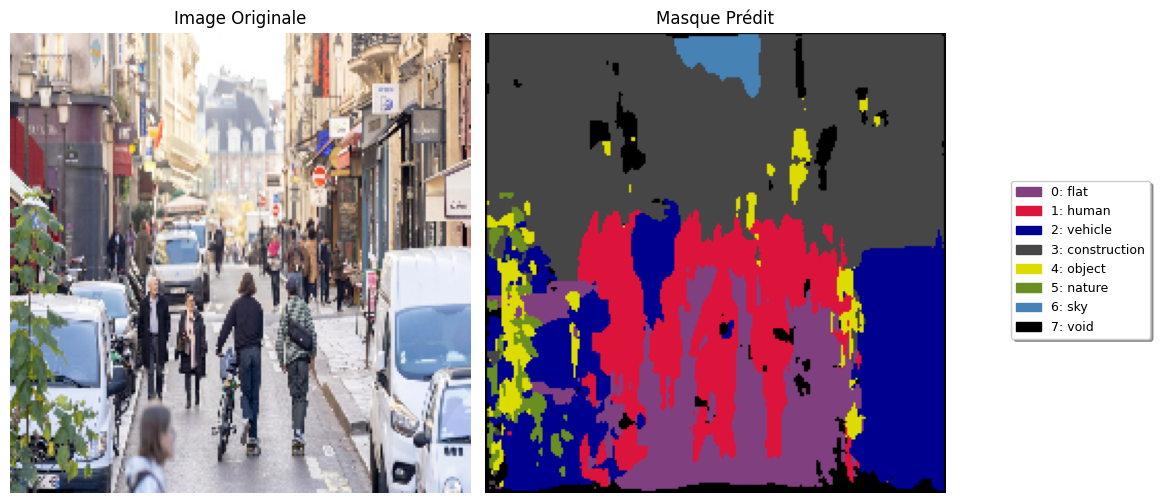


📊 Statistiques du masque prédit:
   flat: 6853 pixels (13.7%)
   human: 7970 pixels (15.9%)
   vehicle: 9227 pixels (18.4%)
   construction: 19823 pixels (39.5%)
   object: 1727 pixels (3.4%)
   nature: 889 pixels (1.8%)
   sky: 782 pixels (1.6%)
   void: 2905 pixels (5.8%)


In [ ]:
# === EXEMPLE D'UTILISATION ===

# 1. Charger la configuration des classes
mapping_config = load_cityscapes_config("../cityscapes_config.json")

# 2. Faire l'inférence sur une nouvelle image
predicted_mask1 = run_inference_and_visualize(
    image_path="./content/new_images_to_predict/paris_street.jpg",
    model=model,
    encoder_name=encoder_name,
    img_size=script_img_size,
    mapping_config=mapping_config
)

== Groupes de classes Cityscapes ==
  - flat : ['road', 'sidewalk', 'parking', 'rail track']
  - human : ['person', 'rider']
  - vehicle : ['car', 'truck', 'bus', 'train', 'motorcycle', 'bicycle', 'caravan', 'trailer']
  - construction : ['building', 'wall', 'fence', 'guard rail', 'bridge', 'tunnel']
  - object : ['pole', 'pole group', 'traffic sign', 'traffic light']
  - nature : ['vegetation', 'terrain']
  - sky : ['sky']
  - void : ['unlabeled', 'ego vehicle', 'rectification border', 'out of roi', 'static', 'dynamic', 'ground']

== Mapping ID Cityscapes → Groupe ==
  ID  0 ('unlabeled') → groupe 'void' (7)
  ID  1 ('ego vehicle') → groupe 'void' (7)
  ID  2 ('rectification border') → groupe 'void' (7)
  ID  3 ('out of roi') → groupe 'void' (7)
  ID  4 ('static') → groupe 'void' (7)
  ID  5 ('dynamic') → groupe 'void' (7)
  ID  6 ('ground') → groupe 'void' (7)
  ID  7 ('road') → groupe 'flat' (0)
  ID  8 ('sidewalk') → groupe 'flat' (0)
  ID  9 ('parking') → groupe 'flat' (0)
  ID 10

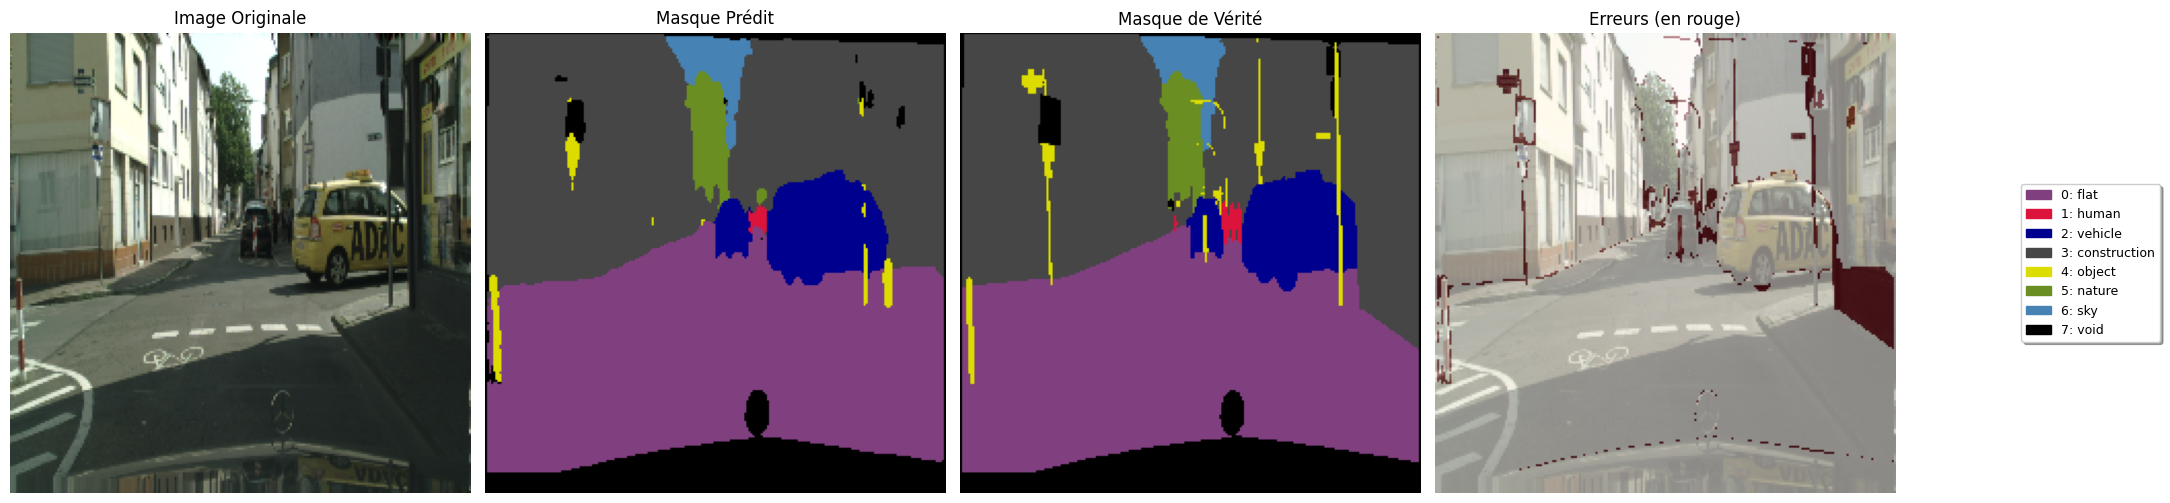


📊 Statistiques du masque prédit:
   flat: 19730 pixels (39.3%)
   human: 87 pixels (0.2%)
   vehicle: 2887 pixels (5.8%)
   construction: 19259 pixels (38.4%)
   object: 484 pixels (1.0%)
   nature: 1001 pixels (2.0%)
   sky: 883 pixels (1.8%)
   void: 5845 pixels (11.6%)

📊 Statistiques du masque de vérité:
   flat: 18943 pixels (37.8%)
   human: 165 pixels (0.3%)
   vehicle: 2759 pixels (5.5%)
   construction: 19632 pixels (39.1%)
   object: 873 pixels (1.7%)
   nature: 1013 pixels (2.0%)
   sky: 883 pixels (1.8%)
   void: 5908 pixels (11.8%)


In [ ]:
# === EXEMPLE D'UTILISATION ===

# 1. Charger la configuration des classes
mapping_config = load_cityscapes_config("../cityscapes_config.json")

# 2. Faire l'inférence sur une nouvelle image
predicted_mask1 = run_inference_and_visualize(
    image_path="./content/data/test_images_sample/original/frankfurt_000000_000294_leftImg8bit.png",
    mask_path="./content/data/test_images_sample/mask/frankfurt_000000_000294_gtFine_labelIds.png",
    model=model,
    encoder_name=encoder_name,
    img_size=script_img_size,
    mapping_config=mapping_config
)

# Rapport

De nombreux modèles ont été testés. Le meilleur modèle s'est avéré être `FPN` avec un backbone `efficientnetb0` (features extraction) aux poids **ajustables** le tout dans un contexte de données augmentées aléatoirement.

Limites du travail :
- Le prétraitement reste générique, en particulier la division par 255 pour placer les valeurs des pixels entre 0 et 1. Appliquer un prétraitement plus adapté à chaque backbone permettrait peut-être un entraînement plus efficace et une meilleure performance
- Généralisation au-delà de Cityscapes ? Globalement toujours les mêmes conditions de météo, mêmes environnements (urbains)... Modèle pas général
- Quid des performances en temps réel ?
- Taille fixe des images (224x224) pour faciliter l'apprentissage mais généralisation faible
- Backbone pré-entrainés sur imagenet... Mappilary Vistas serait plus pertinent (jeu de données orienté prises de vue sur la route, villes, campagnes, etc.) --> potentiel gain de transfer learning (feature extraction)
- IoU perfectible sur les humains, qui sont pourtant le plus important --> piste de travail à privilégier. Pour ce faire, data augmentation avec augmentation nombre d'humains (IA générative d'images, par exemple ?)
- Globalement performances assez proches pour tous les modèles : nous sommes probablement limités par le jeu de données

In [39]:
!pip freeze > requirements.txt